# Install libraries & version check
Code pipeline from the PNAS 2020 paper by Jiawei Zhuang et al. 

In [1]:
%%capture
!pip install -U numpy==1.18.5
!pip install h5py==2.10.0

In [ ]:
'Comment above cell and restart runtime'
'Upload 3 arrays for OOA analysis'

'Upload 3 arrays for OOA analysis'

In [1]:
'Check numpys version BEFORE and AFTER runtime restart'
import numpy as np
import matplotlib.pyplot as plt
print(np.__version__)


1.18.5


# Setup

In [2]:
%%capture
# !git clone https://github.com/aditya5252/Multiprocessor_Advection_.git
!pip install git+https://github.com/JiaweiZhuang/data-driven-pdes@fix-beam
%tensorflow_version 1.x

import os
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from google.colab import files  # colab-specific utilities; comment out when running locally

tf.enable_eager_execution()

tf.__version__, tf.keras.__version__
import xarray
from datadrivenpdes.core import grids
from datadrivenpdes.core import integrate
from datadrivenpdes.core import models
from datadrivenpdes.core import tensor_ops
from datadrivenpdes.advection import equations as advection_equations
from datadrivenpdes.pipelines import model_utils
from datadrivenpdes.core import geometry
from datadrivenpdes.core import polynomials
from typing import (Any, Dict, List, Optional, Mapping, Set, TypeVar, Tuple, Union)
from datadrivenpdes.core import states
from datadrivenpdes.core import equations
from datadrivenpdes.core import readers
import collections
# tf.keras.backend.set_floatx('float32')
import copy

In [3]:
def CD2_data(linear,init,c,ntime,N_x,delt,delx):
    data_ls=[]
    u=init
    if linear == True: 
        for step in range(ntime):
            data_ls.append(u) # At t = 0 ,step = 0  At t = ntime-1 , step = ntime-1
            unew=u.copy() 
            for i in range(1,N_x-1):
                unew[i]=u[i] + delt*( -c*(u[i+1]-u[i-1])/(2*delx) )  ## B.D. model
            unew[0]=u[0] + delt*( -c*(u[1]-u[N_x-2])/(2*delx) )
            unew[N_x-1]=unew[0] 
            u=unew
    elif linear == False:
        pass
    data_sol=np.stack(data_ls)
    return data_sol

def upwind_data(linear,init,c,ntime,N_x,delt,delx):
  data_ls=[]
  u=init
  if ((linear == True) and (c>0)): ## Apply B.D. with preiodic boundary conditions
      for step in range(ntime):
          data_ls.append(u) # At t = 0 ,step = 0  At t = ntime-1 , step = ntime-1
          unew=u.copy() 
          for i in range(1,N_x-1):
              unew[i]=u[i] + delt*( -c*(u[i]-u[i-1])/delx )  ## B.D. model
          unew[0]=u[0] + delt*( -c*(u[0]-u[N_x-2])/delx )
          unew[N_x-1]=unew[0] 
          u=unew

  elif ((linear == True) and (c<=0)): ## Apply F.D. with preiodic boundary conditions
      for step in range(ntime):
          data_ls.append(u) # At t = 0 ,step = 0  At t = ntime-1 , step = ntime-1
          unew=u.copy() 
          for i in range(1,N_x-1):
              unew[i]=u[i] + delt*( -c*(u[i+1]-u[i])/delx )  ## F.D. model
          unew[0]=u[0] + delt*( -c*(u[1]-u[0])/delx )
          unew[N_x-1]=unew[0] 
          u=unew
  else:
      print(c)
      for step in range(ntime):
          data_ls.append(u) # At t = 0 ,step = 0  At t = ntime-1 , step = ntime-1
          unew=u.copy()
          for i in range(1,N_x-1):
              if u[i]>0:
                  unew[i]=u[i] + delt*( -u[i]*(u[i]-u[i-1])/delx)
              else:
                  unew[i]=u[i] + delt*( -u[i]*(u[i+1]-u[i])/delx)
          if u[0]>0:
              unew[0]=u[0] + delt*( -u[0]*(u[0]-u[N_x-2])/delx)
          else:
              unew[0]=u[0] + delt*( -u[0]*(u[1]-u[0])/delx ) 
              
          unew[N_x-1]=unew[0]   
          u=unew
  data_sol=np.stack(data_ls)
  return data_sol

In [4]:
def ic(A,K,PHI,x_mesh):
  u=np.zeros_like(x_mesh)
  for A1,k1 in zip(A,K):
    for phi1 in PHI:
      u+= A1*np.sin(k1*x_mesh + phi1)
  return u

def solution_data(A,K,PHI,x_mesh,ntime,delt):
  # data_ls=[ u_ana[i]+=  amp[k1]*exp(-kappa[k1]*kappa[k1]*nu*tEnd)*sin(kappa[k1]*(x[i]-cx*tEnd)+phi[k2]) for i in range(ntime)]
  data_ls=[]
  for step in range(ntime):
    u=np.zeros_like(x_mesh)
    for A1,k1 in zip(A,K):
      for phi1 in PHI:
        u+= A1*np.sin(k1*(x_mesh-step*delt) + phi1)
    data_ls.append(u)
  data_sol=np.stack(data_ls)
  return data_sol

'Find dt for Advection-1d equation'
def _dx_dt(data,adv_coff):
    dx=2*np.pi/(data.shape[1])
    return dx,dx*0.08/adv_coff

'Plot time propagation of dataset'
def plot_time_prop(data,t0,t1,t2,tr='UnTrained'):
  plt.plot(data[t0],label=f'Max_{t0}={data[t0].max()}')
  plt.plot(data[t1],label=f'Max_{t1}={data[t1].max()}')
  plt.plot(data[t2],label=f'Max_{t2}={data[t2].max()}')
  plt.ylabel('Concentration')
  plt.xlabel('N_x')
  plt.title(tr+'Model Predictions')
  plt.legend()
  plt.show()



'Create initial_state dictionary from dataset'
def create_init_state_from_2d_data(data,adv_coff):
  c_init=data[0][np.newaxis,:,np.newaxis]

  initial_state_obj = {
      'concentration': c_init.astype(np.float32),  # tensorflow code expects float32
      'x_velocity': adv_coff*np.ones(c_init.shape, np.float32) * 1.0,
      'y_velocity': np.zeros(c_init.shape, np.float32)
  }

  for k, v in initial_state_obj.items():
    print(k, v.shape)   # (sample, x, y)
  return initial_state_obj


def create_init_state_from_Burger_init(c_data):
  c_init=c_data[np.newaxis,:,np.newaxis]

  initial_state_obj = {
      'concentration': c_init.astype(np.float32),  # tensorflow code expects float32
      'x_velocity': c_init.astype(np.float32),
      'y_velocity': np.zeros(c_init.shape, np.float32)}
  for k, v in initial_state_obj.items():
    print(k, v.shape)   # (sample, x, y)
  return initial_state_obj

'Create xarray DatArray from integrated dictionary'
def wrap_as_xarray(integrated):
  dr = xarray.DataArray(
      integrated['concentration'].numpy().squeeze(-1),
      dims = ('time', 'sample', 'x'),
      coords = {'time': time_steps, 'x': x_coarse.squeeze()}
  )
  return dr

def plotOOA(m,c,ls,err_ls):
  plt.plot(np.log(ls),-m*np.log(ls)+c,'r',label=f'{m}order accurate')
  plt.plot(np.log(ls),np.log(err_ls),'b',label='Log-Error')
  plt.xlabel('LogNx')
  plt.ylabel('LogError')
  plt.legend()
  plt.title('Order of Accuracy Plot')
  plt.show()
def delay_(max_delay,prob_dist):
  allowed_delays=np.arange(0.,max_delay)
  delay_chosen=choice(allowed_delays,p=prob_dist)
  return delay_chosen

def modify_data(sub_data,DAsync=None):
  one_arr=np.ones_like(sub_data)

  boundary_arr=np.zeros_like(sub_data)
  boundary_arr[:,0]=1.
  boundary_arr[:,-1]=1.

  if (DAsync==0):
    delay_arr=np.zeros_like(sub_data)
  elif (DAsync==1):
    delay_arr=np.zeros_like(sub_data)
    for i in range(delay_arr.shape[0]):
      delay_arr[i,0]=delay_(nlevels,prob_set)
      delay_arr[i,-1]=delay_(nlevels,prob_set)

  del_arr = delay_arr + boundary_arr + one_arr 
  sub_data_modified=np.multiply(del_arr,sub_data)

  return sub_data_modified


In [5]:
# This data-generation code is a bit involved, mostly because we use multi-step loss function.
# To produce large training data in parallel, refer to the create_training_data.py script in source code.

def reference_solution(initial_state_fine, fine_grid, coarse_grid, 
                       coarse_time_steps=256):
  'What does this function do'
  'Runs high-accuracy model at high-resolution'
  'smaller dx, => More Nx   => More Nt'
  'Subsample with  subsampling_factor=Resamplingfactor '
  'High accuracy data achieved on a coarse grid'
  'So essentially obtain coarse-grained, HIGH-ACCURACY, GROUND TRUTH data'
  'Return dict of items'


  'For my simple use-case , Resamplingfactor = 1 '
  'Hence, given sync_data dataset(128 x 32)'
  'sync_data dataset itself is taken as the ground truth'
  'Hence we do not need this function to obtain Ground truth data '

  # use high-order traditional scheme as reference model
  equation = advection_equations.VanLeerAdvection(cfl_safety_factor=0.08)
  key_defs = equation.key_definitions

  # reference model runs at high resolution
  model = models.FiniteDifferenceModel(equation, fine_grid)
  
  # need 8x more time steps for 8x higher resolution to satisfy CFL
  coarse_ratio = fine_grid.size_x // coarse_grid.size_x
  steps = np.arange(0, coarse_time_steps*coarse_ratio+1, coarse_ratio)

  # solve advection at high resolution
  integrated_fine = integrate.integrate_steps(model, initial_state_fine, steps)

  # regrid to coarse resolution
  integrated_coarse = tensor_ops.regrid(
      integrated_fine, key_defs, fine_grid, coarse_grid)
  
  return integrated_coarse


In [6]:
def ground_dict_from_data(data):
  conc_ground=tf.convert_to_tensor(data[:,np.newaxis,:,np.newaxis], dtype=tf.float32, dtype_hint=None, name=None)
  ground_soln_dict = {
      'concentration': conc_ground,  # tensorflow code expects float32
      'x_velocity': tf.ones_like(conc_ground, dtype=None, name=None) * 1.0,
      'y_velocity': tf.zeros_like(conc_ground, dtype=None, name=None)
  }
  for k, v in ground_soln_dict.items():
    print(k, v.shape)   # (sample, x, y)
  return ground_soln_dict

def make_train_data(integrated_coarse, coarse_time_steps=256, example_time_steps=4):
  # we need to re-format data so that single-step input maps to multi-step output

  # remove the last several time steps, as training input
  train_input = {k: v[:-example_time_steps] for k, v in integrated_coarse.items()}

  # merge time and sample dimension as required by model
  n_time, n_sample, n_x, n_y = train_input['concentration'].shape
  for k in train_input:
    train_input[k] = tf.reshape(train_input[k], [n_sample * n_time, n_x, n_y])

  print('\n train_input shape:')
  for k, v in train_input.items():
    print(k, v.shape)  # (merged_sample, x, y)

  # pick the shifted time series, as training output

  output_list = []
  for shift in range(1, example_time_steps+1):
    # output time series, starting from each single time step
    output_slice = integrated_coarse['concentration'][shift:coarse_time_steps - example_time_steps + shift + 1] 
    # merge time and sample dimension as required by training
    n_time, n_sample, n_x, n_y = output_slice.shape
    output_slice = tf.reshape(output_slice, [n_sample * n_time, n_x, n_y])
    output_list.append(output_slice)

  train_output = tf.stack(output_list, axis=1)  # concat along shift_time dimension, after sample dimension

  print('\n train_output shape:',  train_output.shape)  # (merged_sample, shift_time, x, y)

  # sanity check on shapes
  assert train_output.shape[0] == train_input['concentration'].shape[0]  # merged_sample
  assert train_output.shape[2] == train_input['concentration'].shape[1]  # x
  assert train_output.shape[3] == train_input['concentration'].shape[2]  # y
  assert train_output.shape[1] == example_time_steps

  return train_input, train_output

# Initialize model class

## Function extract patches

In [7]:
def OOA(x,y,m,c,mylabel='Neural Network Error'):
  plt.rcParams.update({'font.size': 20})
  plt.figure(figsize=(8,6))
  plt.plot(np.log(x),np.log(y),'o-',label=mylabel,linestyle='-.',linewidth=3, markersize=12)
  plt.plot(np.log(x),-m*np.log(x),'o-',label=f'Line with slope = -{m}',linestyle='-',linewidth=3, markersize=12)
  plt.ylabel('log(err_MAE)')
  plt.xlabel('log(N_x)')
  plt.grid()
  plt.title('Order of Accuracy plot')
  plt.legend()
  plt.show()
  
def periodic_padding_flexible(tensor, axis,padding=1):
    """
        add periodic padding to a tensor for specified axis
        tensor: input tensor
        axis: on or multiple axis to pad along, int or tuple
        padding: number of cells to pad, int or tuple

        return: padded tensor
    """


    if isinstance(axis,int):
        axis = (axis,)
    if isinstance(padding,int):
        padding = (padding,)

    ndim = len(tensor.shape)
    for ax,p in zip(axis,padding):
        # create a slice object that selects everything from all axes,
        # except only 0:p for the specified for right, and -p: for left

        ind_right = [slice(-p,None) if i == ax else slice(None) for i in range(ndim)]
        ind_left = [slice(0, p) if i == ax else slice(None) for i in range(ndim)]
        right = tensor[ind_right]
        left = tensor[ind_left]
        middle = tensor
        tensor = tf.concat([right,middle,left], axis=ax)

    return tensor
    
def my_extract_2d_patches(x,k_size):
  #1,64,1 tensor
  # x1=tf.squeeze(x,0)
  b = tf.constant([1,1,k_size], tf.int32)
  pad_size=k_size//2
  tiled=tf.tile(x,b)
  pad3d=periodic_padding_flexible(tiled, axis=(1),padding=(pad_size))
  pad4d=tf.expand_dims(pad3d,-1)
  t_ext = tf.extract_image_patches(pad4d,[1, k_size, k_size, 1],strides=[1, 1, 1, 1],rates=[1, 1, 1, 1],padding='VALID')
  return t_ext

## Modelclasses

In [8]:
nest = tf.contrib.framework.nest


T = TypeVar('T')


def sorted_values(x: Dict[Any, T]) -> List[T]:
  """Returns the sorted values of a dictionary."""
  return [x[k] for k in sorted(x)]


def stack_dict(state: Dict[Any, tf.Tensor]) -> tf.Tensor:
  """Stack a dict of tensors along its last axis."""
  return tf.stack(sorted_values(state), axis=-1)


class TimeStepModel(tf.keras.Model):
  """Model that predicts the state at the next time-step."""

  def __init__(
      self,
      equation: equations.Equation,
      grid: grids.Grid,
      num_time_steps: int = 1,
      target: Optional[str] = None,
      name: str = 'time_step_model',
  ):
    """Initialize a time-step model."""
    super().__init__(name=name)

    if num_time_steps < 1:
      raise ValueError('must use at least one time step')

    self.equation = equation
    self.grid = grid
    self.num_time_steps = num_time_steps

    if target is None and len(equation.evolving_keys) == 1:
      (target,) = equation.evolving_keys
    self.target = target

  def load_data(
      self,
      metadata: Mapping[str, Any],
      prefix: states.Prefix = states.Prefix.EXACT,
  ) -> tf.data.Dataset:
    """Load data into a tf.data.Dataset for inferrence or training."""

    def replace_state_keys_with_names(state):
      return {k: state[equation.key_definitions[k].with_prefix(prefix)]
              for k in equation.base_keys}

    equation = readers.get_equation(metadata)
    grid = readers.get_output_grid(metadata)
    keys = [equation.key_definitions[k].with_prefix(prefix)
            for k in equation.base_keys]
    dataset = readers.initialize_dataset(metadata, [keys], [grid])
    dataset = dataset.map(replace_state_keys_with_names)
    return dataset

  def call(self, inputs: Dict[str, tf.Tensor]) -> tf.Tensor:
    """Predict the target state after multiple time-steps.
    Args:
      inputs: dict of tensors with dimensions [batch, x, y].
    Returns:
      labels: tensor with dimensions [batch, time, x, y], giving the target
        value of the predicted state at steps [1, ..., self.num_time_steps]
        for model training.
    """
    constant_state = {k: v for k, v in inputs.items()
                      if k in self.equation.constant_keys}
    evolving_inputs = {k: v for k, v in inputs.items()
                       if k in self.equation.evolving_keys}

    def advance(evolving_state, _):
      return self.take_time_step({**evolving_state, **constant_state})

    advanced = tf.scan(
        advance, tf.range(self.num_time_steps), initializer=evolving_inputs)
    advanced = tensor_ops.moveaxis(advanced, source=0, destination=1)
    # TODO(shoyer): support multiple targets, once keras does.
    # https://github.com/tensorflow/tensorflow/issues/25299
    return advanced[self.target]

  def time_derivative(
      self, state: Mapping[str, tf.Tensor]) -> Dict[str, tf.Tensor]:
    """Compute the time derivative.
    Args:
      state: current state of the solution.
    Returns:
      Updated values for each non-constant term in the state.
    """
    raise NotImplementedError

  def take_time_step(
      self, state: Mapping[str, tf.Tensor]) -> Dict[str, tf.Tensor]:
    """Take a single time-step.
    Args:
      state: current state of the solution.
    Returns:
      Updated values for each non-constant term in the state.
    """
    raise NotImplementedError

  def to_config(self) -> Mapping[str, Any]:
    """Create a configuration dict for this model. Not possible for all models.
    """
    raise NotImplementedError


class SpatialDerivativeModel(TimeStepModel):
  """Model that predicts the next time-step implicitly via spatial derivatives.
  """

  def __init__(self, equation, grid, num_time_steps=1, target=None,
               name='spatial_derivative_model'):
    super().__init__(equation, grid, num_time_steps, target, name)

  def spatial_derivatives(
      self, state: Mapping[str, tf.Tensor]) -> Dict[str, tf.Tensor]:
    """Predict all needed spatial derivatives."""
    raise NotImplementedError

  def time_derivative(
      self, state: Mapping[str, tf.Tensor]) -> Dict[str, tf.Tensor]:
    """See base class."""
    inputs = self.spatial_derivatives(state)
    outputs = self.equation.time_derivative(self.grid, **inputs)
    return outputs

  def take_time_step(
      self, state: Mapping[str, tf.Tensor]) -> Dict[str, tf.Tensor]:
    """See base class."""
    inputs = self.spatial_derivatives(state)
    outputs = self.equation.take_time_step(self.grid, **inputs)
    return outputs


class FiniteDifferenceModel(SpatialDerivativeModel):
  """Baseline model with fixed order finite-differences or finite-volumes.
  This model doesn't need to be trained.
  """

  def __init__(
      self, equation, grid, accuracy_order=1, num_time_steps=1, target=None,
      name='finite_difference_model',
  ):
    super().__init__(equation, grid, num_time_steps, target, name)

    self.accuracy_order = accuracy_order
    self.parents = {}  # type: Dict[str, str]
    self.coefficients = {}  # type: Dict[str, Optional[np.ndarray]]
    self.stencils = {}  # type: Dict[str, List[np.ndarray]]

    for key in self.equation.all_keys:
      parent = equation.find_base_key(key)

      key_def = equation.key_definitions[key]
      parent_def = equation.key_definitions[parent]

      stencils = []
      for parent_offset, argument_offset, derivative_order in zip(
          parent_def.offset, key_def.offset, key_def.derivative_orders):
        stencil = polynomials.regular_stencil_1d(
            abs(parent_offset - argument_offset),
            derivative_order,
            accuracy_order,
            grid.step)
        stencils.append(stencil)

      if all(stencil.size == 1 for stencil in stencils):
        # sentinel value indicating that we should just reuse the parent tensor
        # rather than extracting patches and applying coefficients
        coefficients = None
      else:
        coefficients_2d = polynomials.coefficients(
            stencils, equation.METHOD, key_def.derivative_orders,
            accuracy_order, grid.step)
        coefficients = tf.convert_to_tensor(coefficients_2d.ravel(), tf.float32)

      self.parents[key] = parent
      self.stencils[key] = stencils
      self.coefficients[key] = coefficients

  def spatial_derivatives(
      self, inputs: Mapping[str, tf.Tensor], request: Set[str] = None,
  ) -> Dict[str, tf.Tensor]:
    """See base class."""
    if request is None:
      request = self.equation.all_keys

    result = {}
    for key in request:
      coefficients = self.coefficients[key]

      source = inputs[self.parents[key]]
      if coefficients is None:
        result[key] = source
      else:
        sizes = [stencil.size for stencil in self.stencils[key]]

        key_def = self.equation.key_definitions[key]
        parent_def = self.equation.key_definitions[self.parents[key]]
        shifts = [k - p for p, k in zip(parent_def.offset, key_def.offset)]

        patches = tensor_ops.extract_patches_2d(source, sizes, shifts)
        result[key] = tf.tensordot(coefficients, patches, axes=[-1, -1])
        assert result[key].shape[-2:] == source.shape[-2:], (
            result[key], source)

    return result

  def to_config(self) -> Mapping[str, Any]:
    return dict(accuracy_order=self.accuracy_order)


def _round_down_to_odd(x):
  return x if x % 2 else x - 1


def _round_down_to_even(x):
  return x - 1 if x % 2 else x


def build_stencils(
    key: states.StateDefinition,
    parent: states.StateDefinition,
    max_stencil_size: int,
    grid_step: float
) -> List[np.ndarray]:
  """Create stencils for use with learned coefficients."""
  stencils = []

  for parent_offset, key_offset in zip(parent.offset, key.offset):

    if parent_offset == key_offset:
      size = _round_down_to_odd(max_stencil_size)
    else:
      size = _round_down_to_even(max_stencil_size)

    # examples:
    # stencil_size=5 -> [-2, -1, 0, 1, 2]
    # stencil_size=4 -> [-2, -1, 0, 1]
    int_range = np.arange(size) - size // 2

    stencil = grid_step * (0.5 * abs(key_offset - parent_offset) + int_range)

    stencils.append(stencil)

  # we should only be using zero-centered stencils
  if not all(np.allclose(stencil.sum(), 0) for stencil in stencils):
    raise ValueError('stencils are not zero-centered for {} -> {}: {}'
                     .format(parent, key, stencils))

  return stencils


ConstraintLayer = Union[
    polynomials.PolynomialAccuracy, polynomials.PolynomialBias]


class FixedCoefficientsLayer(tf.keras.layers.Layer):
  """Layer representing fixed learned coefficients for a single derivative."""

  def __init__(
      self,
      constraint_layer: ConstraintLayer,
      stencils: List[np.ndarray],
      shifts: List[int],
      input_key: Optional[str] = None,
  ):
    self.constraint_layer = constraint_layer
    self.stencils = stencils
    self.shifts = shifts
    self.input_key = input_key
    super().__init__()

  def build(self, input_shape):
    shape = [self.constraint_layer.input_size]
    self.kernel = self.add_weight('kernel', shape=shape)

  def compute_output_shape(self, input_shape):
    return input_shape[:-1]

  def call(self, inputs):
    coefficients = self.constraint_layer(self.kernel)
    sizes = [stencil.size for stencil in self.stencils]
    patches = tensor_ops.extract_patches_2d(inputs, sizes, self.shifts)
    return tf.einsum('s,bxys->bxy', coefficients, patches)


class VaryingCoefficientsLayer(tf.keras.layers.Layer):
  """Layer representing varying coefficients for a single derivative."""

  def __init__(
      self,
      constraint_layer: ConstraintLayer,
      stencils: List[np.ndarray],
      shifts: List[int],
      input_key: Optional[str] = None,
  ):
    self.constraint_layer = constraint_layer
    self.stencils = stencils
    self.shifts = shifts
    self.input_key = input_key
    self.kernel_size = constraint_layer.input_size
    super().__init__(trainable=False)

  def compute_output_shape(self, input_shape):
    return input_shape[:-1]

  def call(self, inputs):
    (kernel, source) = inputs
    coefficients = self.constraint_layer(kernel)
    sizes = [stencil.size for stencil in self.stencils]
    patches=my_extract_2d_patches(source,sizes[0])
    # patches = tensor_ops.extract_patches_2d(source, sizes, self.shifts)
    return tf.einsum('bxys,bxys->bxy', coefficients, patches)


def normalize_learned_and_fixed_keys(
    learned_keys: Optional[Set[str]],
    fixed_keys: Optional[Set[str]],
    equation: equations.Equation,
) -> Tuple[Set[str], Set[str]]:
  """Normalize learned and fixed equation inputs."""
  if learned_keys is None and fixed_keys is None:
    fixed_keys = equation.base_keys
    learned_keys = equation.derived_keys

  elif fixed_keys is None:
    learned_keys = set(learned_keys)
    fixed_keys = equation.all_keys - learned_keys

  elif learned_keys is None:
    fixed_keys = set(fixed_keys)
    learned_keys = equation.all_keys - fixed_keys

  else:
    learned_keys = set(learned_keys)
    fixed_keys = set(fixed_keys)

    if learned_keys.intersection(fixed_keys):
      raise ValueError('learned and fixed inputs must be disjoint sets: '
                       '{} vs {}'.format(learned_keys, fixed_keys))

    missing_inputs = equation.all_keys - learned_keys - fixed_keys
    if missing_inputs:
      raise ValueError(
          'inputs {} not inclued in learned or fixed inputs: {} vs {}'
          .format(missing_inputs, learned_keys, fixed_keys))

  return learned_keys, fixed_keys


def build_output_layers(
    equation, grid, learned_keys,
    stencil_size=5,
    initial_accuracy_order=1,
    constrained_accuracy_order=1,
    layer_cls=FixedCoefficientsLayer,
    predict_permutations=True,
) -> Dict[str, ConstraintLayer]:
  """Build a map of output layers for spatial derivative models."""
  layers = {}
  modeled = set()

  # learned_keys is a set; it can change iteration order per python session
  # need to fix its iteration order to correctly save/load Keras models
  for key in sorted(learned_keys):
    if (not predict_permutations
        and equation.key_definitions[key].swap_xy() in modeled):
      # NOTE(shoyer): this only makes sense if geometric_transforms includes
      # permutations. Otherwise you won't be predicting every needed tensor.
      continue

    parent = equation.find_base_key(key)
    key_def = equation.key_definitions[key]
    modeled.add(key_def)
    parent_def = equation.key_definitions[parent]

    stencils = build_stencils(key_def, parent_def, stencil_size, grid.step)
    shifts = [k - p for p, k in zip(parent_def.offset, key_def.offset)]
    constraint_layer = polynomials.constraint_layer(
        stencils, equation.METHOD, key_def.derivative_orders[:2],
        constrained_accuracy_order, initial_accuracy_order, grid.step,
    )
    layers[key] = layer_cls(
        constraint_layer, stencils, shifts, input_key=parent)

  return layers


def average_over_transforms(func, geometric_transforms, state):
  """Average a function over transformations to achive rotation invariance."""
  result_list = collections.defaultdict(list)

  for transform in geometric_transforms:
    output = transform.inverse(func(transform.forward(state)))
    for k, v in output.items():
      result_list[k].append(v)

  result = {k: tf.add_n(v) / len(v) if len(v) > 1 else v[0]
            for k, v in result_list.items()}
  return result


class LinearModel(SpatialDerivativeModel):
  """Learn constant linear filters for spatial derivatives."""

  def __init__(self, equation, grid, stencil_size=5, initial_accuracy_order=1,
               constrained_accuracy_order=1, learned_keys=None,
               fixed_keys=None, num_time_steps=1, target=None,
               geometric_transforms=None, predict_permutations=True,
               name='linear_model'):
    super().__init__(equation, grid, num_time_steps, target, name)
    self.learned_keys, self.fixed_keys = (
        normalize_learned_and_fixed_keys(learned_keys, fixed_keys, equation))
    self.output_layers = build_output_layers(
        equation, grid, self.learned_keys, stencil_size, initial_accuracy_order,
        constrained_accuracy_order, layer_cls=FixedCoefficientsLayer,
        predict_permutations=predict_permutations)
    self.fd_model = FiniteDifferenceModel(
        equation, grid, initial_accuracy_order)
    self.geometric_transforms = geometric_transforms or [geometry.Identity()]

  def _apply_model(self, state):
    result = {}
    for key, layer in self.output_layers.items():
      input_tensor = state[layer.input_key]
      layer = self.output_layers[key]
      result[key] = layer(input_tensor)
    return result

  def spatial_derivatives(self, inputs):
    """See base class."""
    result = average_over_transforms(
        self._apply_model, self.geometric_transforms, inputs
    )

    if self.fixed_keys:
      result.update(
          self.fd_model.spatial_derivatives(inputs, self.fixed_keys)
      )
    return result


class Conv2DPeriodic(tf.keras.layers.Layer):
  """Conv2D layer with periodic boundary conditions."""

  def __init__(self, filters, kernel_size, **kwargs):
    # Let Conv2D handle argument normalization, e.g., kernel_size -> tuple
    self._layer = tf.keras.layers.Conv2D(
        filters, kernel_size, padding='valid', **kwargs)
    self.filters = self._layer.filters
    self.kernel_size = self._layer.kernel_size

    if any(size % 2 == 0 for size in self.kernel_size):
      raise ValueError('kernel size for conv2d is not odd: {}'
                       .format(self.kernel_size))

    super().__init__()

  def build(self, input_shape):
    self._layer.build(input_shape)
    super().build(input_shape)

  def compute_output_shape(self, input_shape):
    return input_shape[:-1] + (self.filters,)

  def call(self, inputs):
    padded = tensor_ops.pad_periodic_2d(inputs, self.kernel_size)
    result = self._layer(padded)
    assert result.shape[1:3] == inputs.shape[1:3], (result, inputs)
    return result


def conv2d_stack(num_outputs, num_layers=5, filters=32, kernel_size=5,
                 activation='relu', **kwargs):
  """Create a sequence of Conv2DPeriodic layers."""
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Lambda(stack_dict))
  for _ in range(num_layers - 1):
    layer = Conv2DPeriodic(
        filters, kernel_size, activation=activation, **kwargs)
    model.add(layer)
  model.add(Conv2DPeriodic(num_outputs, kernel_size, **kwargs))
  return model


def _rescale_01(array, axis):
  array_max = tf.reduce_max(array, axis, keep_dims=True)
  array_min = tf.reduce_min(array, axis, keep_dims=True)
  return (array - array_min) / (array_max - array_min)


class RescaledConv2DStack(tf.keras.Model):
  """Rescale input fields to stabilize PDE integration."""

  def __init__(self, num_outputs: int, scaled_keys: Set[str], **kwargs):
    super().__init__()
    self.original_model = conv2d_stack(num_outputs, **kwargs)
    self.scaled_keys = scaled_keys

  def call(self, inputs):
    inputs = inputs.copy()
    for key in self.scaled_keys:
      inputs[key] = _rescale_01(inputs[key], axis=(-1, -2))

    return self.original_model(inputs)


class ClippedConv2DStack(tf.keras.Model):
  """Clip input fields to stabilize PDE integration."""

  def __init__(self, num_outputs: int, scaled_keys: Set[str], **kwargs):
    super().__init__()
    self.original_model = conv2d_stack(num_outputs, **kwargs)
    self.scaled_keys = scaled_keys

  def call(self, inputs):
    inputs = inputs.copy()
    for key in self.scaled_keys:
      inputs[key] = tf.clip_by_value(inputs[key], 1e-3, 1.0 - 1e-3)

    return self.original_model(inputs)



## Pseudo-model-class

In [9]:

class myPseudoLinearModel(SpatialDerivativeModel):
  """Learn pseudo-linear filters for spatial derivatives."""

  def __init__(self, equation, grid, stencil_size=5, initial_accuracy_order=1,
               constrained_accuracy_order=1, learned_keys=None,
               fixed_keys=None, core_model_func=conv2d_stack,
               num_time_steps=1, geometric_transforms=None,
               predict_permutations=True, target=None,
               name='pseudo_linear_model', **kwargs):
    # NOTE(jiaweizhuang): Too many input arguments. Only document important or
    # confusing ones for now.
    # pylint: disable=g-doc-args
    """Initialize class.
    Args:
      core_model_func: callable (function or class object). It should return
        a Keras model (or layer) instance, which contains trainable weights.
        The returned core_model instance should take a dict of tensors as input
        (see the call() method in the base TimeStepModel class).
        Additional kwargs are passed to this callable to specify hyperparameters
        of core_model (such as number of layers and convolutional filters).
    """
    # pylint: enable=g-doc-args

    super().__init__(equation, grid, num_time_steps, target, name)

    self.learned_keys, self.fixed_keys = (
        normalize_learned_and_fixed_keys(learned_keys, fixed_keys, equation))
    self.output_layers = build_output_layers(
        equation, grid, self.learned_keys, stencil_size, initial_accuracy_order,
        constrained_accuracy_order, layer_cls=VaryingCoefficientsLayer,
        predict_permutations=predict_permutations)
    self.fd_model = FiniteDifferenceModel(
        equation, grid, initial_accuracy_order)
    self.geometric_transforms = geometric_transforms or [geometry.Identity()]
  
    num_outputs = sum(
        layer.kernel_size for layer in self.output_layers.values()
    )
    self.core_model = core_model_func(num_outputs, **kwargs)

  def _apply_model(self, state):
    net = self.core_model(state)

    size_splits = [
        self.output_layers[key].kernel_size for key in self.output_layers
    ]
    heads = tf.split(net, size_splits, axis=-1)

    result = {}
    for (key, layer), head in zip(self.output_layers.items(), heads):
      input_tensor = state[layer.input_key]
      result[key] = layer([head, input_tensor])
    return result

  def spatial_derivatives(self, inputs):
    """See base class."""
    result = average_over_transforms(
        self._apply_model, self.geometric_transforms, inputs
    )
    if self.fixed_keys:
      result.update(
          self.fd_model.spatial_derivatives(inputs, self.fixed_keys)
      )
    return result

class NonlinearModel(SpatialDerivativeModel):
  """Learn spatial derivatives directly."""

  def __init__(self, equation, grid, core_model_func=conv2d_stack,
               learned_keys=None, fixed_keys=None, num_time_steps=1,
               finite_diff_accuracy_order=1, target=None,
               name='nonlinear_model', **kwargs):
    super().__init__(equation, grid, num_time_steps, target, name)
    self.learned_keys, self.fixed_keys = (
        normalize_learned_and_fixed_keys(learned_keys, fixed_keys, equation))
    self.core_model = core_model_func(
        num_outputs=len(self.learned_keys), **kwargs)
    self.fd_model = FiniteDifferenceModel(
        equation, grid, finite_diff_accuracy_order)

  def spatial_derivatives(
      self, inputs: Mapping[str, tf.Tensor],
  ) -> Dict[str, tf.Tensor]:
    """See base class."""
    net = self.core_model(inputs)
    heads = tf.unstack(net, axis=-1)
    result = dict(zip(self.learned_keys, heads))

    if self.fixed_keys:
      result.update(
          self.fd_model.spatial_derivatives(inputs, self.fixed_keys)
      )
    return result


class DirectModel(TimeStepModel):
  """Learn time-evolution directly, ignoring the equation."""

  def __init__(self, equation, grid, core_model_func=conv2d_stack,
               num_time_steps=1, finite_diff_accuracy_order=1, target=None,
               name='direct_model', **kwargs):
    super().__init__(equation, grid, num_time_steps, target, name)
    self.keys = equation.evolving_keys
    self.core_model = core_model_func(num_outputs=len(self.keys), **kwargs)

  def take_time_step(self, inputs):
    """See base class."""
    net = self.core_model(inputs)
    heads = tf.unstack(net, axis=-1)
    return dict(zip(self.keys, heads))

# OOA analysis GPU

## Stencil size = 3 

(16, 1)
concentration (1, 16, 1)
x_velocity (1, 16, 1)
y_velocity (1, 16, 1)


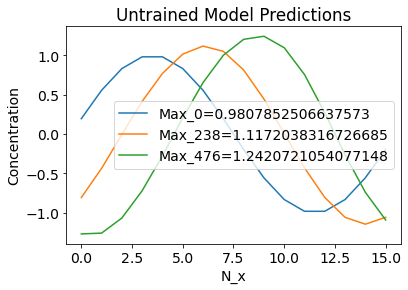

concentration (477, 1, 16, 1)
x_velocity (477, 1, 16, 1)
y_velocity (477, 1, 16, 1)

 train_input shape:
concentration (467, 16, 1)
x_velocity (467, 16, 1)
y_velocity (467, 16, 1)

 train_output shape: (467, 10, 16, 1)
Train on 467 samples
Epoch 1/20
467/467 [==============================] - 10s 22ms/sample - loss: 0.0027
Epoch 2/20
467/467 [==============================] - 1s 3ms/sample - loss: 0.0016
Epoch 3/20
467/467 [==============================] - 2s 4ms/sample - loss: 0.0013
Epoch 4/20
467/467 [==============================] - 2s 4ms/sample - loss: 0.0011
Epoch 5/20
467/467 [==============================] - 2s 4ms/sample - loss: 0.0010
Epoch 6/20
467/467 [==============================] - 2s 3ms/sample - loss: 9.1811e-04
Epoch 7/20
467/467 [==============================] - 2s 4ms/sample - loss: 8.8996e-04
Epoch 8/20
467/467 [==============================] - 2s 3ms/sample - loss: 8.3630e-04
Epoch 9/20
467/467 [==============================] - 1s 3ms/sample - loss: 8.2946

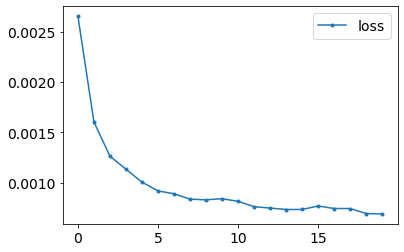

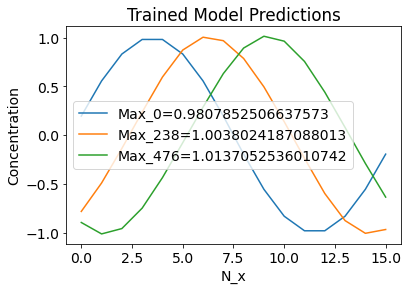

(32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)


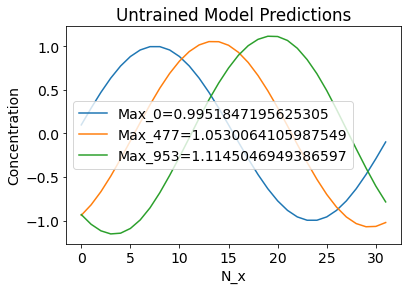

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (944, 32, 1)
x_velocity (944, 32, 1)
y_velocity (944, 32, 1)

 train_output shape: (944, 10, 32, 1)
Train on 944 samples
Epoch 1/20
944/944 [==============================] - 6s 6ms/sample - loss: 3.1170e-04
Epoch 2/20
944/944 [==============================] - 2s 2ms/sample - loss: 1.5617e-04
Epoch 3/20
944/944 [==============================] - 2s 2ms/sample - loss: 1.1922e-04
Epoch 4/20
944/944 [==============================] - 2s 2ms/sample - loss: 9.4191e-05
Epoch 5/20
944/944 [==============================] - 2s 2ms/sample - loss: 1.0130e-04
Epoch 6/20
944/944 [==============================] - 2s 2ms/sample - loss: 9.1655e-05
Epoch 7/20
944/944 [==============================] - 2s 2ms/sample - loss: 8.7832e-05
Epoch 8/20
944/944 [==============================] - 2s 2ms/sample - loss: 8.8005e-05
Epoch 9/20
944/944 [==============================] - 2s 2ms/sam

In [ ]:
STENCIL=3
err_ls=[]
ls=np.array([2**i for i in range(4,8)])
for ord in range(4,8):
  numPE=1
  grid_length = 2*np.pi
  resolution = 2**ord
  # 1d domain, so only 1 point along y dimension
  fine_grid = grids.Grid(
      size_x=resolution, size_y=1, 
      step=grid_length/resolution
      )
  x_fine, _ = fine_grid.get_mesh()
  print(x_fine.shape)

  CFL,u0,tend=0.08,1.,15.
  dx=grid_length/len(x_fine)
  dt=dx*CFL/abs(u0)
  N_t=int(tend//dt)
  time_steps=np.arange(N_t)
  initS=[[1],[1],[0]]
  data_ana=solution_data(initS[0],initS[1],initS[2],x_fine[:,0],N_t,dt)
  'Create initial state from data'
  initial_state=create_init_state_from_2d_data(data_ana,u0)

  model_nn = myPseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                      num_time_steps=10,stencil_size=STENCIL, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                      learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
  tf.random.set_random_seed(0)
  'Untrained'
  integrated_UT1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
  plot_time_prop(integrated_UT1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained ')

  ground_soln_dict=ground_dict_from_data(data_ana)
  train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
  'Training'
  model_nn.compile(optimizer='adam', loss='mae')
  history = model_nn.fit(train_input, train_output, epochs=20, batch_size=64, verbose=1, shuffle=True,use_multiprocessing=False,)
  df_history = pd.DataFrame(history.history)
  df_history.plot(marker='.')
  plt.show()

  'Trained'
  integrated_T1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
  plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')

  erAr=integrated_T1['concentration'].numpy().squeeze()[N_t-1]-data_ana[N_t-1]
  err_=np.mean(np.abs(erAr))
  err_ls.append(err_)
err_ls=np.array(err_ls)
OOA(ls,err_ls,2,0,f'Neural Network Error-stencil size = {STENCIL}')



## Stencil size = 5

In [ ]:
STENCIL=5
err_ls=[]
ls=np.array([2**i for i in range(4,8)])
for ord in range(4,8):
  numPE=1
  grid_length = 2*np.pi
  resolution = 2**ord
  # 1d domain, so only 1 point along y dimension
  fine_grid = grids.Grid(
      size_x=resolution, size_y=1, 
      step=grid_length/resolution
      )
  x_fine, _ = fine_grid.get_mesh()
  print(x_fine.shape)

  CFL,u0,tend=0.08,1.,15.
  dx=grid_length/len(x_fine)
  dt=dx*CFL/abs(u0)
  N_t=int(tend//dt)
  time_steps=np.arange(N_t)
  initS=[[1],[1],[0]]
  data_ana=solution_data(initS[0],initS[1],initS[2],x_fine[:,0],N_t,dt)
  'Create initial state from data'
  initial_state=create_init_state_from_2d_data(data_ana,u0)

  model_nn = myPseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                      num_time_steps=10,stencil_size=STENCIL, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                      learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
  tf.random.set_random_seed(0)
  'Untrained'
  integrated_UT1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
  plot_time_prop(integrated_UT1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained ')

  ground_soln_dict=ground_dict_from_data(data_ana)
  train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
  'Training'
  model_nn.compile(optimizer='adam', loss='mae')
  history = model_nn.fit(train_input, train_output, epochs=20, batch_size=64, verbose=1, shuffle=True,use_multiprocessing=False,)
  df_history = pd.DataFrame(history.history)
  df_history.plot(marker='.')
  plt.show()

  'Trained'
  integrated_T1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
  plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')

  erAr=integrated_T1['concentration'].numpy().squeeze()[N_t-1]-data_ana[N_t-1]
  err_=np.mean(np.abs(erAr))
  err_ls.append(err_)
err_ls=np.array(err_ls)
OOA(ls,err_ls,2,0,f'Neural Network Error-stencil size = {STENCIL}')



# OOA analysis

## Stencil size = 3 

(16, 1)
concentration (1, 16, 1)
x_velocity (1, 16, 1)
y_velocity (1, 16, 1)


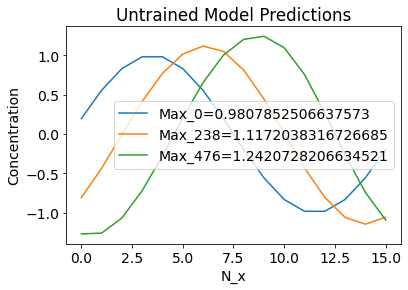

concentration (477, 1, 16, 1)
x_velocity (477, 1, 16, 1)
y_velocity (477, 1, 16, 1)

 train_input shape:
concentration (467, 16, 1)
x_velocity (467, 16, 1)
y_velocity (467, 16, 1)

 train_output shape: (467, 10, 16, 1)
Train on 467 samples
Epoch 1/20
467/467 [==============================] - 9s 20ms/sample - loss: 0.0027
Epoch 2/20
467/467 [==============================] - 2s 3ms/sample - loss: 0.0016
Epoch 3/20
467/467 [==============================] - 1s 3ms/sample - loss: 0.0013
Epoch 4/20
467/467 [==============================] - 1s 3ms/sample - loss: 0.0011
Epoch 5/20
467/467 [==============================] - 1s 3ms/sample - loss: 9.7418e-04
Epoch 6/20
467/467 [==============================] - 1s 3ms/sample - loss: 9.5754e-04
Epoch 7/20
467/467 [==============================] - 1s 3ms/sample - loss: 9.0523e-04
Epoch 8/20
467/467 [==============================] - 1s 3ms/sample - loss: 9.3048e-04
Epoch 9/20
467/467 [==============================] - 1s 2ms/sample - loss: 9.4

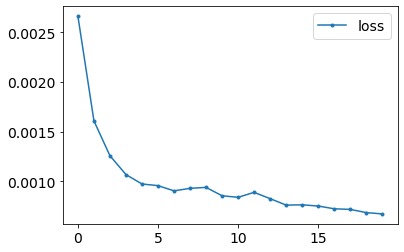

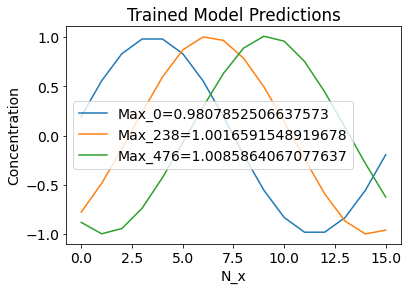

(32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)


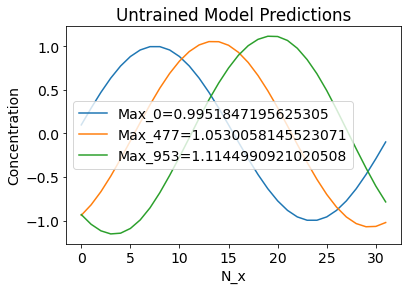

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (944, 32, 1)
x_velocity (944, 32, 1)
y_velocity (944, 32, 1)

 train_output shape: (944, 10, 32, 1)
Train on 944 samples
Epoch 1/20
944/944 [==============================] - 6s 7ms/sample - loss: 3.1135e-04
Epoch 2/20
944/944 [==============================] - 2s 3ms/sample - loss: 1.5307e-04
Epoch 3/20
944/944 [==============================] - 2s 3ms/sample - loss: 1.1691e-04
Epoch 4/20
944/944 [==============================] - 2s 3ms/sample - loss: 9.6890e-05
Epoch 5/20
944/944 [==============================] - 2s 3ms/sample - loss: 8.8391e-05
Epoch 6/20
944/944 [==============================] - 2s 3ms/sample - loss: 9.9107e-05
Epoch 7/20
944/944 [==============================] - 2s 3ms/sample - loss: 8.7604e-05
Epoch 8/20
944/944 [==============================] - 2s 3ms/sample - loss: 9.0014e-05
Epoch 9/20
944/944 [==============================] - 2s 3ms/sam

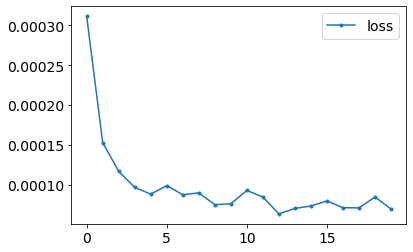

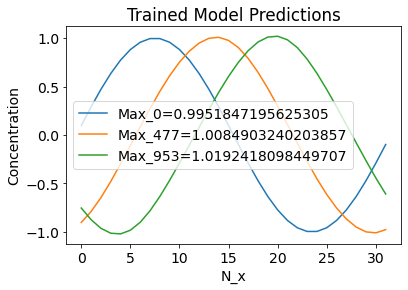

(64, 1)
concentration (1, 64, 1)
x_velocity (1, 64, 1)
y_velocity (1, 64, 1)


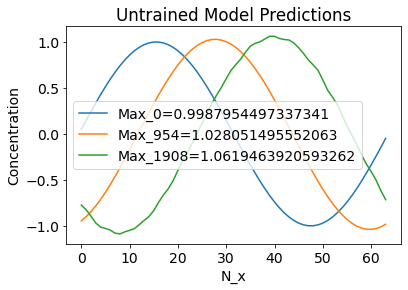

concentration (1909, 1, 64, 1)
x_velocity (1909, 1, 64, 1)
y_velocity (1909, 1, 64, 1)

 train_input shape:
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)

 train_output shape: (1899, 10, 64, 1)
Train on 1899 samples
Epoch 1/20
1899/1899 [==============================] - 11s 6ms/sample - loss: 4.2084e-05
Epoch 2/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 1.8951e-05
Epoch 3/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 1.3818e-05
Epoch 4/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 1.1665e-05
Epoch 5/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 1.1769e-05
Epoch 6/20
1899/1899 [==============================] - 10s 5ms/sample - loss: 1.0804e-05
Epoch 7/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 9.4146e-06
Epoch 8/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 9.2239e-06
Epoch 9/20
1899/1899 [================

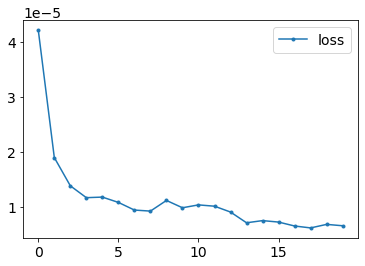

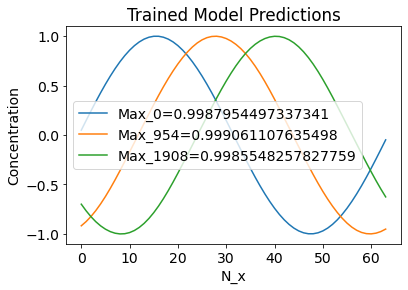

(128, 1)
concentration (1, 128, 1)
x_velocity (1, 128, 1)
y_velocity (1, 128, 1)


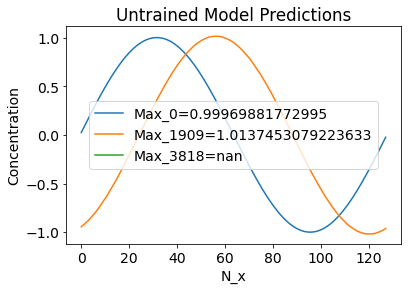

concentration (3819, 1, 128, 1)
x_velocity (3819, 1, 128, 1)
y_velocity (3819, 1, 128, 1)

 train_input shape:
concentration (3809, 128, 1)
x_velocity (3809, 128, 1)
y_velocity (3809, 128, 1)

 train_output shape: (3809, 10, 128, 1)
Train on 3809 samples
Epoch 1/20
3809/3809 [==============================] - 36s 9ms/sample - loss: 6.2478e-06
Epoch 2/20
3809/3809 [==============================] - 32s 8ms/sample - loss: 3.2874e-06
Epoch 3/20
3809/3809 [==============================] - 32s 8ms/sample - loss: 2.2370e-06
Epoch 4/20
3809/3809 [==============================] - 32s 8ms/sample - loss: 1.9577e-06
Epoch 5/20
3809/3809 [==============================] - 32s 8ms/sample - loss: 1.8816e-06
Epoch 6/20
3809/3809 [==============================] - 32s 8ms/sample - loss: 1.6089e-06
Epoch 7/20
3809/3809 [==============================] - 32s 8ms/sample - loss: 1.5222e-06
Epoch 8/20
3809/3809 [==============================] - 32s 8ms/sample - loss: 1.4181e-06
Epoch 9/20
3809/3809 [===

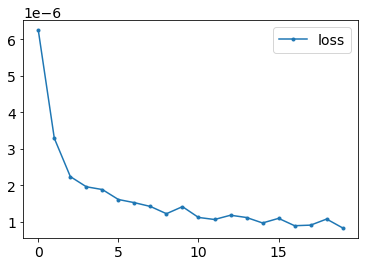

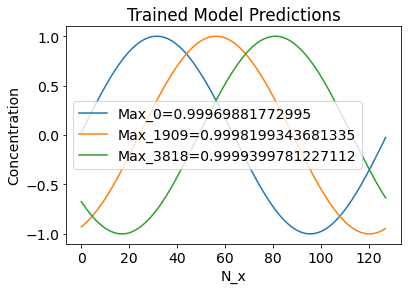

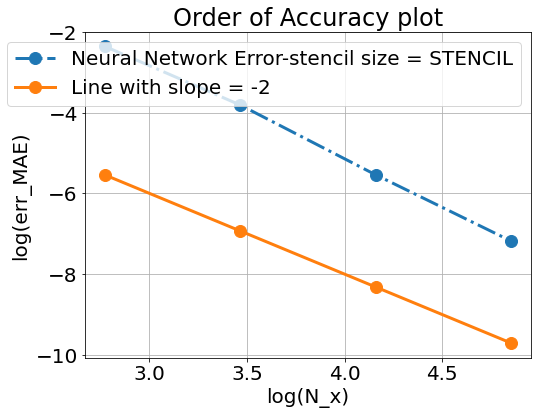

In [ ]:
STENCIL=3
err_ls=[]
ls=np.array([2**i for i in range(4,8)])
for ord in range(4,8):
  numPE=1
  grid_length = 2*np.pi
  resolution = 2**ord
  # 1d domain, so only 1 point along y dimension
  fine_grid = grids.Grid(
      size_x=resolution, size_y=1, 
      step=grid_length/resolution
      )
  x_fine, _ = fine_grid.get_mesh()
  print(x_fine.shape)

  CFL,u0,tend=0.08,1.,15.
  dx=grid_length/len(x_fine)
  dt=dx*CFL/abs(u0)
  N_t=int(tend//dt)
  time_steps=np.arange(N_t)
  initS=[[1],[1],[0]]
  data_ana=solution_data(initS[0],initS[1],initS[2],x_fine[:,0],N_t,dt)
  'Create initial state from data'
  initial_state=create_init_state_from_2d_data(data_ana,u0)

  model_nn = myPseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                      num_time_steps=10,stencil_size=STENCIL, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                      learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
  tf.random.set_random_seed(0)
  'Untrained'
  integrated_UT1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
  plot_time_prop(integrated_UT1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained ')

  ground_soln_dict=ground_dict_from_data(data_ana)
  train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
  'Training'
  model_nn.compile(optimizer='adam', loss='mae')
  history = model_nn.fit(train_input, train_output, epochs=20, batch_size=64, verbose=1, shuffle=True,use_multiprocessing=False,)
  df_history = pd.DataFrame(history.history)
  df_history.plot(marker='.')
  plt.show()

  'Trained'
  integrated_T1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
  plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')

  erAr=integrated_T1['concentration'].numpy().squeeze()[N_t-1]-data_ana[N_t-1]
  err_=np.mean(np.abs(erAr))
  err_ls.append(err_)
err_ls=np.array(err_ls)
OOA(ls,err_ls,2,0,f'Neural Network Error-stencil size = STENCIL')



## Stencil size = 5

(16, 1)
concentration (1, 16, 1)
x_velocity (1, 16, 1)
y_velocity (1, 16, 1)


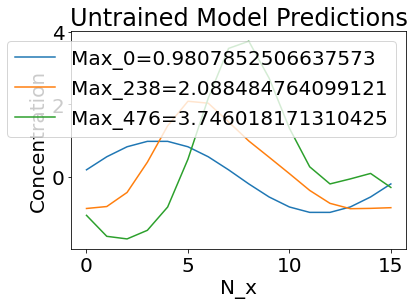

concentration (477, 1, 16, 1)
x_velocity (477, 1, 16, 1)
y_velocity (477, 1, 16, 1)

 train_input shape:
concentration (467, 16, 1)
x_velocity (467, 16, 1)
y_velocity (467, 16, 1)

 train_output shape: (467, 10, 16, 1)
Train on 467 samples
Epoch 1/20
467/467 [==============================] - 5s 12ms/sample - loss: 0.0029
Epoch 2/20
467/467 [==============================] - 1s 2ms/sample - loss: 0.0013
Epoch 3/20
467/467 [==============================] - 1s 2ms/sample - loss: 6.8396e-04
Epoch 4/20
467/467 [==============================] - 1s 2ms/sample - loss: 4.5790e-04
Epoch 5/20
467/467 [==============================] - 1s 2ms/sample - loss: 3.3395e-04
Epoch 6/20
467/467 [==============================] - 1s 2ms/sample - loss: 2.4142e-04
Epoch 7/20
467/467 [==============================] - 1s 2ms/sample - loss: 2.3999e-04
Epoch 8/20
467/467 [==============================] - 1s 2ms/sample - loss: 2.7101e-04
Epoch 9/20
467/467 [==============================] - 1s 2ms/sample - l

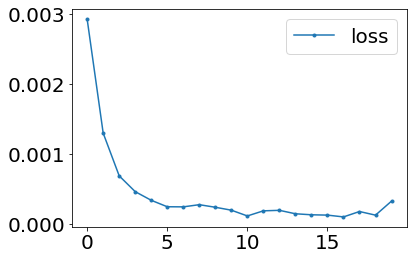

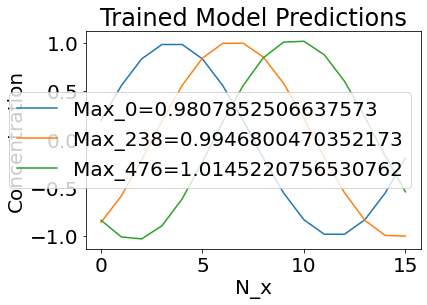

(32, 1)
concentration (1, 32, 1)
x_velocity (1, 32, 1)
y_velocity (1, 32, 1)


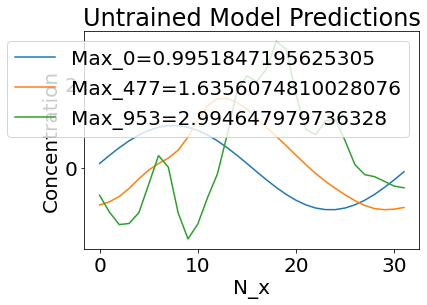

concentration (954, 1, 32, 1)
x_velocity (954, 1, 32, 1)
y_velocity (954, 1, 32, 1)

 train_input shape:
concentration (944, 32, 1)
x_velocity (944, 32, 1)
y_velocity (944, 32, 1)

 train_output shape: (944, 10, 32, 1)
Train on 944 samples
Epoch 1/20
944/944 [==============================] - 8s 8ms/sample - loss: 3.4949e-04
Epoch 2/20
944/944 [==============================] - 4s 4ms/sample - loss: 1.0635e-04
Epoch 3/20
944/944 [==============================] - 4s 4ms/sample - loss: 7.5585e-05
Epoch 4/20
944/944 [==============================] - 4s 4ms/sample - loss: 4.7517e-05
Epoch 5/20
944/944 [==============================] - 4s 4ms/sample - loss: 5.3633e-05
Epoch 6/20
944/944 [==============================] - 4s 4ms/sample - loss: 5.8447e-05
Epoch 7/20
944/944 [==============================] - 4s 4ms/sample - loss: 6.9993e-05
Epoch 8/20
944/944 [==============================] - 4s 4ms/sample - loss: 4.3763e-05
Epoch 9/20
944/944 [==============================] - 3s 4ms/sam

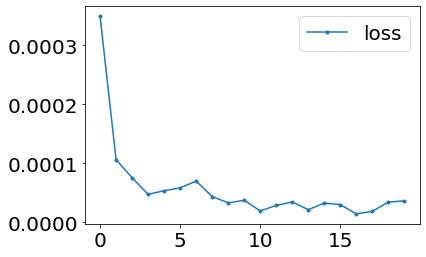

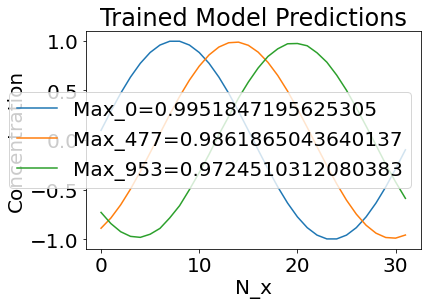

(64, 1)
concentration (1, 64, 1)
x_velocity (1, 64, 1)
y_velocity (1, 64, 1)


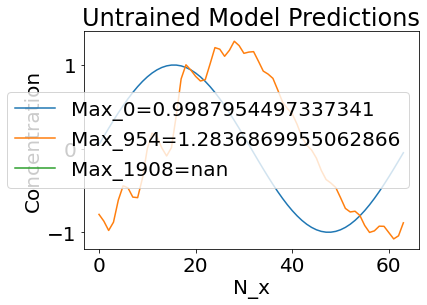

concentration (1909, 1, 64, 1)
x_velocity (1909, 1, 64, 1)
y_velocity (1909, 1, 64, 1)

 train_input shape:
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)

 train_output shape: (1899, 10, 64, 1)
Train on 1899 samples
Epoch 1/20
1899/1899 [==============================] - 15s 8ms/sample - loss: 5.6745e-05
Epoch 2/20
1899/1899 [==============================] - 11s 6ms/sample - loss: 1.7076e-05
Epoch 3/20
1899/1899 [==============================] - 10s 5ms/sample - loss: 1.5887e-05
Epoch 4/20
1899/1899 [==============================] - 11s 6ms/sample - loss: 8.3525e-06
Epoch 5/20
1899/1899 [==============================] - 11s 6ms/sample - loss: 1.1683e-05
Epoch 6/20
1899/1899 [==============================] - 10s 5ms/sample - loss: 7.3306e-06
Epoch 7/20
1899/1899 [==============================] - 10s 5ms/sample - loss: 8.4882e-06
Epoch 8/20
1899/1899 [==============================] - 10s 6ms/sample - loss: 7.1675e-06
Epoch 9/20
1899/1899 [==========

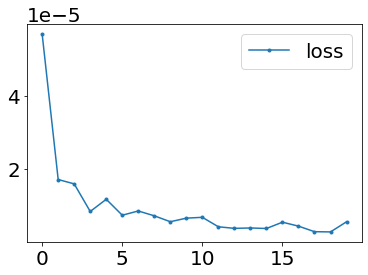

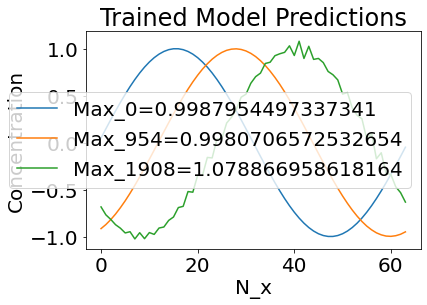

(128, 1)
concentration (1, 128, 1)
x_velocity (1, 128, 1)
y_velocity (1, 128, 1)


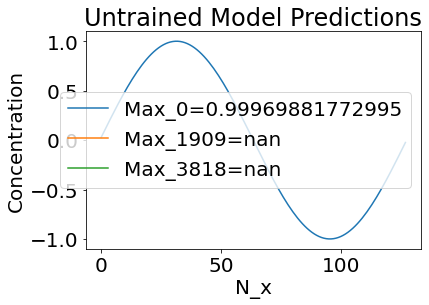

concentration (3819, 1, 128, 1)
x_velocity (3819, 1, 128, 1)
y_velocity (3819, 1, 128, 1)

 train_input shape:
concentration (3809, 128, 1)
x_velocity (3809, 128, 1)
y_velocity (3809, 128, 1)

 train_output shape: (3809, 10, 128, 1)
Train on 3809 samples
Epoch 1/20
3809/3809 [==============================] - 43s 11ms/sample - loss: 8.0964e-06
Epoch 2/20
3809/3809 [==============================] - 38s 10ms/sample - loss: 2.6969e-06
Epoch 3/20
3809/3809 [==============================] - 39s 10ms/sample - loss: 1.9636e-06
Epoch 4/20
3809/3809 [==============================] - 39s 10ms/sample - loss: 1.8381e-06
Epoch 5/20
3809/3809 [==============================] - 38s 10ms/sample - loss: 2.0188e-06
Epoch 6/20
3809/3809 [==============================] - 39s 10ms/sample - loss: 1.2820e-06
Epoch 7/20
3809/3809 [==============================] - 39s 10ms/sample - loss: 1.3222e-06
Epoch 8/20
3809/3809 [==============================] - 39s 10ms/sample - loss: 1.4982e-06
Epoch 9/20
3809/3

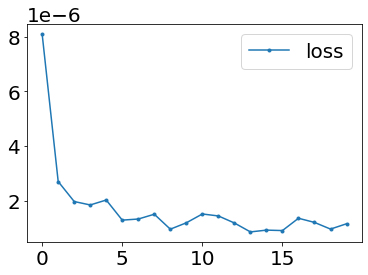

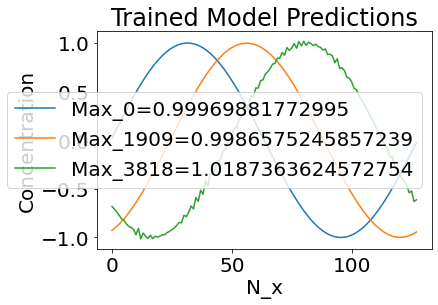

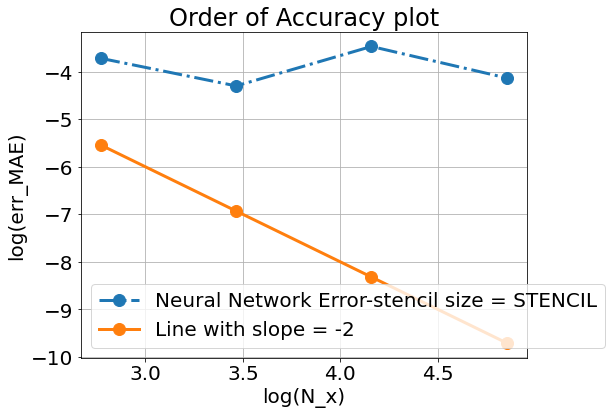

In [ ]:
STENCIL=5
err_ls=[]
ls=np.array([2**i for i in range(4,8)])
for ord in range(4,8):
  numPE=1
  grid_length = 2*np.pi
  resolution = 2**ord
  # 1d domain, so only 1 point along y dimension
  fine_grid = grids.Grid(
      size_x=resolution, size_y=1, 
      step=grid_length/resolution
      )
  x_fine, _ = fine_grid.get_mesh()
  print(x_fine.shape)

  CFL,u0,tend=0.08,1.,15.
  dx=grid_length/len(x_fine)
  dt=dx*CFL/abs(u0)
  N_t=int(tend//dt)
  time_steps=np.arange(N_t)
  initS=[[1],[1],[0]]
  data_ana=solution_data(initS[0],initS[1],initS[2],x_fine[:,0],N_t,dt)
  'Create initial state from data'
  initial_state=create_init_state_from_2d_data(data_ana,u0)

  model_nn = myPseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                      num_time_steps=10,stencil_size=STENCIL, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                      learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
  tf.random.set_random_seed(0)
  'Untrained'
  integrated_UT1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
  plot_time_prop(integrated_UT1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained ')

  ground_soln_dict=ground_dict_from_data(data_ana)
  train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
  'Training'
  model_nn.compile(optimizer='adam', loss='mae')
  history = model_nn.fit(train_input, train_output, epochs=20, batch_size=64, verbose=1, shuffle=True,use_multiprocessing=False,)
  df_history = pd.DataFrame(history.history)
  df_history.plot(marker='.')
  plt.show()

  'Trained'
  integrated_T1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
  plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')

  erAr=integrated_T1['concentration'].numpy().squeeze()[N_t-1]-data_ana[N_t-1]
  err_=np.mean(np.abs(erAr))
  err_ls.append(err_)
err_ls=np.array(err_ls)
OOA(ls,err_ls,2,0,f'Neural Network Error-stencil size = STENCIL')



# Initialize variables

In [ ]:
res=2**6
numPE=1
grid_length = 2*np.pi
fine_grid_resolution = res
# 1d domain, so only 1 point along y dimension
fine_grid = grids.Grid(
    size_x=fine_grid_resolution, size_y=1, 
    step=grid_length/fine_grid_resolution
    )
x_fine, _ = fine_grid.get_mesh()
print(x_fine.shape)

CFL,u0,tend=0.08,1.,15.
dx=grid_length/len(x_fine)
dt=dx*CFL/abs(u0)
N_t=int(tend//dt)
time_steps=np.arange(N_t)
initS=[[1],[1],[0]]
data_ana=solution_data(initS[0],initS[1],initS[2],x_fine[:,0],N_t,dt)
'Create initial state from data'
initial_state=create_init_state_from_2d_data(data_ana,u0)
i0={}
for key,arr in initial_state.items():
  i0[key]=tf.convert_to_tensor(arr)
# model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
#                                     num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
#                                     learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 


(64, 1)
concentration (1, 64, 1)
x_velocity (1, 64, 1)
y_velocity (1, 64, 1)


# Extract2dpatches-Changes

## Importing files

## Class Definitions

### Myfunctf

In [7]:
def periodic_padding_flexible(tensor, axis,padding=1):
    """
        add periodic padding to a tensor for specified axis
        tensor: input tensor
        axis: on or multiple axis to pad along, int or tuple
        padding: number of cells to pad, int or tuple

        return: padded tensor
    """


    if isinstance(axis,int):
        axis = (axis,)
    if isinstance(padding,int):
        padding = (padding,)

    ndim = len(tensor.shape)
    for ax,p in zip(axis,padding):
        # create a slice object that selects everything from all axes,
        # except only 0:p for the specified for right, and -p: for left

        ind_right = [slice(-p,None) if i == ax else slice(None) for i in range(ndim)]
        ind_left = [slice(0, p) if i == ax else slice(None) for i in range(ndim)]
        right = tensor[ind_right]
        left = tensor[ind_left]
        middle = tensor
        tensor = tf.concat([right,middle,left], axis=ax)

    return tensor
    
def my_extract_2d_patches(x,k_size):
  #1,64,1 tensor
  # x1=tf.squeeze(x,0)
  b = tf.constant([1,1,k_size], tf.int32)
  pad_size=k_size//2
  tiled=tf.tile(x,b)
  pad3d=periodic_padding_flexible(tiled, axis=(1),padding=(pad_size))
  pad4d=tf.expand_dims(pad3d,-1)
  t_ext = tf.extract_image_patches(pad4d,[1, k_size, k_size, 1],strides=[1, 1, 1, 1],rates=[1, 1, 1, 1],padding='VALID')
  return t_ext
# def my_extract_2d_patches(x,k_size):
#   #1,64,1 tensor
#   # x1=tf.squeeze(x,0)  
#   pad_size=k_size//2
#   pad3d=periodic_padding_flexible(x, axis=(1,2),padding=(pad_size,pad_size))
#   pad4d=tf.expand_dims(pad3d,-1)
#   t_ext = tf.extract_image_patches(pad4d,[1, k_size, k_size, 1],strides=[1, 1, 1, 1],rates=[1, 1, 1, 1],padding='VALID')
#   return t_ext
'FINAL FN'


In [11]:
x=tf.convert_to_tensor(np.arange(5.).reshape(1,5,1))
my_extract_2d_patches(x,5)
# b = tf.constant([1,1,5], tf.int32)
# y=tf.tile(x,b)
# x1=periodic_padding_flexible(y, axis=(1),padding=(2))
# x1
# x2=periodic_padding_flexible(x1, axis=(1,2),padding=(1,1))
# x2
# tf.stack([],-1)
# tf.repeat(x, repeats, axis=1)

<tf.Tensor: id=47, shape=(1, 5, 1, 25), dtype=float64, numpy=
array([[[[3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 0., 0., 0., 0., 0.,
          1., 1., 1., 1., 1., 2., 2., 2., 2., 2.]],

        [[4., 4., 4., 4., 4., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
          2., 2., 2., 2., 2., 3., 3., 3., 3., 3.]],

        [[0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2.,
          3., 3., 3., 3., 3., 4., 4., 4., 4., 4.]],

        [[1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3.,
          4., 4., 4., 4., 4., 0., 0., 0., 0., 0.]],

        [[2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4.,
          0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]]]])>

In [10]:
# a=x[0]
x

<tf.Tensor: id=16, shape=(1, 5, 1), dtype=float64, numpy=
array([[[0.],
        [1.],
        [2.],
        [3.],
        [4.]]])>

In [ ]:
# pre = tf.constant([[0., 0, 1], [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]])
# post = tf.transpose(pre)
# result = tf.matmul(tf.matmul(pre, a), post)

In [ ]:
def periodic_padding(x, padding=1):
    '''
    x: shape (batch_size, d1, d2)
    return x padded with periodic boundaries. i.e. torus or donut
    '''
    d1 = x.shape[1] # dimension 1: height
    d2 = x.shape[2] # dimension 2: width
    p = padding
    # assemble padded x from slices
    #            tl,tc,tr
    # padded_x = ml,mc,mr
    #            bl,bc,br
    top_left = x[:, -p:, -p:] # top left
    top_center = x[:, -p:, :] # top center
    top_right = x[:, -p:, :p] # top right
    middle_left = x[:, :, -p:] # middle left
    middle_center = x # middle center
    middle_right = x[:, :, :p] # middle right
    bottom_left = x[:, :p, -p:] # bottom left
    bottom_center = x[:, :p, :] # bottom center
    bottom_right = x[:, :p, :p] # bottom right
    top = tf.concat([top_left, top_center, top_right], axis=2)
    middle = tf.concat([middle_left, middle_center, middle_right], axis=2)
    bottom = tf.concat([bottom_left, bottom_center, bottom_right], axis=2)
    padded_x = tf.concat([top, middle, bottom], axis=1)
    return padded_x
periodic_padding(x, padding=2)

<tf.Tensor: id=1516383, shape=(1, 9, 3), dtype=float64, numpy=
array([[[3., 3., 3.],
        [4., 4., 4.],
        [0., 0., 0.],
        [1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [4., 4., 4.],
        [0., 0., 0.],
        [1., 1., 1.]]])>

In [ ]:
periodic_padding_flexible(x, axis=(1,2),padding=(1,2))

<tf.Tensor: id=1516302, shape=(1, 7, 6), dtype=float64, numpy=
array([[[8., 9., 8., 9., 8., 9.],
        [0., 1., 0., 1., 0., 1.],
        [2., 3., 2., 3., 2., 3.],
        [4., 5., 4., 5., 4., 5.],
        [6., 7., 6., 7., 6., 7.],
        [8., 9., 8., 9., 8., 9.],
        [0., 1., 0., 1., 0., 1.]]])>

In [ ]:
my_extract_2d_patches(x,5)

InvalidArgumentError: ignored

In [ ]:
my_extract_2d_patches(x,3)

<tf.Tensor: id=1516119, shape=(1, 5, 1, 9), dtype=float64, numpy=
array([[[[4., 4., 4., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 1., 1., 1., 2., 2., 2.]],

        [[1., 1., 1., 2., 2., 2., 3., 3., 3.]],

        [[2., 2., 2., 3., 3., 3., 4., 4., 4.]],

        [[3., 3., 3., 4., 4., 4., 0., 0., 0.]]]])>

In [ ]:
periodic_padding_flexible(x, axis=(1,2),padding=(2,2))
tf.expand_dims(periodic_padding_flexible(x, axis=(1,2),padding=(2,2)),-1)

<tf.Tensor: id=1515726, shape=(1, 9, 3, 1), dtype=float64, numpy=
array([[[[3.],
         [3.],
         [3.]],

        [[4.],
         [4.],
         [4.]],

        [[0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.]],

        [[2.],
         [2.],
         [2.]],

        [[3.],
         [3.],
         [3.]],

        [[4.],
         [4.],
         [4.]],

        [[0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.]]]])>

In [ ]:
# tf.image.extract_patches(
#     images, sizes, strides, rates, padding, name=None
# )

In [ ]:
my_extract_2d_patches(x,3)

<tf.Tensor: id=1515750, shape=(1, 5, 1, 9), dtype=float64, numpy=
array([[[[4., 4., 4., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 1., 1., 1., 2., 2., 2.]],

        [[1., 1., 1., 2., 2., 2., 3., 3., 3.]],

        [[2., 2., 2., 3., 3., 3., 4., 4., 4.]],

        [[3., 3., 3., 4., 4., 4., 0., 0., 0.]]]])>

In [ ]:
# def dummmy_pad(x,pad_size):
#   # pad_size=pad_size_np[0]
#   return np.pad(x, (pad_size, pad_size), 'wrap').astype(np.float32)
  
# X=tf.ones([64,1])
# n=tf.constant(1)
# tffunc=tf.py_func(dummmy_pad,[X,n], [tf.float32], name='padded')

# def my_extract_2d_patches(x,k_size):
#   #1,64,1 tensor
#   # x1=tf.squeeze(x,0)  
#   pad_size=tf.constant(k_size//2)
#   pad2d=tf.py_func(dummmy_pad,[x[0],pad_size], [tf.float32,tf.float32], name='padded')[:]
#   p1=tf.expand_dims(pad2d,0)
#   pad4d=tf.expand_dims(p1,-1)
#   # pad4d=pad2d[tf.newaxis,:,:,tf.newaxis]
#   t_ext = tf.extract_image_patches(pad4d,[1, k_size, k_size, 1],strides=[1, 1, 1, 1],rates=[1, 1, 1, 1],padding='VALID')
#   return t_ext



In [ ]:

type(tf.newaxis)

NoneType

In [ ]:
tffunc[tf.newaxis,:,:,tf.newaxis].shape

TensorShape([Dimension(1), Dimension(7), Dimension(3), Dimension(1)])

In [ ]:
X=tf.convert_to_tensor(np.arange(5).reshape(5,1))
n=tf.constant(1)
tffunc=tf.py_func(dummmy_pad,[X,n], [tf.float32,tf.float32], name='padded')[:]

In [ ]:
tffunc.shape

TensorShape([Dimension(7), Dimension(3)])

<tf.Tensor: id=1508025, shape=(1, 5, 1), dtype=int64, numpy=
array([[[0],
        [1],
        [2],
        [3],
        [4]]])>

In [ ]:
tf.expand_dims(tf.expand_dims(tffunc,0),-1).shape

TensorShape([Dimension(1), Dimension(7), Dimension(3), Dimension(1)])

In [ ]:
tf.extract_image_patches(tffunc[tf.newaxis,:,:,tf.newaxis],[1, 3, 3, 1],strides=[1, 1, 1, 1],rates=[1, 1, 1, 1],padding='VALID')

<tf.Tensor: id=1508034, shape=(1, 5, 1, 9), dtype=float32, numpy=
array([[[[4., 4., 4., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 1., 1., 1., 2., 2., 2.]],

        [[1., 1., 1., 2., 2., 2., 3., 3., 3.]],

        [[2., 2., 2., 3., 3., 3., 4., 4., 4.]],

        [[3., 3., 3., 4., 4., 4., 0., 0., 0.]]]], dtype=float32)>

In [ ]:
my_extract_2d_patches(x,3)

<tf.Tensor: id=1508049, shape=(1, 5, 1, 9), dtype=float32, numpy=
array([[[[4., 4., 4., 0., 0., 0., 1., 1., 1.]],

        [[0., 0., 0., 1., 1., 1., 2., 2., 2.]],

        [[1., 1., 1., 2., 2., 2., 3., 3., 3.]],

        [[2., 2., 2., 3., 3., 3., 4., 4., 4.]],

        [[3., 3., 3., 4., 4., 4., 0., 0., 0.]]]], dtype=float32)>

### Modelclasses

In [ ]:
nest = tf.contrib.framework.nest


T = TypeVar('T')


def sorted_values(x: Dict[Any, T]) -> List[T]:
  """Returns the sorted values of a dictionary."""
  return [x[k] for k in sorted(x)]


def stack_dict(state: Dict[Any, tf.Tensor]) -> tf.Tensor:
  """Stack a dict of tensors along its last axis."""
  return tf.stack(sorted_values(state), axis=-1)


class TimeStepModel(tf.keras.Model):
  """Model that predicts the state at the next time-step."""

  def __init__(
      self,
      equation: equations.Equation,
      grid: grids.Grid,
      num_time_steps: int = 1,
      target: Optional[str] = None,
      name: str = 'time_step_model',
  ):
    """Initialize a time-step model."""
    super().__init__(name=name)

    if num_time_steps < 1:
      raise ValueError('must use at least one time step')

    self.equation = equation
    self.grid = grid
    self.num_time_steps = num_time_steps

    if target is None and len(equation.evolving_keys) == 1:
      (target,) = equation.evolving_keys
    self.target = target

  def load_data(
      self,
      metadata: Mapping[str, Any],
      prefix: states.Prefix = states.Prefix.EXACT,
  ) -> tf.data.Dataset:
    """Load data into a tf.data.Dataset for inferrence or training."""

    def replace_state_keys_with_names(state):
      return {k: state[equation.key_definitions[k].with_prefix(prefix)]
              for k in equation.base_keys}

    equation = readers.get_equation(metadata)
    grid = readers.get_output_grid(metadata)
    keys = [equation.key_definitions[k].with_prefix(prefix)
            for k in equation.base_keys]
    dataset = readers.initialize_dataset(metadata, [keys], [grid])
    dataset = dataset.map(replace_state_keys_with_names)
    return dataset

  def call(self, inputs: Dict[str, tf.Tensor]) -> tf.Tensor:
    """Predict the target state after multiple time-steps.
    Args:
      inputs: dict of tensors with dimensions [batch, x, y].
    Returns:
      labels: tensor with dimensions [batch, time, x, y], giving the target
        value of the predicted state at steps [1, ..., self.num_time_steps]
        for model training.
    """
    constant_state = {k: v for k, v in inputs.items()
                      if k in self.equation.constant_keys}
    evolving_inputs = {k: v for k, v in inputs.items()
                       if k in self.equation.evolving_keys}

    def advance(evolving_state, _):
      return self.take_time_step({**evolving_state, **constant_state})

    advanced = tf.scan(
        advance, tf.range(self.num_time_steps), initializer=evolving_inputs)
    advanced = tensor_ops.moveaxis(advanced, source=0, destination=1)
    # TODO(shoyer): support multiple targets, once keras does.
    # https://github.com/tensorflow/tensorflow/issues/25299
    return advanced[self.target]

  def time_derivative(
      self, state: Mapping[str, tf.Tensor]) -> Dict[str, tf.Tensor]:
    """Compute the time derivative.
    Args:
      state: current state of the solution.
    Returns:
      Updated values for each non-constant term in the state.
    """
    raise NotImplementedError

  def take_time_step(
      self, state: Mapping[str, tf.Tensor]) -> Dict[str, tf.Tensor]:
    """Take a single time-step.
    Args:
      state: current state of the solution.
    Returns:
      Updated values for each non-constant term in the state.
    """
    raise NotImplementedError

  def to_config(self) -> Mapping[str, Any]:
    """Create a configuration dict for this model. Not possible for all models.
    """
    raise NotImplementedError


class SpatialDerivativeModel(TimeStepModel):
  """Model that predicts the next time-step implicitly via spatial derivatives.
  """

  def __init__(self, equation, grid, num_time_steps=1, target=None,
               name='spatial_derivative_model'):
    super().__init__(equation, grid, num_time_steps, target, name)

  def spatial_derivatives(
      self, state: Mapping[str, tf.Tensor]) -> Dict[str, tf.Tensor]:
    """Predict all needed spatial derivatives."""
    raise NotImplementedError

  def time_derivative(
      self, state: Mapping[str, tf.Tensor]) -> Dict[str, tf.Tensor]:
    """See base class."""
    inputs = self.spatial_derivatives(state)
    outputs = self.equation.time_derivative(self.grid, **inputs)
    return outputs

  def take_time_step(
      self, state: Mapping[str, tf.Tensor]) -> Dict[str, tf.Tensor]:
    """See base class."""
    inputs = self.spatial_derivatives(state)
    outputs = self.equation.take_time_step(self.grid, **inputs)
    return outputs


class FiniteDifferenceModel(SpatialDerivativeModel):
  """Baseline model with fixed order finite-differences or finite-volumes.
  This model doesn't need to be trained.
  """

  def __init__(
      self, equation, grid, accuracy_order=1, num_time_steps=1, target=None,
      name='finite_difference_model',
  ):
    super().__init__(equation, grid, num_time_steps, target, name)

    self.accuracy_order = accuracy_order
    self.parents = {}  # type: Dict[str, str]
    self.coefficients = {}  # type: Dict[str, Optional[np.ndarray]]
    self.stencils = {}  # type: Dict[str, List[np.ndarray]]

    for key in self.equation.all_keys:
      parent = equation.find_base_key(key)

      key_def = equation.key_definitions[key]
      parent_def = equation.key_definitions[parent]

      stencils = []
      for parent_offset, argument_offset, derivative_order in zip(
          parent_def.offset, key_def.offset, key_def.derivative_orders):
        stencil = polynomials.regular_stencil_1d(
            abs(parent_offset - argument_offset),
            derivative_order,
            accuracy_order,
            grid.step)
        stencils.append(stencil)

      if all(stencil.size == 1 for stencil in stencils):
        # sentinel value indicating that we should just reuse the parent tensor
        # rather than extracting patches and applying coefficients
        coefficients = None
      else:
        coefficients_2d = polynomials.coefficients(
            stencils, equation.METHOD, key_def.derivative_orders,
            accuracy_order, grid.step)
        coefficients = tf.convert_to_tensor(coefficients_2d.ravel(), tf.float32)

      self.parents[key] = parent
      self.stencils[key] = stencils
      self.coefficients[key] = coefficients

  def spatial_derivatives(
      self, inputs: Mapping[str, tf.Tensor], request: Set[str] = None,
  ) -> Dict[str, tf.Tensor]:
    """See base class."""
    if request is None:
      request = self.equation.all_keys

    result = {}
    for key in request:
      coefficients = self.coefficients[key]

      source = inputs[self.parents[key]]
      if coefficients is None:
        result[key] = source
      else:
        sizes = [stencil.size for stencil in self.stencils[key]]

        key_def = self.equation.key_definitions[key]
        parent_def = self.equation.key_definitions[self.parents[key]]
        shifts = [k - p for p, k in zip(parent_def.offset, key_def.offset)]

        patches = tensor_ops.extract_patches_2d(source, sizes, shifts)
        result[key] = tf.tensordot(coefficients, patches, axes=[-1, -1])
        assert result[key].shape[-2:] == source.shape[-2:], (
            result[key], source)

    return result

  def to_config(self) -> Mapping[str, Any]:
    return dict(accuracy_order=self.accuracy_order)


def _round_down_to_odd(x):
  return x if x % 2 else x - 1


def _round_down_to_even(x):
  return x - 1 if x % 2 else x


def build_stencils(
    key: states.StateDefinition,
    parent: states.StateDefinition,
    max_stencil_size: int,
    grid_step: float
) -> List[np.ndarray]:
  """Create stencils for use with learned coefficients."""
  stencils = []

  for parent_offset, key_offset in zip(parent.offset, key.offset):

    if parent_offset == key_offset:
      size = _round_down_to_odd(max_stencil_size)
    else:
      size = _round_down_to_even(max_stencil_size)

    # examples:
    # stencil_size=5 -> [-2, -1, 0, 1, 2]
    # stencil_size=4 -> [-2, -1, 0, 1]
    int_range = np.arange(size) - size // 2

    stencil = grid_step * (0.5 * abs(key_offset - parent_offset) + int_range)

    stencils.append(stencil)

  # we should only be using zero-centered stencils
  if not all(np.allclose(stencil.sum(), 0) for stencil in stencils):
    raise ValueError('stencils are not zero-centered for {} -> {}: {}'
                     .format(parent, key, stencils))

  return stencils


ConstraintLayer = Union[
    polynomials.PolynomialAccuracy, polynomials.PolynomialBias]


class FixedCoefficientsLayer(tf.keras.layers.Layer):
  """Layer representing fixed learned coefficients for a single derivative."""

  def __init__(
      self,
      constraint_layer: ConstraintLayer,
      stencils: List[np.ndarray],
      shifts: List[int],
      input_key: Optional[str] = None,
  ):
    self.constraint_layer = constraint_layer
    self.stencils = stencils
    self.shifts = shifts
    self.input_key = input_key
    super().__init__()

  def build(self, input_shape):
    shape = [self.constraint_layer.input_size]
    self.kernel = self.add_weight('kernel', shape=shape)

  def compute_output_shape(self, input_shape):
    return input_shape[:-1]

  def call(self, inputs):
    coefficients = self.constraint_layer(self.kernel)
    sizes = [stencil.size for stencil in self.stencils]
    patches = tensor_ops.extract_patches_2d(inputs, sizes, self.shifts)
    return tf.einsum('s,bxys->bxy', coefficients, patches)


class VaryingCoefficientsLayer(tf.keras.layers.Layer):
  """Layer representing varying coefficients for a single derivative."""

  def __init__(
      self,
      constraint_layer: ConstraintLayer,
      stencils: List[np.ndarray],
      shifts: List[int],
      input_key: Optional[str] = None,
  ):
    self.constraint_layer = constraint_layer
    self.stencils = stencils
    self.shifts = shifts
    self.input_key = input_key
    self.kernel_size = constraint_layer.input_size
    super().__init__(trainable=False)

  def compute_output_shape(self, input_shape):
    return input_shape[:-1]

  def call(self, inputs):
    (kernel, source) = inputs
    coefficients = self.constraint_layer(kernel)
    sizes = [stencil.size for stencil in self.stencils]
    patches=my_extract_2d_patches(source,sizes[0])
    # patches = tensor_ops.extract_patches_2d(source, sizes, self.shifts)
    return tf.einsum('bxys,bxys->bxy', coefficients, patches)


def normalize_learned_and_fixed_keys(
    learned_keys: Optional[Set[str]],
    fixed_keys: Optional[Set[str]],
    equation: equations.Equation,
) -> Tuple[Set[str], Set[str]]:
  """Normalize learned and fixed equation inputs."""
  if learned_keys is None and fixed_keys is None:
    fixed_keys = equation.base_keys
    learned_keys = equation.derived_keys

  elif fixed_keys is None:
    learned_keys = set(learned_keys)
    fixed_keys = equation.all_keys - learned_keys

  elif learned_keys is None:
    fixed_keys = set(fixed_keys)
    learned_keys = equation.all_keys - fixed_keys

  else:
    learned_keys = set(learned_keys)
    fixed_keys = set(fixed_keys)

    if learned_keys.intersection(fixed_keys):
      raise ValueError('learned and fixed inputs must be disjoint sets: '
                       '{} vs {}'.format(learned_keys, fixed_keys))

    missing_inputs = equation.all_keys - learned_keys - fixed_keys
    if missing_inputs:
      raise ValueError(
          'inputs {} not inclued in learned or fixed inputs: {} vs {}'
          .format(missing_inputs, learned_keys, fixed_keys))

  return learned_keys, fixed_keys


def build_output_layers(
    equation, grid, learned_keys,
    stencil_size=5,
    initial_accuracy_order=1,
    constrained_accuracy_order=1,
    layer_cls=FixedCoefficientsLayer,
    predict_permutations=True,
) -> Dict[str, ConstraintLayer]:
  """Build a map of output layers for spatial derivative models."""
  layers = {}
  modeled = set()

  # learned_keys is a set; it can change iteration order per python session
  # need to fix its iteration order to correctly save/load Keras models
  for key in sorted(learned_keys):
    if (not predict_permutations
        and equation.key_definitions[key].swap_xy() in modeled):
      # NOTE(shoyer): this only makes sense if geometric_transforms includes
      # permutations. Otherwise you won't be predicting every needed tensor.
      continue

    parent = equation.find_base_key(key)
    key_def = equation.key_definitions[key]
    modeled.add(key_def)
    parent_def = equation.key_definitions[parent]

    stencils = build_stencils(key_def, parent_def, stencil_size, grid.step)
    shifts = [k - p for p, k in zip(parent_def.offset, key_def.offset)]
    constraint_layer = polynomials.constraint_layer(
        stencils, equation.METHOD, key_def.derivative_orders[:2],
        constrained_accuracy_order, initial_accuracy_order, grid.step,
    )
    layers[key] = layer_cls(
        constraint_layer, stencils, shifts, input_key=parent)

  return layers


def average_over_transforms(func, geometric_transforms, state):
  """Average a function over transformations to achive rotation invariance."""
  result_list = collections.defaultdict(list)

  for transform in geometric_transforms:
    output = transform.inverse(func(transform.forward(state)))
    for k, v in output.items():
      result_list[k].append(v)

  result = {k: tf.add_n(v) / len(v) if len(v) > 1 else v[0]
            for k, v in result_list.items()}
  return result


class LinearModel(SpatialDerivativeModel):
  """Learn constant linear filters for spatial derivatives."""

  def __init__(self, equation, grid, stencil_size=5, initial_accuracy_order=1,
               constrained_accuracy_order=1, learned_keys=None,
               fixed_keys=None, num_time_steps=1, target=None,
               geometric_transforms=None, predict_permutations=True,
               name='linear_model'):
    super().__init__(equation, grid, num_time_steps, target, name)
    self.learned_keys, self.fixed_keys = (
        normalize_learned_and_fixed_keys(learned_keys, fixed_keys, equation))
    self.output_layers = build_output_layers(
        equation, grid, self.learned_keys, stencil_size, initial_accuracy_order,
        constrained_accuracy_order, layer_cls=FixedCoefficientsLayer,
        predict_permutations=predict_permutations)
    self.fd_model = FiniteDifferenceModel(
        equation, grid, initial_accuracy_order)
    self.geometric_transforms = geometric_transforms or [geometry.Identity()]

  def _apply_model(self, state):
    result = {}
    for key, layer in self.output_layers.items():
      input_tensor = state[layer.input_key]
      layer = self.output_layers[key]
      result[key] = layer(input_tensor)
    return result

  def spatial_derivatives(self, inputs):
    """See base class."""
    result = average_over_transforms(
        self._apply_model, self.geometric_transforms, inputs
    )

    if self.fixed_keys:
      result.update(
          self.fd_model.spatial_derivatives(inputs, self.fixed_keys)
      )
    return result


class Conv2DPeriodic(tf.keras.layers.Layer):
  """Conv2D layer with periodic boundary conditions."""

  def __init__(self, filters, kernel_size, **kwargs):
    # Let Conv2D handle argument normalization, e.g., kernel_size -> tuple
    self._layer = tf.keras.layers.Conv2D(
        filters, kernel_size, padding='valid', **kwargs)
    self.filters = self._layer.filters
    self.kernel_size = self._layer.kernel_size

    if any(size % 2 == 0 for size in self.kernel_size):
      raise ValueError('kernel size for conv2d is not odd: {}'
                       .format(self.kernel_size))

    super().__init__()

  def build(self, input_shape):
    self._layer.build(input_shape)
    super().build(input_shape)

  def compute_output_shape(self, input_shape):
    return input_shape[:-1] + (self.filters,)

  def call(self, inputs):
    padded = tensor_ops.pad_periodic_2d(inputs, self.kernel_size)
    result = self._layer(padded)
    assert result.shape[1:3] == inputs.shape[1:3], (result, inputs)
    return result


def conv2d_stack(num_outputs, num_layers=5, filters=32, kernel_size=5,
                 activation='relu', **kwargs):
  """Create a sequence of Conv2DPeriodic layers."""
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Lambda(stack_dict))
  for _ in range(num_layers - 1):
    layer = Conv2DPeriodic(
        filters, kernel_size, activation=activation, **kwargs)
    model.add(layer)
  model.add(Conv2DPeriodic(num_outputs, kernel_size, **kwargs))
  return model


def _rescale_01(array, axis):
  array_max = tf.reduce_max(array, axis, keep_dims=True)
  array_min = tf.reduce_min(array, axis, keep_dims=True)
  return (array - array_min) / (array_max - array_min)


class RescaledConv2DStack(tf.keras.Model):
  """Rescale input fields to stabilize PDE integration."""

  def __init__(self, num_outputs: int, scaled_keys: Set[str], **kwargs):
    super().__init__()
    self.original_model = conv2d_stack(num_outputs, **kwargs)
    self.scaled_keys = scaled_keys

  def call(self, inputs):
    inputs = inputs.copy()
    for key in self.scaled_keys:
      inputs[key] = _rescale_01(inputs[key], axis=(-1, -2))

    return self.original_model(inputs)


class ClippedConv2DStack(tf.keras.Model):
  """Clip input fields to stabilize PDE integration."""

  def __init__(self, num_outputs: int, scaled_keys: Set[str], **kwargs):
    super().__init__()
    self.original_model = conv2d_stack(num_outputs, **kwargs)
    self.scaled_keys = scaled_keys

  def call(self, inputs):
    inputs = inputs.copy()
    for key in self.scaled_keys:
      inputs[key] = tf.clip_by_value(inputs[key], 1e-3, 1.0 - 1e-3)

    return self.original_model(inputs)



### Pseudo-model-class

In [ ]:

class myPseudoLinearModel(SpatialDerivativeModel):
  """Learn pseudo-linear filters for spatial derivatives."""

  def __init__(self, equation, grid, stencil_size=5, initial_accuracy_order=1,
               constrained_accuracy_order=1, learned_keys=None,
               fixed_keys=None, core_model_func=conv2d_stack,
               num_time_steps=1, geometric_transforms=None,
               predict_permutations=True, target=None,
               name='pseudo_linear_model', **kwargs):
    # NOTE(jiaweizhuang): Too many input arguments. Only document important or
    # confusing ones for now.
    # pylint: disable=g-doc-args
    """Initialize class.
    Args:
      core_model_func: callable (function or class object). It should return
        a Keras model (or layer) instance, which contains trainable weights.
        The returned core_model instance should take a dict of tensors as input
        (see the call() method in the base TimeStepModel class).
        Additional kwargs are passed to this callable to specify hyperparameters
        of core_model (such as number of layers and convolutional filters).
    """
    # pylint: enable=g-doc-args

    super().__init__(equation, grid, num_time_steps, target, name)

    self.learned_keys, self.fixed_keys = (
        normalize_learned_and_fixed_keys(learned_keys, fixed_keys, equation))
    self.output_layers = build_output_layers(
        equation, grid, self.learned_keys, stencil_size, initial_accuracy_order,
        constrained_accuracy_order, layer_cls=VaryingCoefficientsLayer,
        predict_permutations=predict_permutations)
    self.fd_model = FiniteDifferenceModel(
        equation, grid, initial_accuracy_order)
    self.geometric_transforms = geometric_transforms or [geometry.Identity()]
  
    num_outputs = sum(
        layer.kernel_size for layer in self.output_layers.values()
    )
    self.core_model = core_model_func(num_outputs, **kwargs)

  def _apply_model(self, state):
    net = self.core_model(state)

    size_splits = [
        self.output_layers[key].kernel_size for key in self.output_layers
    ]
    heads = tf.split(net, size_splits, axis=-1)

    result = {}
    for (key, layer), head in zip(self.output_layers.items(), heads):
      input_tensor = state[layer.input_key]
      result[key] = layer([head, input_tensor])
    return result

  def spatial_derivatives(self, inputs):
    """See base class."""
    result = average_over_transforms(
        self._apply_model, self.geometric_transforms, inputs
    )
    if self.fixed_keys:
      result.update(
          self.fd_model.spatial_derivatives(inputs, self.fixed_keys)
      )
    return result

class NonlinearModel(SpatialDerivativeModel):
  """Learn spatial derivatives directly."""

  def __init__(self, equation, grid, core_model_func=conv2d_stack,
               learned_keys=None, fixed_keys=None, num_time_steps=1,
               finite_diff_accuracy_order=1, target=None,
               name='nonlinear_model', **kwargs):
    super().__init__(equation, grid, num_time_steps, target, name)
    self.learned_keys, self.fixed_keys = (
        normalize_learned_and_fixed_keys(learned_keys, fixed_keys, equation))
    self.core_model = core_model_func(
        num_outputs=len(self.learned_keys), **kwargs)
    self.fd_model = FiniteDifferenceModel(
        equation, grid, finite_diff_accuracy_order)

  def spatial_derivatives(
      self, inputs: Mapping[str, tf.Tensor],
  ) -> Dict[str, tf.Tensor]:
    """See base class."""
    net = self.core_model(inputs)
    heads = tf.unstack(net, axis=-1)
    result = dict(zip(self.learned_keys, heads))

    if self.fixed_keys:
      result.update(
          self.fd_model.spatial_derivatives(inputs, self.fixed_keys)
      )
    return result


class DirectModel(TimeStepModel):
  """Learn time-evolution directly, ignoring the equation."""

  def __init__(self, equation, grid, core_model_func=conv2d_stack,
               num_time_steps=1, finite_diff_accuracy_order=1, target=None,
               name='direct_model', **kwargs):
    super().__init__(equation, grid, num_time_steps, target, name)
    self.keys = equation.evolving_keys
    self.core_model = core_model_func(num_outputs=len(self.keys), **kwargs)

  def take_time_step(self, inputs):
    """See base class."""
    net = self.core_model(inputs)
    heads = tf.unstack(net, axis=-1)
    return dict(zip(self.keys, heads))

# Model_nn

## Run model_nn-Stencil=3

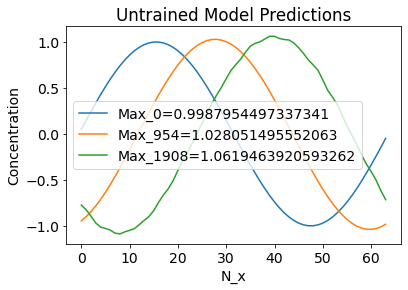

concentration (1909, 1, 64, 1)
x_velocity (1909, 1, 64, 1)
y_velocity (1909, 1, 64, 1)

 train_input shape:
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)

 train_output shape: (1899, 10, 64, 1)


In [ ]:
# model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
#                                     num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
#                                     learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 

model_nn = myPseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                    num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
tf.random.set_random_seed(0)
'Untrained'
integrated_UT1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
plot_time_prop(integrated_UT1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained ')

ground_soln_dict=ground_dict_from_data(data_ana)
train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
'Training'
model_nn.compile(optimizer='adam', loss='mae')



In [ ]:
history = model_nn.fit(train_input, train_output, epochs=20, batch_size=64, verbose=1, shuffle=True,use_multiprocessing=False,)


Train on 1899 samples
Epoch 1/20
1899/1899 [==============================] - 11s 6ms/sample - loss: 4.2101e-05
Epoch 2/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 1.9080e-05
Epoch 3/20
1899/1899 [==============================] - 12s 6ms/sample - loss: 1.4867e-05
Epoch 4/20
1899/1899 [==============================] - 12s 6ms/sample - loss: 1.2083e-05
Epoch 5/20
1899/1899 [==============================] - 11s 6ms/sample - loss: 1.1859e-05
Epoch 6/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 1.1451e-05
Epoch 7/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 1.1262e-05
Epoch 8/20
1899/1899 [==============================] - 9s 5ms/sample - loss: 9.3082e-06
Epoch 9/20
1899/1899 [==============================] - 9s 5ms/sample - loss: 9.4118e-06
Epoch 10/20
1899/1899 [==============================] - 14s 8ms/sample - loss: 1.2391e-05
Epoch 11/20
1899/1899 [==============================] - 12s 6ms/sample - loss: 8.

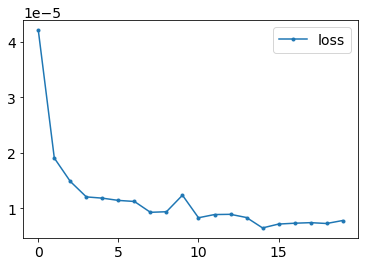

In [ ]:

df_history = pd.DataFrame(history.history)
df_history.plot(marker='.')
plt.show()

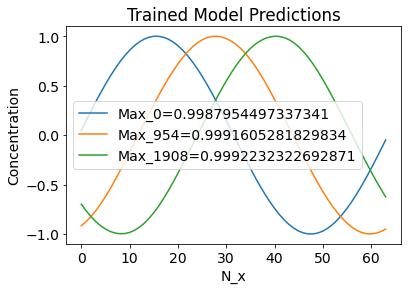

In [ ]:
'Trained'
integrated_T1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')


## Run model_nn-Stencil=5

In [ ]:
# model_nn(initial_state)

In [ ]:
# model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
#                                     num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,

#                                     learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 

model_nn = myPseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                    num_time_steps=10,stencil_size=5, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
tf.random.set_random_seed(0)
'Untrained'
# integrated_UT1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
# plot_time_prop(integrated_UT1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained ')

ground_soln_dict=ground_dict_from_data(data_ana)
train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
'Training'
model_nn.compile(optimizer='adam', loss='mae')


concentration (1909, 1, 64, 1)
x_velocity (1909, 1, 64, 1)
y_velocity (1909, 1, 64, 1)

 train_input shape:
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)

 train_output shape: (1899, 10, 64, 1)


In [ ]:
model_nn(initial_state).shape

TensorShape([Dimension(1), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
history = model_nn.fit(train_input, train_output, epochs=20, batch_size=64, verbose=1, shuffle=True)

Train on 1899 samples
Epoch 1/20
1899/1899 [==============================] - 17s 9ms/sample - loss: 5.7599e-05
Epoch 2/20
1899/1899 [==============================] - 11s 6ms/sample - loss: 2.1267e-05
Epoch 3/20
1899/1899 [==============================] - 12s 6ms/sample - loss: 1.0573e-05
Epoch 4/20
1899/1899 [==============================] - 11s 6ms/sample - loss: 1.2422e-05
Epoch 5/20
1899/1899 [==============================] - 11s 6ms/sample - loss: 1.2219e-05
Epoch 6/20
1899/1899 [==============================] - 11s 6ms/sample - loss: 6.5726e-06
Epoch 7/20
1899/1899 [==============================] - 11s 6ms/sample - loss: 8.3079e-06
Epoch 8/20
1899/1899 [==============================] - 11s 6ms/sample - loss: 7.9910e-06
Epoch 9/20
1899/1899 [==============================] - 11s 6ms/sample - loss: 4.2639e-06
Epoch 10/20
1899/1899 [==============================] - 12s 6ms/sample - loss: 6.4573e-06
Epoch 11/20
1899/1899 [==============================] - 12s 6ms/sample - los

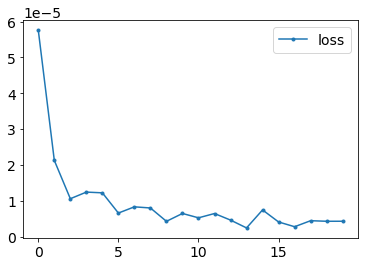

In [ ]:

df_history = pd.DataFrame(history.history)
df_history.plot(marker='.')
plt.show()

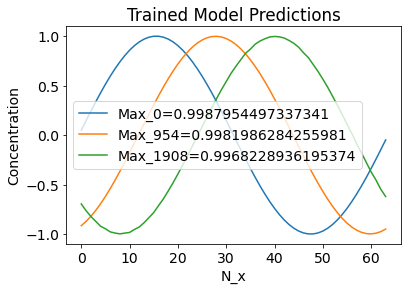

In [ ]:
'Trained'
integrated_T1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')


## Run model_nn-Stencil=5

In [ ]:
# model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
#                                     num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
#                                     learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 

model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                    num_time_steps=10,stencil_size=5, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
tf.random.set_random_seed(0)
'Untrained'
integrated_UT1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
plot_time_prop(integrated_UT1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained ')


InvalidArgumentError: ignored

concentration (1909, 1, 64, 1)
x_velocity (1909, 1, 64, 1)
y_velocity (1909, 1, 64, 1)

 train_input shape:
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)

 train_output shape: (1899, 10, 64, 1)
Train on 1899 samples
Epoch 1/20
1899/1899 [==============================] - 11s 6ms/sample - loss: 4.1901e-05
Epoch 2/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 2.0816e-05
Epoch 3/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 1.6579e-05
Epoch 4/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 1.2469e-05
Epoch 5/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 1.2106e-05
Epoch 6/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 1.1256e-05
Epoch 7/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 1.2602e-05
Epoch 8/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 1.2055e-05
Epoch 9/20
1899/1899 [=================

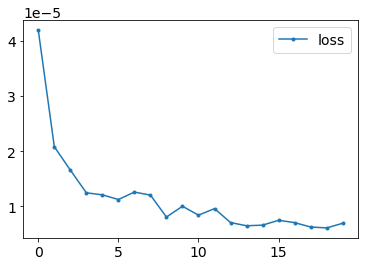

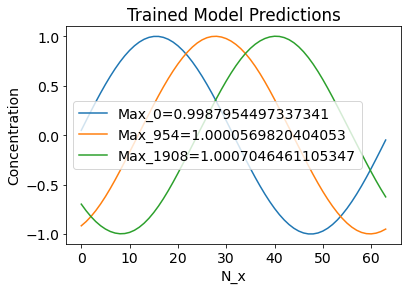

In [ ]:

'Training'
ground_soln_dict=ground_dict_from_data(data_ana)
train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
# train_output.shape
model_nn.compile(optimizer='adam', loss='mae')
history = model_nn.fit(train_input, train_output, epochs=20, batch_size=64, verbose=1, shuffle=True)
df_history = pd.DataFrame(history.history)
df_history.plot(marker='.')
plt.show()

'Trained'
integrated_T1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')


## Run model_nn-Stencil=5 kernel =5

In [ ]:
# model_nn(initial_state)

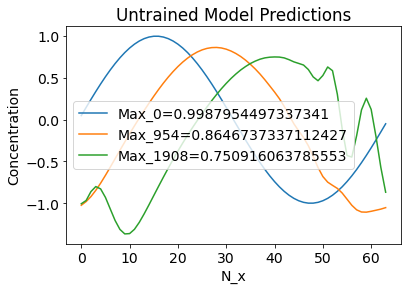

concentration (1909, 1, 64, 1)
x_velocity (1909, 1, 64, 1)
y_velocity (1909, 1, 64, 1)

 train_input shape:
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)

 train_output shape: (1899, 10, 64, 1)


In [ ]:
# model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
#                                     num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,

#                                     learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 

model_nn = myPseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                    num_time_steps=10,stencil_size=5, kernel_size=(5,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
tf.random.set_random_seed(0)
'Untrained'
integrated_UT1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
plot_time_prop(integrated_UT1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained ')

ground_soln_dict=ground_dict_from_data(data_ana)
train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
'Training'
model_nn.compile(optimizer='adam', loss='mae')


In [ ]:
model_nn(initial_state).shape

TensorShape([Dimension(1), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
history = model_nn.fit(train_input, train_output, epochs=20, batch_size=64, verbose=1, shuffle=True)

Train on 1899 samples
Epoch 1/20
1899/1899 [==============================] - 20s 11ms/sample - loss: 5.4054e-05
Epoch 2/20
1899/1899 [==============================] - 14s 8ms/sample - loss: 1.9030e-05
Epoch 3/20
1899/1899 [==============================] - 16s 9ms/sample - loss: 9.0531e-06
Epoch 4/20
1899/1899 [==============================] - 15s 8ms/sample - loss: 7.8788e-06
Epoch 5/20
1899/1899 [==============================] - 15s 8ms/sample - loss: 8.7958e-06
Epoch 6/20
1899/1899 [==============================] - 17s 9ms/sample - loss: 8.7315e-06
Epoch 7/20
1899/1899 [==============================] - 18s 10ms/sample - loss: 7.5193e-06
Epoch 8/20
1899/1899 [==============================] - 19s 10ms/sample - loss: 6.7602e-06
Epoch 9/20
1899/1899 [==============================] - 17s 9ms/sample - loss: 6.2157e-06
Epoch 10/20
1899/1899 [==============================] - 17s 9ms/sample - loss: 5.0714e-06
Epoch 11/20
1899/1899 [==============================] - 16s 8ms/sample - 

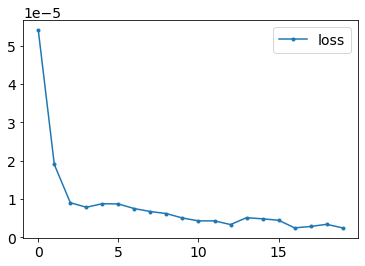

In [ ]:

df_history = pd.DataFrame(history.history)
df_history.plot(marker='.')
plt.show()

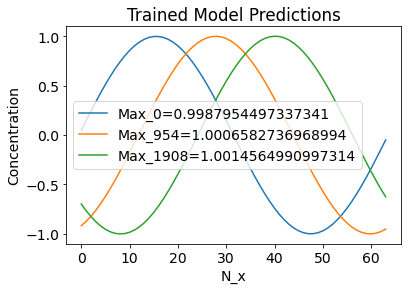

In [ ]:
'Trained'
integrated_T1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')


## Create custom class nn PA as layer

In [ ]:
def sumfirstN(n):
  return n*(n+1)/2

def CNN_out_to_PA_layer(key,eqn,stencil_size,total_acc,constr_acc,grid):
  parent=eqn.find_base_key(key)
  kdef=eqn.key_definitions[key]
  pardef=eqn.key_definitions[parent]
  deriv_ls=kdef.derivative_orders[:2]
  sten=models.build_stencils(key=kdef, parent=pardef,max_stencil_size=stencil_size, grid_step=grid.step)
  # print(sten)
  # print(f'For {key}')
  met=polynomials.Method.FINITE_DIFFERENCE
  pa=polynomials.PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=constr_acc,bias_accuracy_order = total_acc, grid_step=grid.step) #totalacc=4,constracc=1
  return pa

class MyPseudoLinearModel(models.SpatialDerivativeModel):
  """Learn pseudo-linear filters for spatial derivatives."""

  def __init__(self, equation, grid, stencil_size=5, initial_accuracy_order=1,constrained_accuracy_order=1, learned_keys=None,
               fixed_keys=None, core_model_func=models.conv2d_stack,num_time_steps=1, geometric_transforms=None,predict_permutations=True, target=None,name='pseudo_linear_model', **kwargs):

    super().__init__(equation, grid, num_time_steps, target, name)

    self.learned_keys, self.fixed_keys = (
        models.normalize_learned_and_fixed_keys(learned_keys, fixed_keys, equation))
    self.stencil_size=stencil_size
    self.total_acc=initial_accuracy_order
    self.constr_acc=constrained_accuracy_order
    self.numO=int(self.stencil_size**2 - sumfirstN(constrained_accuracy_order+1))
    
    self.eqn=equation
    self.grid=grid

    self.fd_model = models.FiniteDifferenceModel(equation, grid, initial_accuracy_order)
    self.geometric_transforms = geometric_transforms or [geometry.Identity()]

    self.CNN=models.conv2d_stack(num_outputs=2*self.numO,num_layers=4,filters=32, kernel_size=(3,1),activation='relu')
    self.PA=[]
    for key in sorted(self.learned_keys):
      pa=CNN_out_to_PA_layer(key,self.eqn,self.stencil_size,self.total_acc,self.constr_acc,self.grid)
      self.PA.append(pa)

  def _apply_model(self, state):
    size_split=[self.numO,self.numO]
    net_out=self.CNN(state)
    heads=tf.split(net_out, size_split, axis=-1)
    result={}
    for i,key in enumerate(sorted(self.learned_keys)):
      coeff_disc=self.PA[i](heads[i])
      fn_values=tensor_ops.extract_patches_2d(state['concentration'],(self.stencil_size**2,1),[0,0])
      diff=tf.einsum('bxys,bxys->bxy', coeff_disc, fn_values)
      result[key]=diff
    return result

  def spatial_derivatives(self, state):
    """See base class."""
    result=self._apply_model(state)
    for key in self.fixed_keys:
      result[key]=state[key]
    return result

model_nn = MyPseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08),fine_grid,stencil_size=3,initial_accuracy_order=1,
                                    num_time_steps=10,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
model_nn.learned_keys
model_nn.fixed_keys

{'concentration', 'x_velocity', 'y_velocity'}

In [ ]:
model_nn.__call__(initial_state).shape

TensorShape([Dimension(1), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:

# def CNN_out_to_PA_layer(key,eqn,stencil_size,total_acc,constr_acc,grid):
eqn=advection_equations.FiniteDifferenceAdvection(0.08)
key='concentration_x'
stencil_size=3
parent=eqn.find_base_key(key)
kdef=eqn.key_definitions[key]
pardef=eqn.key_definitions[parent]
deriv_ls=kdef.derivative_orders[:2]
sten=models.build_stencils(key=kdef, parent=pardef,max_stencil_size=stencil_size, grid_step=1.)
                          #  fine_grid.step)
# print(sten)
# print(f'For {key}')
met=polynomials.Method.FINITE_DIFFERENCE
pa=polynomials.PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 2, grid_step=fine_grid.step) #totalacc=4,constracc=1
# return pa

In [ ]:
A, b = polynomials.constraints(stencils=sten, method=met, derivative_orders=deriv_ls, accuracy_order=2, grid_step=fine_grid.step)

bias_grid = polynomials.coefficients(stencils=sten, method=met, derivative_orders=deriv_ls,accuracy_order=2, grid_step=fine_grid.step)

In [ ]:
sten

[array([-1.,  0.,  1.]), array([-1.,  0.,  1.])]

In [ ]:
A

array([[-1., -1., -1.,  0.,  0.,  0.,  1.,  1.,  1.],
       [-1.,  0.,  1., -1.,  0.,  1., -1.,  0.,  1.],
       [ 1., -0., -1., -0.,  0.,  0., -1.,  0.,  1.],
       [ 1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.],
       [ 1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [ ]:
bias_grid.ravel()

array([ 0. , -0.5, -0. , -0. ,  0. ,  0. , -0. ,  0.5,  0. ])

In [ ]:
A@(bias_grid.ravel())

array([1., 0., 0., 0., 0., 0.])

In [ ]:
b

array([1., 0., 0., 0., 0., 0.])

In [ ]:
 _, _, v = np.linalg.svd(A)

In [ ]:
v[-3:].shape

(3, 9)

In [ ]:
np.array([10,11])+np.array([[1,2],[3,4]])

array([[11, 13],
       [13, 15]])

In [ ]:
x1=np.arange(15).reshape(1,5,1,3)
x1

array([[[[ 0,  1,  2]],

        [[ 3,  4,  5]],

        [[ 6,  7,  8]],

        [[ 9, 10, 11]],

        [[12, 13, 14]]]])

In [ ]:
y1=np.arange(3)
y1

array([0, 1, 2])

In [ ]:
x1+y1

array([[[[ 0,  2,  4]],

        [[ 3,  5,  7]],

        [[ 6,  8, 10]],

        [[ 9, 11, 13]],

        [[12, 14, 16]]]])

In [ ]:
x1=tf.convert_to_tensor(x1)
x1

<tf.Tensor: id=3, shape=(1, 5, 1, 3), dtype=int64, numpy=
array([[[[ 0,  1,  2]],

        [[ 3,  4,  5]],

        [[ 6,  7,  8]],

        [[ 9, 10, 11]],

        [[12, 13, 14]]]])>

In [ ]:
[stencil.size for stencil in sten]

[3, 3]

In [ ]:
l7([x1,initial_state['concentration']])

InvalidArgumentError: ignored

In [ ]:
l7=models.VaryingCoefficientsLayer(pa,sten,[0.,0])
      # shifts: List[int],
      # input_key: Optional[str] = None,
  

In [ ]:
initial_state['concentration'][0,0:15]

array([[0.04906768],
       [0.14673047],
       [0.24298018],
       [0.33688986],
       [0.42755508],
       [0.51410276],
       [0.5956993 ],
       [0.671559  ],
       [0.7409511 ],
       [0.8032075 ],
       [0.8577286 ],
       [0.9039893 ],
       [0.94154406],
       [0.97003126],
       [0.9891765 ]], dtype=float32)

In [ ]:
x2=tf.squeeze(tf.convert_to_tensor(np.arange(5).reshape(1,5,1)),0)
x2

<tf.Tensor: id=73, shape=(5, 1), dtype=int64, numpy=
array([[0],
       [1],
       [2],
       [3],
       [4]])>

In [ ]:
paddings = tf.constant([[2, 2,], [2, 2]])

In [ ]:
pd=tf.convert_to_tensor(np.pad(x2, (2, 2), 'reflect'))
pd1=pd[tf.newaxis,:,:,tf.newaxis]
# pd1[0]
pd

<tf.Tensor: id=105, shape=(9, 5), dtype=int64, numpy=
array([[2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4],
       [3, 3, 3, 3, 3],
       [2, 2, 2, 2, 2]])>

In [ ]:
x2

<tf.Tensor: id=73, shape=(5, 1), dtype=int64, numpy=
array([[0],
       [1],
       [2],
       [3],
       [4]])>

In [ ]:
pd=tf.convert_to_tensor(np.pad(x2, (1, 1), 'wrap'))
pd1=pd[tf.newaxis,:,:,tf.newaxis]
# # pd1[0]
# pd
tf.extract_image_patches(pd1,[1, 3, 3, 1],strides=[1, 1, 1, 1],rates=[1, 1, 1, 1],padding='VALID')

<tf.Tensor: id=126, shape=(1, 5, 1, 9), dtype=int64, numpy=
array([[[[4, 4, 4, 0, 0, 0, 1, 1, 1]],

        [[0, 0, 0, 1, 1, 1, 2, 2, 2]],

        [[1, 1, 1, 2, 2, 2, 3, 3, 3]],

        [[2, 2, 2, 3, 3, 3, 4, 4, 4]],

        [[3, 3, 3, 4, 4, 4, 0, 0, 0]]]])>

In [ ]:
type(5//2)

int

In [ ]:
def my_extract_2d_patches(x,k_size):
  x1=tf.squeeze(x,0)
  pad_size=k_size//2
  pad2d=tf.convert_to_tensor(np.pad(x1, (pad_size, pad_size), 'wrap'))
  pad4d=pad2d[tf.newaxis,:,:,tf.newaxis]
  t_ext = tf.extract_image_patches(pad4d,[1, k_size, k_size, 1],strides=[1, 1, 1, 1],rates=[1, 1, 1, 1],padding='VALID')
  return t_ext

In [ ]:
x2=tf.convert_to_tensor(np.arange(5).reshape(1,5,1))
x2

<tf.Tensor: id=139, shape=(1, 5, 1), dtype=int64, numpy=
array([[[0],
        [1],
        [2],
        [3],
        [4]]])>

In [ ]:
my_extract_2d_patches(x2,7)

<tf.Tensor: id=160, shape=(1, 5, 1, 49), dtype=int64, numpy=
array([[[[2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
          4, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
          2, 2, 3, 3, 3, 3, 3, 3, 3]],

        [[3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0,
          0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
          3, 3, 4, 4, 4, 4, 4, 4, 4]],

        [[4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
          1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
          4, 4, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
          2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0,
          0, 0, 1, 1, 1, 1, 1, 1, 1]],

        [[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
          3, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
          1, 1, 2, 2, 2, 2, 2, 2, 2]]]])>

In [ ]:
pd=tf.convert_to_tensor(np.pad(x2, (2, 2), 'wrap'))
pd1=pd[tf.newaxis,:,:,tf.newaxis]
# # pd1[0]
print(pd)
tf.extract_image_patches(pd1,[1, 5, 5, 1],strides=[1, 1, 1, 1],rates=[1, 1, 1, 1],padding='VALID')

tf.Tensor(
[[3 3 3 3 3]
 [4 4 4 4 4]
 [0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]
 [0 0 0 0 0]
 [1 1 1 1 1]], shape=(9, 5), dtype=int64)


<tf.Tensor: id=138, shape=(1, 5, 1, 25), dtype=int64, numpy=
array([[[[3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
          2, 2, 2, 2, 2]],

        [[4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
          3, 3, 3, 3, 3]],

        [[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
          4, 4, 4, 4, 4]],

        [[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
          0, 0, 0, 0, 0]],

        [[2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0,
          1, 1, 1, 1, 1]]]])>

In [ ]:
tf.pad(x2, paddings, "REFLECT")

InvalidArgumentError: ignored

In [ ]:
tensor_ops.extract_patches_2d(x2, [3,3], [0,0])

<tf.Tensor: id=25, shape=(1, 5, 1, 9), dtype=int64, numpy=
array([[[[4, 4, 4, 0, 0, 0, 1, 1, 1]],

        [[0, 0, 0, 1, 1, 1, 2, 2, 2]],

        [[1, 1, 1, 2, 2, 2, 3, 3, 3]],

        [[2, 2, 2, 3, 3, 3, 4, 4, 4]],

        [[3, 3, 3, 4, 4, 4, 0, 0, 0]]]])>

In [ ]:
padding=tensor_ops.paddings_for_conv2d([3,3], [0,0])[:-1]
print(padding)
tensor_ops.pad_periodic(x2, padding)

[(0, 0), (1, 1), (1, 1)]


<tf.Tensor: id=45, shape=(1, 7, 3), dtype=int64, numpy=
array([[[4, 4, 4],
        [0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [4, 4, 4],
        [0, 0, 0]]])>

In [ ]:
padding=tensor_ops.paddings_for_conv2d([5,5], [0,0])[:-1]
print(padding)
tensor_ops.pad_periodic(x2, padding)

[(0, 0), (2, 2), (2, 2)]


<tf.Tensor: id=65, shape=(1, 9, 3), dtype=int64, numpy=
array([[[3, 3, 3],
        [4, 4, 4],
        [0, 0, 0],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [4, 4, 4],
        [0, 0, 0],
        [1, 1, 1]]])>

In [ ]:

len(model_nn.spatial_derivatives(initial_state))

5

In [ ]:
type(model_nn.spatial_derivatives(initial_state))

dict

In [ ]:
model_nn.spatial_derivatives(initial_state).keys()


dict_keys(['concentration_x', 'concentration_y', 'x_velocity', 'concentration', 'y_velocity'])

In [ ]:
# model_nn._apply_model(initial_state)

## Understand model_nn layer by layer

In [ ]:
'Library conv2dstack takes kernel_size as tuple'
'Input--initial_state dict 3 key values of shape 1x64x1 each'
'output--tensor of shape 1x64x1xnum_outputs'
model1=models.conv2d_stack(num_outputs=15,num_layers=5,filters=32, kernel_size=(5,1),activation='relu')
net_out=model1(initial_state)
net_out.shape

TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(15)])

In [ ]:
'Analyzing output layer'
ol=models.build_output_layers(equation=eq_nn, grid=fine_grid, learned_keys={'concentration_x','concentration_y'}, stencil_size=3, initial_accuracy_order=1
                    ,constrained_accuracy_order=1, layer_cls=models.VaryingCoefficientsLayer,
                    predict_permutations=True)
model1=models.conv2d_stack(num_outputs=6,num_layers=5,filters=32, kernel_size=(3,1),activation='relu')
net_out=model1(initial_state)
for k,l in ol.items():
  print(l([net_out, initial_state['concentration']]).shape)

NameError: ignored

In [ ]:
'Pass NN output to PolAcc layer'

'''

Original model uses PseudoLinear Class
PseudoLinear Class --->(Uses) Variable Coefficients Layer
Variable Coefficients Layer --->(Uses) Pol Acc layer

To analyze model_nn go to the lowest(parent) class and analyze line by line'''


In [ ]:
eq_nn=advection_equations.FiniteDifferenceAdvection(0.08)
# for key in model_nn.learned_keys:
#   print(key)
for key in model_nn.learned_keys:
  parent=eq_nn.find_base_key(key)
  kdef=eq_nn.key_definitions[key]
  pardef=eq_nn.key_definitions[parent]
  # sten=models.build_stencils(key=kdef, parent=pardef,max_stencil_size=3, grid_step=fine_grid.step)
  print(f'For {key}')
  sten=models.build_stencils(key=kdef, parent=pardef,max_stencil_size=3, grid_step=1.)
  print(sten)
  print('\n')
  # [0:1]
  

For concentration_x
[array([-1.,  0.,  1.]), array([-1.,  0.,  1.])]


For concentration_y
[array([-1.,  0.,  1.]), array([-1.,  0.,  1.])]




In [ ]:
sten[0:1]

[array([-1.,  0.,  1.])]

In [ ]:
eq_nn.find_base_key('concentration_x')

'concentration'

In [ ]:
kdef

StateDefinition(name='concentration', tensor_indices=(), derivative_orders=(1, 0, 0), offset=(0, 0), variant='')

In [ ]:
pardef

StateDefinition(name='concentration', tensor_indices=(), derivative_orders=(0, 0, 0), offset=(0, 0), variant='')

In [ ]:
'Analyzing output layer'
ol=models.build_output_layers(equation=eq_nn, grid=fine_grid, learned_keys={'concentration_x','concentration_y'}, stencil_size=3, initial_accuracy_order=1
                    ,constrained_accuracy_order=1, layer_cls=models.VaryingCoefficientsLayer,
                    predict_permutations=True)
model1=models.conv2d_stack(num_outputs=6,num_layers=5,filters=32, kernel_size=(3,1),activation='relu')
net_out=model1(initial_state)
for k,l in ol.items():
  print(l([net_out, initial_state['concentration']]).shape)

(1, 64, 1)
(1, 64, 1)


In [ ]:
sorted(['b','a'])

['a', 'b']

In [ ]:
['concentration_y','concentration_x']

['concentration_y', 'concentration_x']

In [ ]:
for i,key in enumerate(sorted(['concentration_y','concentration_x'])):
  print(i,key)

0 concentration_x
1 concentration_y


In [ ]:
def sumfirstN(n):
  return n*(n+1)/2


def CNN_out_to_diff_dict(x,key,state,eqn,stencil_size,total_acc,constr_acc,grid):
  parent=eqn.find_base_key(key)
  kdef=eqn.key_definitions[key]
  pardef=eqn.key_definitions[parent]
  deriv_ls=kdef.derivative_orders[:2]
  sten=models.build_stencils(key=kdef, parent=pardef,max_stencil_size=stencil_size, grid_step=grid.step)
  # print(sten)
  # print(f'For {key}')
  met=polynomials.Method.FINITE_DIFFERENCE
  pa=polynomials.PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=constr_acc,bias_accuracy_order = total_acc, grid_step=grid.step) #totalacc=4,constracc=1
  coeff_disc=pa(x)
  fn_values=tensor_ops.extract_patches_2d(state['concentration'],(stencil_size**2,1),[0,0])
  diff=tf.einsum('bxys,bxys->bxy', coeff_disc, fn_values)
  return diff

  # result[key]=diff
  # return result



stencil_size=5
numO=int(stencil_size**2 - sumfirstN(4+1))
size_split=[numO,numO]
model1=models.conv2d_stack(num_outputs=2*numO,num_layers=5,filters=32, kernel_size=(5,1),activation='relu')
net_out=model1(initial_state)


heads=tf.split(net_out, size_split, axis=-1)
result={}
for i,key in enumerate(sorted(['concentration_y','concentration_x'])):
  result[key]=CNN_out_to_diff_dict(heads[i],key,state,eqn,stencil_size,total_acc,constr_acc,grid)

# for key in sorted(['concentration_y','concentration_x']):
  
#   result[key]=CNN_out_to_diff_dict(,key,state,eqn,stencil_size,total_acc,constr_acc,grid)

In [ ]:
def sumfirstN(n):
  return n*(n+1)/2
stencil_size=5
out_sh = int(stencil_size**2 - sumfirstN(4+1))
out_sh

10

In [ ]:

def CNN_out_to_diff_dict(x,learnedKeys,state,eqn,stencil_size,total_acc,constr_acc,grid):
  result={}
  for key in learnedKeys:

  parent=eqn.find_base_key(key)
  kdef=eqn.key_definitions[key]
  pardef=eqn.key_definitions[parent]
  deriv_ls=kdef.derivative_orders[:2]
  sten=models.build_stencils(key=kdef, parent=pardef,max_stencil_size=stencil_size, grid_step=grid.step)
  # print(sten)
  # print(f'For {key}')
  met=polynomials.Method.FINITE_DIFFERENCE
  pa=polynomials.PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=constr_acc,bias_accuracy_order = total_acc, grid_step=grid.step) #totalacc=4,constracc=1
  coeff_disc=pa(x)
  fn_values=tensor_ops.extract_patches_2d(state['concentration'],(stencil_size**2,1),[0,0])
  diff=tf.einsum('bxys,bxys->bxy', coeff_disc, fn_values)
  
  result[key]=diff
  return result

numO=10
model1=models.conv2d_stack(num_outputs=2*numO,num_layers=5,filters=32, kernel_size=(5,1),activation='relu')
net_out=model1(initial_state)
size_split=[numO,numO]
h_x,h_y=tf.split(net_out, size_split, axis=-1)

# eq_nn=advection_equations.FiniteDifferenceAdvection(0.08)
# coff=CNN_out_to_diff_dict(net_out,model_nn.learned_keys,initial_state,eq_nn,5,4,4,fine_grid)['concentration_x']
# coff.shape

# print(CNN_out_to_diff_dict(net_out,model_nn.learned_keys,initial_state,eq_nn,3,2,1,fine_grid)['concentration_y'].shape)


  # parent=eq.find_base_key('concentration_x')
  # kdef=eq.key_definitions['concentration_x']
  # pardef=eq.key_definitions[parent]
  # sten=models.build_stencils(kdef, pardef,stencil_size, grid.step)[0:1]
  # deriv_ls=[1]
  # met=polynomials.Method.FINITE_DIFFERENCE
  # pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=constr_acc,bias_accuracy_order = total_acc) #totalacc=4,constracc=1
  # coeff_disc=pa(x) # 1,64,1,5
  # fn_values=tensor_ops.extract_patches_2d(state['concentration'],(stencil_size,1),[0,0])
  # diff=tf.einsum('bxys,bxys->bxy', coeff_disc, fn_values)
  # return diff

TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(10)])

In [ ]:
coff.shape

TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(25)])

In [ ]:
initial_state['concentration'].flatten()

array([ 0.04906768,  0.14673047,  0.24298018,  0.33688986,  0.42755508,
        0.51410276,  0.5956993 ,  0.671559  ,  0.7409511 ,  0.8032075 ,
        0.8577286 ,  0.9039893 ,  0.94154406,  0.97003126,  0.9891765 ,
        0.99879545,  0.99879545,  0.9891765 ,  0.97003126,  0.94154406,
        0.9039893 ,  0.8577286 ,  0.8032075 ,  0.7409511 ,  0.671559  ,
        0.5956993 ,  0.51410276,  0.42755508,  0.33688986,  0.24298018,
        0.14673047,  0.04906768, -0.04906768, -0.14673047, -0.24298018,
       -0.33688986, -0.42755508, -0.51410276, -0.5956993 , -0.671559  ,
       -0.7409511 , -0.8032075 , -0.8577286 , -0.9039893 , -0.94154406,
       -0.97003126, -0.9891765 , -0.99879545, -0.99879545, -0.9891765 ,
       -0.97003126, -0.94154406, -0.9039893 , -0.8577286 , -0.8032075 ,
       -0.7409511 , -0.671559  , -0.5956993 , -0.51410276, -0.42755508,
       -0.33688986, -0.24298018, -0.14673047, -0.04906768], dtype=float32)

In [ ]:
fn_values=tensor_ops.extract_patches_2d(initial_state['concentration'],(stencil_size**2,1),[0,0])
diff=tf.einsum('bxys,bxys->bxy', coeff_disc, fn_values)
return diff
fn_values

<tf.Tensor: id=681, shape=(1, 64, 1, 25), dtype=float32, numpy=
array([[[[-0.9039893 , -0.8577286 , -0.8032075 , ...,  0.8577286 ,
           0.9039893 ,  0.94154406]],

        [[-0.8577286 , -0.8032075 , -0.7409511 , ...,  0.9039893 ,
           0.94154406,  0.97003126]],

        [[-0.8032075 , -0.7409511 , -0.671559  , ...,  0.94154406,
           0.97003126,  0.9891765 ]],

        ...,

        [[-0.9891765 , -0.97003126, -0.94154406, ...,  0.671559  ,
           0.7409511 ,  0.8032075 ]],

        [[-0.97003126, -0.94154406, -0.9039893 , ...,  0.7409511 ,
           0.8032075 ,  0.8577286 ]],

        [[-0.94154406, -0.9039893 , -0.8577286 , ...,  0.8032075 ,
           0.8577286 ,  0.9039893 ]]]], dtype=float32)>

## Analyze pattern between stencil_size =5 accuracy orders

In [ ]:
print(CNN_out_to_diff_dict(net_out,model_nn.learned_keys,initial_state,eq_nn,5,4,1,fine_grid)['concentration_x'].shape)

InvalidArgumentError: ignored

In [ ]:
print(CNN_out_to_diff_dict(net_out,model_nn.learned_keys,initial_state,eq_nn,5,4,2,fine_grid)['concentration_x'].shape)

InvalidArgumentError: ignored

In [ ]:
print(CNN_out_to_diff_dict(net_out,model_nn.learned_keys,initial_state,eq_nn,5,4,3,fine_grid)['concentration_x'].shape)

InvalidArgumentError: ignored

In [ ]:
print(CNN_out_to_diff_dict(net_out,model_nn.learned_keys,initial_state,eq_nn,5,4,4,fine_grid)['concentration_x'].shape)

InvalidArgumentError: ignored

## Analyze pattern between stencilsize =9 accuracy orders

In [ ]:
print(CNN_out_to_diff_dict(net_out,model_nn.learned_keys,initial_state,eq_nn,9,8,6,fine_grid)['concentration_x'].shape)

InvalidArgumentError: ignored

In [ ]:
print(CNN_out_to_diff_dict(net_out,model_nn.learned_keys,initial_state,eq_nn,9,8,8,fine_grid)['concentration_x'].shape)

InvalidArgumentError: ignored

In [ ]:
print(CNN_out_to_diff_dict(net_out,model_nn.learned_keys,initial_state,eq_nn,9,8,7,fine_grid)['concentration_x'].shape)

InvalidArgumentError: ignored

In [ ]:
print(CNN_out_to_diff_dict(net_out,model_nn.learned_keys,initial_state,eq_nn,9,8,6,fine_grid)['concentration_x'].shape)

InvalidArgumentError: ignored

In [ ]:
print(CNN_out_to_diff_dict(net_out,model_nn.learned_keys,initial_state,eq_nn,9,8,5,fine_grid)['concentration_x'].shape)

InvalidArgumentError: ignored

In [ ]:
print(CNN_out_to_diff_dict(net_out,model_nn.learned_keys,initial_state,eq_nn,9,8,4,fine_grid)['concentration_x'].shape)

InvalidArgumentError: ignored

In [ ]:
print(CNN_out_to_diff_dict(net_out,model_nn.learned_keys,initial_state,eq_nn,9,8,3,fine_grid)['concentration_x'].shape)

InvalidArgumentError: ignored

In [ ]:
print(CNN_out_to_diff_dict(net_out,model_nn.learned_keys,initial_state,eq_nn,9,8,2,fine_grid)['concentration_x'].shape)

InvalidArgumentError: ignored

In [ ]:
print(CNN_out_to_diff_dict(net_out,model_nn.learned_keys,initial_state,eq_nn,9,8,1,fine_grid)['concentration_x'].shape)

InvalidArgumentError: ignored

In [ ]:
model1=models.conv2d_stack(num_outputs=6,num_layers=5,filters=32, kernel_size=(5,1),activation='relu')
net_out=model1(initial_state)
print(net_out.shape)

for key in model_nn.learned_keys:
  parent=eq_nn.find_base_key(key)
  kdef=eq_nn.key_definitions[key]
  pardef=eq_nn.key_definitions[parent]
  print(kdef.derivative_orders[:2])
  deriv_ls=kdef.derivative_orders[:2]
  # [1,0]
  # sten=models.build_stencils(key=kdef, parent=pardef,max_stencil_size=3, grid_step=fine_grid.step)
  print(f'For {key}')
  sten=models.build_stencils(key=kdef, parent=pardef,max_stencil_size=3, grid_step=1.)
  print(sten)
  met=polynomials.Method.FINITE_DIFFERENCE
  pa=polynomials.PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 2, grid_step=1.) #totalacc=4,constracc=1
  coeff_disc=pa(net_out)
  print(coeff_disc.shape)
  print('\n')

(1, 64, 1, 6)
(1, 0)
For concentration_x
[array([-1.,  0.,  1.]), array([-1.,  0.,  1.])]
(1, 64, 1, 9)


(0, 1)
For concentration_y
[array([-1.,  0.,  1.]), array([-1.,  0.,  1.])]
(1, 64, 1, 9)




In [ ]:
'''9 coeff in the x-direction
9 coeff in the y-direction
Both jointy used to progress further in time'''

In [ ]:
eq_new=adv1d(u=1.,timestep=dt)
k1='concentration_x'
parent=eq_new.find_base_key(k1)
kdef=eq_new.key_definitions[k1]
pardef=eq_new.key_definitions[parent]
# deriv_ls=[1,0]
sten=models.build_stencils(key=kdef, parent=pardef,max_stencil_size=3, grid_step=1.)
print(sten)
met=polynomials.Method.FINITE_DIFFERENCE
pa=polynomials.PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 2, grid_step=1.) #totalacc=4,constracc=1
coeff_disc=pa(net_out)
coeff_disc.shape

[array([-1.,  0.,  1.]), array([-1.,  0.,  1.])]


TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(9)])

In [ ]:
pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=constr_acc,bias_accuracy_order = total_acc) #totalacc=4,constracc=1

In [ ]:
met=polynomials.Method.FINITE_DIFFERENCE
met

<Method.FINITE_DIFFERENCE: 1>

In [ ]:
parent=eq.find_base_key('concentration_x')
kdef=eq.key_definitions['concentration_x']
pardef=eq.key_definitions[parent]
sten=models.build_stencils(kdef, pardef,stencil_size, grid.step)[0:1]
deriv_ls=[1]
met=polynomials.Method.FINITE_DIFFERENCE
pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=constr_acc,bias_accuracy_order = total_acc) #totalacc=4,constracc=1
coeff_disc=pa(x) # 1,64,1,5

In [ ]:

def cnn_out_to_diff(x,state,eq,stencil_size,total_acc,constr_acc,grid):
  parent=eq.find_base_key('concentration_x')
  kdef=eq.key_definitions['concentration_x']
  pardef=eq.key_definitions[parent]
  sten=models.build_stencils(kdef, pardef,stencil_size, grid.step)[0:1]
  deriv_ls=[1]
  met=polynomials.Method.FINITE_DIFFERENCE
  pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=constr_acc,bias_accuracy_order = total_acc) #totalacc=4,constracc=1
  coeff_disc=pa(x) # 1,64,1,5
  fn_values=tensor_ops.extract_patches_2d(state['concentration'],(stencil_size,1),[0,0])
  diff=tf.einsum('bxys,bxys->bxy', coeff_disc, fn_values)
  return diff

In [ ]:
'Now Output of CNN = 1x64x1xnum_outputs '

'Get alphas of shape 1,64,1,5 after passing through polynomial accuracy layer'

'Get alphas of shape 1,64,1,5 after passing through polynomial accuracy layer'

# Extra functionalities

### Extra

In [ ]:
# print(tf.squeeze(state_time_progression(model_nn,initial_state)))
# print(tf.squeeze(initial_state['concentration']))

In [ ]:
# x=tf.Variable([1,2,3])
# x
# for i in range(10):
#   x=x+1
#   print(x)

In [ ]:
train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)


 train_input shape:
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)

 train_output shape: (1899, 10, 64, 1)


In [ ]:
type(train_input)

dict

In [ ]:
import tensorflow.keras.backend as kb
def custom_loss(y_actual,y_pred):
    custom_loss=kb.square(y_actual-y_pred)
    return custom_loss

In [ ]:
def my_extract_2d_patches(x,k_size):
  x1=tf.squeeze(x,0)
  pad_size=k_size//2
  pad2d=tf.convert_to_tensor(np.pad(x1, (pad_size, pad_size), 'wrap'))
  pad4d=pad2d[tf.newaxis,:,:,tf.newaxis]
  t_ext = tf.extract_image_patches(pad4d,[1, k_size, k_size, 1],strides=[1, 1, 1, 1],rates=[1, 1, 1, 1],padding='VALID')
  return t_ext

def state_time_progression(model,state,delt=dt,uinit=u0):
  C=state['concentration']
  C_x=model._apply_model(state)['concentration_x']
  Ct1=C+delt*(-uinit)*(C_x)
  return Ct1

def integrate_func(ml_model,init_state,N_t):
  i0={}
  for key,arr in init_state.items():
    i0[key]=tf.convert_to_tensor(arr)
  
  state_i=i0
  l=[i0['concentration']]

  for i in range(N_t-1):
    C_i=state_time_progression(ml_model,state_i)
    l.append(C_i)
    state_i['concentration']=C_i
  tens=tf.stack(l)
  return tens.numpy().squeeze()  



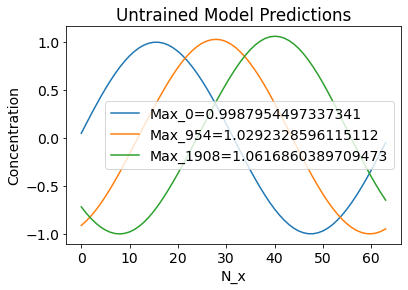

In [ ]:
# plot_time_prop(integrate_func(ml_model,init_state,N_t)
model_nn = PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                    num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
# tf.random.set_random_seed(0)

plot_time_prop(integrate_func(model_nn,initial_state,N_t),0,N_t//2,N_t-1,'Untrained ')

In [ ]:
tf.convert_to_tensor(initial_state['concentration']).shape
# .numpy().squeeze()

TensorShape([Dimension(1), Dimension(64), Dimension(1)])

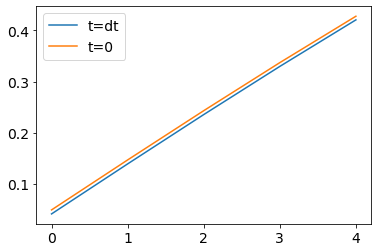

In [ ]:


plt.plot(state_time_progression(model_nn,initial_state).numpy().squeeze()[0:5],label='t=dt')
plt.plot(initial_state['concentration'].squeeze()[0:5],label='t=0')
plt.legend()

In [ ]:
i1=[tf.convert_to_tensor(arr) for key,arr in initial_state.items()]

In [ ]:
i1={}
for key,arr in initial_state.items():
  i1[key]=tf.convert_to_tensor(arr)


In [ ]:
i1['concentration'].shape

TensorShape([Dimension(1), Dimension(64), Dimension(1)])

In [ ]:
model_nn._apply_model(i1)

{'concentration_x': <tf.Tensor: id=1781521, shape=(1, 64, 1), dtype=float32, numpy=
 array([[[ 0.9971436 ],
         [ 0.98747057],
         [ 0.9682957 ],
         [ 0.93980426],
         [ 0.90234977],
         [ 0.85623395],
         [ 0.8018348 ],
         [ 0.73964995],
         [ 0.6703162 ],
         [ 0.5946797 ],
         [ 0.5132749 ],
         [ 0.42692554],
         [ 0.33645892],
         [ 0.24270909],
         [ 0.14663151],
         [ 0.04913542],
         [-0.04885938],
         [-0.14640552],
         [-0.24255231],
         [-0.33634916],
         [-0.42689162],
         [-0.5133482 ],
         [-0.5949004 ],
         [-0.6707534 ],
         [-0.7401605 ],
         [-0.8023567 ],
         [-0.8567864 ],
         [-0.90288013],
         [-0.94032574],
         [-0.9687096 ],
         [-0.9877499 ],
         [-0.9972556 ],
         [-0.99713176],
         [-0.98743147],
         [-0.96822256],
         [-0.9396675 ],
         [-0.90198374],
         [-0.85575324],
    

In [ ]:
model_nn._apply_model(initial_state)

{'concentration_x': <tf.Tensor: id=1781382, shape=(1, 64, 1), dtype=float32, numpy=
 array([[[ 0.9971436 ],
         [ 0.98747057],
         [ 0.9682957 ],
         [ 0.93980426],
         [ 0.90234977],
         [ 0.85623395],
         [ 0.8018348 ],
         [ 0.73964995],
         [ 0.6703162 ],
         [ 0.5946797 ],
         [ 0.5132749 ],
         [ 0.42692554],
         [ 0.33645892],
         [ 0.24270909],
         [ 0.14663151],
         [ 0.04913542],
         [-0.04885938],
         [-0.14640552],
         [-0.24255231],
         [-0.33634916],
         [-0.42689162],
         [-0.5133482 ],
         [-0.5949004 ],
         [-0.6707534 ],
         [-0.7401605 ],
         [-0.8023567 ],
         [-0.8567864 ],
         [-0.90288013],
         [-0.94032574],
         [-0.9687096 ],
         [-0.9877499 ],
         [-0.9972556 ],
         [-0.99713176],
         [-0.98743147],
         [-0.96822256],
         [-0.9396675 ],
         [-0.90198374],
         [-0.85575324],
    

### Myfunction

In [ ]:
x=tf.convert_to_tensor(np.arange(5).reshape(1,5,1))
x

<tf.Tensor: id=284957, shape=(1, 5, 1), dtype=int64, numpy=
array([[[0],
        [1],
        [2],
        [3],
        [4]]])>

In [ ]:
tensor_ops.extract_patches_2d(x, [3,3], [0,0])

<tf.Tensor: id=285004, shape=(1, 5, 1, 9), dtype=int64, numpy=
array([[[[4, 4, 4, 0, 0, 0, 1, 1, 1]],

        [[0, 0, 0, 1, 1, 1, 2, 2, 2]],

        [[1, 1, 1, 2, 2, 2, 3, 3, 3]],

        [[2, 2, 2, 3, 3, 3, 4, 4, 4]],

        [[3, 3, 3, 4, 4, 4, 0, 0, 0]]]])>

In [ ]:
my_extract_2d_patches(x,3)

<tf.Tensor: id=284964, shape=(1, 5, 1, 9), dtype=int64, numpy=
array([[[[4, 4, 4, 0, 0, 0, 1, 1, 1]],

        [[0, 0, 0, 1, 1, 1, 2, 2, 2]],

        [[1, 1, 1, 2, 2, 2, 3, 3, 3]],

        [[2, 2, 2, 3, 3, 3, 4, 4, 4]],

        [[3, 3, 3, 4, 4, 4, 0, 0, 0]]]])>

In [ ]:

tf
|
|
numpy
|
|
tf


In [ ]:
1x15x1

1x5x1x9

x
W,B

y1 + function_values

In [ ]:
# X=np.ones((5,1))
# dummmy_pad(X,1)

In [ ]:
# def log_huber(x, m):
#   if tf.abs(x) <= m:
#     return x**2
#   else:
#     return m**2 * (1 - 2 * tf.math.log(m) + tf.math.log(x**2))

# x = tf.compat.v1.placeholder(tf.float32)
# m = tf.compat.v1.placeholder(tf.float32)

# y = tf.py_function(func=log_huber, inp=[x, m], Tout=tf.float32)

In [ ]:
# pad2d=tf.convert_to_tensor(
#     np.pad(x1, (pad_size, pad_size), 'wrap'))
# =1

def dummmy_pad(x,pad_size):
  # pad_size=pad_size_np[0]
  return [np.pad(x, (pad_size, pad_size), 'wrap')]
  
X=tf.ones([5,1])
n=tf.constant(1)
tffunc=tf.py_func(dummmy_pad,[X,n], [tf.float32], name='padded')

In [ ]:
n.shape

TensorShape([])

In [ ]:
tffunc

<tf.Tensor: id=1351939, shape=(7, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)>

In [ ]:
X

<tf.Tensor: id=1351788, shape=(1, 5, 1), dtype=float32, numpy=
array([[[-1.1745497 ],
        [-0.683058  ],
        [-0.22088325],
        [ 1.9310919 ],
        [-0.5113529 ]]], dtype=float32)>

In [ ]:
def my_extract_2d_patches(x,k_size):
  x1=tf.squeeze(x,0)
  pad_size=k_size//2
  pad2d=tf.convert_to_tensor(np.pad(x1, (pad_size, pad_size), 'wrap'))
  pad4d=pad2d[tf.newaxis,:,:,tf.newaxis]
  t_ext = tf.extract_image_patches(pad4d,[1, k_size, k_size, 1],strides=[1, 1, 1, 1],rates=[1, 1, 1, 1],padding='VALID')
  return t_ext

def state_time_progression(model,state,delt=dt,uinit=u0):
  C=state['concentration']
  C_x=model._apply_model(state)['concentration_x']
  Ct1=C+delt*(-uinit)*(C_x)
  return Ct1

def integrate_func(ml_model,init_state,N_t):
  i0={}
  for key,arr in init_state.items():
    i0[key]=tf.convert_to_tensor(arr)
  
  state_i=i0
  l=[i0['concentration']]

  for i in range(N_t-1):
    C_i=state_time_progression(ml_model,state_i)
    l.append(C_i)
    state_i['concentration']=C_i
  tens=tf.stack(l)
  return tens.numpy().squeeze()  



# Model_new

In [ ]:
model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                    num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
'Untrained'
integrated_UT1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
plot_time_prop(integrated_UT1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained ')

'Training'
ground_soln_dict=ground_dict_from_data(data_ana)
train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
# train_output.shape
model_nn.compile(optimizer='adam', loss='mae')
history = model_nn.fit(train_input, train_output, epochs=20, batch_size=64, verbose=1, shuffle=True)
df_history = pd.DataFrame(history.history)
df_history.plot(marker='.')
plt.show()

'Trained'
integrated_T1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')


## Understand model_new layer by layer

# Pol Acc layer

## Define advection eqn in 1-D

In [ ]:
from datadrivenpdes.core import equations
from datadrivenpdes.core import states
class adv1d(equations.Equation):

    DISCRETIZATION_NAME = 'finite_difference'
    METHOD = polynomials.Method.FINITE_DIFFERENCE
    MONOTONIC = False
    CONTINUOUS_EQUATION_NAME = 'Advection-1d'

    key_definitions = {
        'concentration': states.StateDefinition(name='concentration',
                      tensor_indices=(),
                      derivative_orders=(0,0,0),
                      offset=(0,0)),
        'concentration_x': states.StateDefinition(name='concentration',
                         tensor_indices=(),
                         derivative_orders=(1, 0, 0),
                         offset=(0, 0)),

    }
    evolving_keys = {'concentration'}
    constant_keys = set()

    def __init__(self, u, timestep=1e-4):
        self._timestep = timestep
        self.u=u
        super().__init__()
    
    def time_derivative(
          self, grid, concentration, concentration_x,):
        """See base class."""
        advA=-self.u*concentration_x

        return {'concentration': advA,}

    def get_time_step(self):
        return self._timestep


In [ ]:
eq_new=adv1d(u=1.,timestep=dt)

## Define Polynomial Acc function

In [ ]:
from typing import Any, Iterator, Optional, Sequence, Tuple
import enum
class Method(enum.Enum):
  """Discretization method."""
  FINITE_DIFFERENCE = 1
  FINITE_VOLUME = 2
class PolynomialAccuracy(tf.keras.layers.Layer):
  def __init__(self,stencils: Sequence[np.ndarray],method: Method,derivative_orders: Sequence[int],accuracy_order: int = 1,
               bias_accuracy_order: Optional[int] = 2,grid_step: float = None,bias: np.ndarray = None,dtype: Any = np.float32,):

    A, b = polynomials.constraints(stencils, method, derivative_orders, accuracy_order, grid_step)

    if bias is None:
      bias_grid = polynomials.coefficients(stencils, method, derivative_orders,bias_accuracy_order,grid_step)
      bias = bias_grid.ravel()

    norm = np.linalg.norm(np.dot(A, bias) - b)
    if norm > 1e-8:
      raise ValueError('invalid bias, not in nullspace')
    # https://en.wikipedia.org/wiki/Kernel_(linear_algebra)#Nonhomogeneous_systems_of_linear_equations
    _, _, v = np.linalg.svd(A)
    input_size = A.shape[1] - A.shape[0]
    if not input_size:
      raise ValueError(  # pylint: disable=g-doc-exception
          'there is only one valid solution accurate to this order')

    # nullspace from the SVD is always normalized such that its singular values
    # are 1 or 0, which means it's actually independent of the grid spacing.
    nullspace = v[-input_size:]
    # nullspace /= (grid_step**np.array(derivative_orders)).prod()

    self.input_size = input_size
    self.output_size = b.size
    self.nullspace = tf.convert_to_tensor(nullspace, dtype)
    self.bias = tf.convert_to_tensor(bias, dtype)

    super().__init__(trainable=False, dtype=dtype)

  def compute_output_shape(self, input_shape):
    return input_shape[:-1] + (self.output_size,)

  def call(self, x: tf.Tensor) -> tf.Tensor:
    # TODO(geraschenko): explore projecting out the nullspace from full rank
    # inputs instead.
    return self.bias + tf.tensordot(x, self.nullspace, axes=[-1, 0])

def cnn_out_to_diff(x,state,eq,stencil_size,total_acc,constr_acc,grid):
  parent=eq.find_base_key('concentration_x')
  kdef=eq.key_definitions['concentration_x']
  pardef=eq.key_definitions[parent]
  sten=models.build_stencils(kdef, pardef,stencil_size, grid.step)[0:1]
  deriv_ls=[1]
  met=polynomials.Method.FINITE_DIFFERENCE
  pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=constr_acc,bias_accuracy_order = total_acc) #totalacc=4,constracc=1
  coeff_disc=pa(x) # 1,64,1,5
  fn_values=tensor_ops.extract_patches_2d(state['concentration'],(stencil_size,1),[0,0])
  diff=tf.einsum('bxys,bxys->bxy', coeff_disc, fn_values)
  return diff




## Define model_nn custom class


In [ ]:
class myPseudoLinearModel(models.SpatialDerivativeModel):
  """Learn pseudo-linear filters for spatial derivatives."""

  def __init__(self, equation, grid,stencil_size=5, initial_accuracy_order=4,constrained_accuracy_order=1, 
               learned_keys=None,fixed_keys=None, core_model_func=models.conv2d_stack,num_time_steps=1, 
               geometric_transforms=None,predict_permutations=True, target=None,name='pseudo_linear_model',
               num_layers=None,filters=None,kernel_size=None,**kwargs):

    super().__init__(equation, grid, num_time_steps, target, name)
    self.learned_keys, self.fixed_keys = (
        models.normalize_learned_and_fixed_keys(learned_keys, fixed_keys, equation))
    self.fd_model = models.FiniteDifferenceModel(
        equation, grid, initial_accuracy_order)
    self.geometric_transforms = geometric_transforms or [geometry.Identity()]
    self.equation=equation
    self.stencil_size=stencil_size
    self.initial_accuracy_order=initial_accuracy_order
    self.constrained_accuracy_order=constrained_accuracy_order
    self.grid=grid
    num_outputs = 1
    self.core_model = core_model_func(num_outputs,num_layers,filters,kernel_size)
    self.num_time_steps =num_time_steps
  def _apply_model(self, state):
    net = self.core_model(state)
    # result = {}
    # result['concentration_x']=
    derivative=cnn_out_to_diff(x=net,state=state,eq=self.equation,stencil_size=self.stencil_size,
                                              total_acc=self.initial_accuracy_order,constr_acc=self.constrained_accuracy_order,
                                              grid=self.grid)
    return derivative

  def spatial_derivatives(self,state):
  #   'INPUTS here refers to state at time = t itself'
  #   """See base class."""
    deriv=self._apply_model(state)
  #   result['concentration']=state
    return deriv
  
  # def next_time(self,state):
  #   C_x=self._apply_model(state)
  #   C=state['concentration']
  #   dt=self.equation.get_time_step()
  #   u0=self.equation.u
  #   Ct1=C+dt*(-u0)*(C_x)
  #   return Ct1

  def state_time_progression(self,state):
    C_x=self._apply_model(state)
    C=state['concentration']
    dt=self.equation.get_time_step()
    u0=self.equation.u
    Ct1=C+dt*(-u0)*(C_x)
    state['concentration']=Ct1
    return state

  def __call__(self,state) :
    # takes state_dict as input 
    #  Outputs 1 10 64 1 tensor of next 10 time-steps prediction
    ls=[] 
    for i in range(self.num_time_steps):
      new_state=self.state_time_progression(state)
      ls.append(new_state['concentration'])
      state['concentration']=new_state['concentration']
    return tf.stack(ls,1)


def integrate_func(ml_model,init_state,N_t):
  ls=[]
  ls.append(init_state)
  state=init_state
  for i in range(N_t-1):
    new_state=ml_model.state_time_progression(state)
    ls.append(new_state)
    state['concentration']=new_state['concentration']
  tens=tf.stack([st['concentration'] for st in ls])
  return tens

## Run nn model

(64, 1)
concentration (1, 64, 1)
x_velocity (1, 64, 1)
y_velocity (1, 64, 1)
concentration (1909, 1, 64, 1)
x_velocity (1909, 1, 64, 1)
y_velocity (1909, 1, 64, 1)

 train_input shape:
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)

 train_output shape: (1899, 10, 64, 1)
Train on 1899 samples
Epoch 1/20
1899/1899 [==============================] - 16s 8ms/sample - loss: 8.0059e-05
Epoch 2/20
1899/1899 [==============================] - 7s 4ms/sample - loss: 4.1107e-05
Epoch 3/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 3.6147e-05
Epoch 4/20
1899/1899 [==============================] - 7s 4ms/sample - loss: 2.8954e-05
Epoch 5/20
1899/1899 [==============================] - 7s 4ms/sample - loss: 2.1349e-05
Epoch 6/20
1899/1899 [==============================] - 7s 4ms/sample - loss: 1.6820e-05
Epoch 7/20
1899/1899 [==============================] - 8s 4ms/sample - loss: 1.5601e-05
Epoch 8/20
1899/1899 [=============================

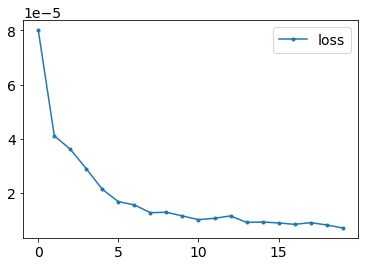

In [ ]:

res=2**6
numPE=1
grid_length = 2*np.pi
fine_grid_resolution = res
# 1d domain, so only 1 point along y dimension
fine_grid = grids.Grid(
    size_x=fine_grid_resolution, size_y=1, 
    step=grid_length/fine_grid_resolution
    )
x_fine, _ = fine_grid.get_mesh()
print(x_fine.shape)

CFL,u0,tend=0.08,1.,15.
dx=grid_length/len(x_fine)
dt=dx*CFL/abs(u0)
N_t=int(tend//dt)
time_steps=np.arange(N_t)
initS=[[1],[1],[0]]
data_ana=solution_data(initS[0],initS[1],initS[2],x_fine[:,0],N_t,dt)
'Create initial state from data'
initial_state=create_init_state_from_2d_data(data_ana,u0)

eq=adv1d(u=1.,timestep=dt)
model_new=myPseudoLinearModel(eq,fine_grid,initial_accuracy_order=1,num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5,
                              filters=32,constrained_accuracy_order=1,learned_keys = {'concentration_x'}, activation='relu',)
integrated_UT1 =integrate_func(model_new,initial_state,N_t) 

# model1=models.conv2d_stack(num_outputs=10,num_layers=5,filters=32, kernel_size=5,activation='relu')
model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                    num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
# integrated_UT1 = integrate.integrate_steps(model_new, initial_state, time_steps)

# integrate.integrate_steps(model_new, initial_state, time_steps)
# model_new(initial_state).shape

# num_ts=10
# tr_ot=[data_ana[n+1:n+1+num_ts] for n in range(data_ana.shape[0]-num_ts)]
# train_out=tf.expand_dims(tf.stack(tr_ot),-1)

ground_soln_dict=ground_dict_from_data(data_ana)
train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
# train_output.shape


model_new.compile(
    optimizer='adam', loss='mae'
    )
history = model_new.fit(
    train_input, train_output, epochs=20, batch_size=64, 
    verbose=1, shuffle=True
    )
df_history = pd.DataFrame(history.history)
df_history.plot(marker='.')
plt.show()

integrated_T1 =integrate_func(model_new,initial_state,N_t) 
# eq.METHOD

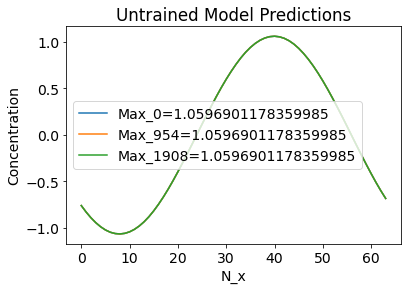

In [ ]:
plot_time_prop(integrated_UT1.numpy().squeeze(),0,N_t//2,N_t-1,'Untrained ')

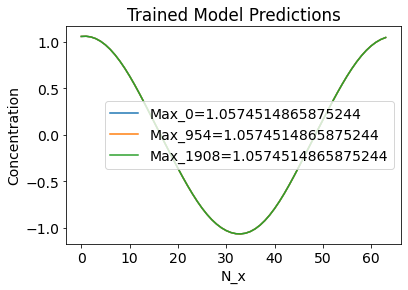

In [ ]:
plot_time_prop(integrated_T1.numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')

In [ ]:
# integrated_T1 =integrate_func(model_new,initial_state,N_t) 

In [ ]:
# integrated_T1

In [ ]:
# print(integrated_UT1.shape)
print(integrated_T1.shape)

(1909, 1, 64, 1)


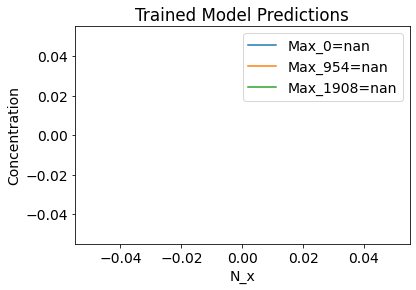

In [ ]:
plot_time_prop(integrated_T1.numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')

In [ ]:

'Training'


# 'Trained Evaluation'
# integrated_T1 = integrate.integrate_steps(model_new, initial_state, time_steps)
# plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')

concentration (1909, 1, 64, 1)
x_velocity (1909, 1, 64, 1)
y_velocity (1909, 1, 64, 1)

 train_input shape:
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)

 train_output shape: (1899, 10, 64, 1)


TensorShape([Dimension(1899), Dimension(10), Dimension(64), Dimension(1)])

# Extra

In [ ]:
time_steps

array([   0,    1,    2, ..., 1906, 1907, 1908])

In [ ]:
N_t

1909

In [ ]:
data_ana.shape

(1909, 64)

In [ ]:
x1=tf.random.normal((4,3))
x1

<tf.Tensor: id=5652, shape=(4, 3), dtype=float32, numpy=
array([[ 0.7845366 ,  0.6408813 ,  0.84214914],
       [ 0.7555685 , -0.5476298 , -1.2876854 ],
       [ 1.0618627 ,  0.8838861 ,  0.45848173],
       [-0.41089776, -0.22246045,  0.19069491]], dtype=float32)>

In [ ]:
y1=[x1[n+1:n+3] for n in range(x1.shape[0]-2)]


In [ ]:
data_ana.shape

(1909, 64)

In [ ]:
train_.shape

TensorShape([Dimension(1899), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
train_output.shape

TensorShape([Dimension(1899), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
# data_ana[12]

In [ ]:
# train_[1,9]

In [ ]:
# train_output[0]

In [ ]:
# train_output.shape

In [ ]:
# tensor_ops.extract_patches_2d(x1,(1,3))

## Other

In [ ]:
C=tf.random.normal([1,64,1])
C_x=tf.random.normal([1,64,1])
C.shape

TensorShape([Dimension(1), Dimension(64), Dimension(1)])

In [ ]:
C[0,5,0]+2*C_x[0,5,0]

<tf.Tensor: id=892, shape=(), dtype=float32, numpy=-4.59622>

In [ ]:
model_nn(initial_state).shape

TensorShape([Dimension(1), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
C+2*C_x

<tf.Tensor: id=881, shape=(1, 64, 1), dtype=float32, numpy=
array([[[-4.8519197 ],
        [ 1.5317459 ],
        [ 6.4321737 ],
        [-1.1136216 ],
        [ 3.1771643 ],
        [-4.59622   ],
        [ 2.5000083 ],
        [-2.360616  ],
        [ 1.6756575 ],
        [-1.0248947 ],
        [ 0.63709027],
        [-0.0526471 ],
        [-0.6731414 ],
        [ 3.2047815 ],
        [-0.12782848],
        [ 4.274591  ],
        [ 0.27686012],
        [ 1.4495835 ],
        [-1.9317409 ],
        [ 1.1848243 ],
        [-1.2650529 ],
        [-5.450883  ],
        [ 2.5511758 ],
        [-0.5686015 ],
        [ 3.5568252 ],
        [ 0.38146305],
        [-3.454869  ],
        [-2.9400244 ],
        [-2.295728  ],
        [ 1.4712894 ],
        [ 0.930304  ],
        [-1.7182789 ],
        [-2.5482135 ],
        [-0.5852704 ],
        [-3.1339984 ],
        [ 0.6543433 ],
        [-2.8173738 ],
        [ 0.08251542],
        [ 0.39510828],
        [ 3.8264875 ],
        [ 2.743671  

In [ ]:
print(type(model_nn.spatial_derivatives(initial_state)))
print(len(model_nn.spatial_derivatives(initial_state)))

<class 'dict'>
5


In [ ]:
for key,layer in model_nn.spatial_derivatives(initial_state).items():
  print(key,layer.shape)
print('\n')
print(model_nn.fixed_keys)
print('\n')
print(model_nn.learned_keys)

concentration_x (1, 64, 1)
concentration_y (1, 64, 1)
y_velocity (1, 64, 1)
concentration (1, 64, 1)
x_velocity (1, 64, 1)


{'y_velocity', 'concentration', 'x_velocity'}


{'concentration_x', 'concentration_y'}


In [ ]:
model_new._apply_model(initial_state)

{'concentration_x': <tf.Tensor: id=232, shape=(1, 64, 1), dtype=float32, numpy=
 array([[[ 0.9987244 ],
         [ 0.9891286 ],
         [ 0.97000694],
         [ 0.94148517],
         [ 0.9038912 ],
         [ 0.857653  ],
         [ 0.8031532 ],
         [ 0.74094665],
         [ 0.6715859 ],
         [ 0.59575963],
         [ 0.5141812 ],
         [ 0.42764813],
         [ 0.33699194],
         [ 0.24308077],
         [ 0.14681871],
         [ 0.04915363],
         [-0.04898063],
         [-0.14665642],
         [-0.24293627],
         [-0.33689013],
         [-0.4276013 ],
         [-0.51420486],
         [-0.59584147],
         [-0.6717381 ],
         [-0.7411705 ],
         [-0.8034521 ],
         [-0.8579818 ],
         [-0.9042061 ],
         [-0.94165814],
         [-0.97004986],
         [-0.98911697],
         [-0.9986806 ],
         [-0.99863815],
         [-0.9889947 ],
         [-0.9698718 ],
         [-0.9414687 ],
         [-0.9039649 ],
         [-0.85772806],
        

In [ ]:
model_new.spatial_derivatives(initial_state).keys()

dict_keys(['concentration_x', 'concentration'])

In [ ]:
# model_new(initial_state)

In [ ]:
for key,layer in model_new.spatial_derivatives(initial_state).items():
  print(key,layer.shape)
print('\n')
print(model_new.fixed_keys)
print('\n')
print(model_new.learned_keys)

UnimplementedError: ignored

In [ ]:
eq1=advection_equations.FiniteDifferenceAdvection(0.08)
print('\n')
print(model_new.fixed_keys)
print('\n')
print(model_new.learned_keys)



{'concentration'}


{'concentration_x'}


In [ ]:
a={'a':1}
a['b']=2
a

{'a': 1, 'b': 2}

## Model NN

In [ ]:

res=2**6
numPE=1
grid_length = 2*np.pi
fine_grid_resolution = res
# 1d domain, so only 1 point along y dimension
fine_grid = grids.Grid(
    size_x=fine_grid_resolution, size_y=1, 
    step=grid_length/fine_grid_resolution
    )
x_fine, _ = fine_grid.get_mesh()
print(x_fine.shape)

CFL,u0,tend=0.08,1.,15.
dx=grid_length/len(x_fine)
dt=dx*CFL/abs(u0)
N_t=int(tend//dt)
time_steps=np.arange(N_t)
initS=[[1],[1],[0]]
data_ana=solution_data(initS[0],initS[1],initS[2],x_fine[:,0],N_t,dt)
'Create initial state from data'
initial_state=create_init_state_from_2d_data(data_ana,u0)

eq=adv1d(u=1.,timestep=dt)
model_new=myPseudoLinearModel(eq,fine_grid,initial_accuracy_order=4,num_time_steps=10,stencil_size=5, kernel_size=(5,1), num_layers=5,
                              filters=32,constrained_accuracy_order=1,learned_keys = {'concentration_x'}, activation='relu',)
# model1=models.conv2d_stack(num_outputs=10,num_layers=5,filters=32, kernel_size=5,activation='relu')
model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                    num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
# integrated_UT1 = integrate.integrate_steps(model_new, initial_state, time_steps)
# model_new(initial_state)


# eq.METHOD

(64, 1)
concentration (1, 64, 1)
x_velocity (1, 64, 1)
y_velocity (1, 64, 1)


In [ ]:
# model_new(initial_state).shape
model_nn(initial_state).shape

TensorShape([Dimension(1), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
# m1=models.conv2d_stack(10)
m1=models.conv2d_stack(num_outputs = 52, num_layers=5, filters=32, kernel_size=(5,1),activation='relu')
m1(initial_state)

<tf.Tensor: id=248896, shape=(1, 64, 1, 52), dtype=float32, numpy=
array([[[[-0.04318703,  0.05679173, -0.01612784, ...,  0.02285251,
          -0.07625276,  0.08105466]],

        [[-0.04066245,  0.05989677, -0.01546579, ...,  0.02317052,
          -0.07551247,  0.08955614]],

        [[-0.03798689,  0.06292473, -0.01471325, ...,  0.02341055,
          -0.07673727,  0.09638999]],

        ...,

        [[-0.03284486,  0.03903769, -0.01294035, ...,  0.01320301,
          -0.06256963,  0.05702941]],

        [[-0.03952498,  0.04640746, -0.01597773, ...,  0.01711109,
          -0.06952607,  0.06689336]],

        [[-0.04369004,  0.05262476, -0.01491428, ...,  0.02160431,
          -0.07552485,  0.0753458 ]]]], dtype=float32)>

In [ ]:
len(model_new._apply_model(initial_state))

1

In [ ]:
model_new._apply_model(initial_state)['concentration_x'].shape

TensorShape([Dimension(1), Dimension(64), Dimension(1)])

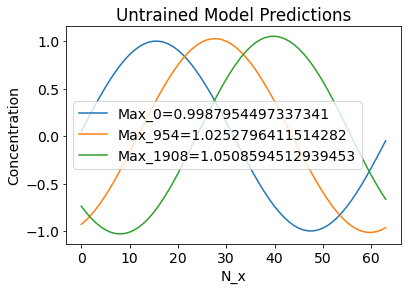

In [ ]:
plot_time_prop(integrated_UT1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Untrained ')


In [ ]:
model_nn.__call__(initial_state).shape

TensorShape([Dimension(1), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
model_new.call(initial_state)

ValueError: ignored

In [ ]:

'Training'
ground_soln_dict=ground_dict_from_data(data_ana)
train_input, train_output = make_train_data(ground_soln_dict,data_ana.shape[0]-1, 10)
train_output.shape

# model_new.compile(
#     optimizer='adam', loss='mae'
#     )
# history = model_new.fit(
#     train_input, train_output, epochs=20, batch_size=64, 
#     verbose=1, shuffle=True
#     )
# df_history = pd.DataFrame(history.history)
# df_history.plot(marker='.')
# plt.show()

# 'Trained Evaluation'
# integrated_T1 = integrate.integrate_steps(model_new, initial_state, time_steps)
# plot_time_prop(integrated_T1['concentration'].numpy().squeeze(),0,N_t//2,N_t-1,'Trained ')

concentration (1909, 1, 64, 1)
x_velocity (1909, 1, 64, 1)
y_velocity (1909, 1, 64, 1)

 train_input shape:
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)

 train_output shape: (1899, 10, 64, 1)


TensorShape([Dimension(1899), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
print(type(train_input))
print(len(train_input))
print(train_input.keys())
for key,tens in train_input.items():
  print(key,tens.shape)
# train_input['concentration']
# train_input['y_velocity'][50]

<class 'dict'>
3
dict_keys(['concentration', 'x_velocity', 'y_velocity'])
concentration (1899, 64, 1)
x_velocity (1899, 64, 1)
y_velocity (1899, 64, 1)


## Old Important trials

In [ ]:

cnn_out_to_diff(x=x,state=initial_state,eq=eq,stencil_size=5,total_acc=4,constr_acc=1,grid=fine_grid)

In [ ]:
[1,2,3,4][1:2]

In [ ]:
ol=models.build_output_layers(equation=eq_nn, grid=fine_grid, learned_keys={'concentration_x'}, stencil_size=5, initial_accuracy_order=4
                    ,constrained_accuracy_order=1, layer_cls=models.VaryingCoefficientsLayer,
                    predict_permutations=True)

In [ ]:

for k,l in ol.items():
  print(k)

concentration_x


In [ ]:
net_out.shape

TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(6)])

In [ ]:
ol=models.build_output_layers(equation=eq_nn, grid=fine_grid, learned_keys={'concentration_x','concentration_y'}, stencil_size=3, initial_accuracy_order=1
                    ,constrained_accuracy_order=1, layer_cls=models.VaryingCoefficientsLayer,
                    predict_permutations=True)
model1=models.conv2d_stack(num_outputs=6,num_layers=5,filters=32, kernel_size=(3,1),activation='relu')
net_out=model1(initial_state)
for k,l in ol.items():
  print(l([net_out, initial_state['concentration']]).shape)

(1, 64, 1)
(1, 64, 1)


In [ ]:
fine_grid.step

In [ ]:
dx

In [ ]:
x=tf.random.normal([1,64,1,1])
def cnn_out_to_diff(x,eq,stencil_size,total_acc,constr_acc,grid):
  parent=eq.find_base_key('concentration_x')
  kdef=eq.key_definitions['concentration_x']
  pardef=eq.key_definitions[parent]
  sten=models.build_stencils(kdef, pardef, 5, 2.)
  # x=tf.random.normal([1,64,1,3])
  '1st grid step matters 2nd doesnt'
  pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 4)
sten=[np.array([-2,-1.,0. ,1.,2])*0.5]
# 0.5 is dx here
deriv_ls=[1]
met=polynomials.Method.FINITE_DIFFERENCE
pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=3,bias_accuracy_order = 4)
# pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 4,grid_step=1000)
# pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 4,grid_step=0)
coeff_=pa(x)
coeff_.shape
# fn_=tensor_ops.extract_patches_2d(initial_state['concentration'],(5,1),[0,0])
# coeff=tf.squeeze(coeff_)
# coeff_.shape
# fn_.shape
# tf.einsum('bxys,bxys->bxy', coeff_, fn_).shape

TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(5)])

## Create Custom Poly Acc layer

In [ ]:
dt

0.007853981633974483

In [ ]:
eq1=advection_equations.FiniteDifferenceAdvection(0.08)
# eq.METHOD

# adv1d has no cfl input?
eq=adv1d(u=1.,timestep=dt)
eq.METHOD

<Method.FINITE_DIFFERENCE: 1>

In [ ]:
# eq.find_base_key('concentrationknlkn')
# eq.find_base_key('concentration_knlkn')
parent=eq.find_base_key('concentration_x')
kdef=eq.key_definitions['concentration_x']
pardef=eq.key_definitions[parent]
stc=models.build_stencils(kdef, pardef, 5, 2.)

In [ ]:

stc

[array([-4., -2.,  0.,  2.,  4.]), array([-4., -2.,  0.,  2.,  4.])]

In [ ]:
fine_grid.step

0.09817477042468103

In [ ]:
[k - p for p, k in zip(pardef.offset, kdef.offset)]

[0, 0]

(1, 0)

In [ ]:
polynomials.constraint_layer(stc,eq.METHOD,kdef.derivative_orders[:2],1,2,fine_grid.step)

In [ ]:
model_nn.learned_keys

{'concentration_x', 'concentration_y'}

In [ ]:
eq1

In [ ]:
initial_state['concentration'].shape

(1, 64, 1)

In [ ]:
eq1.all_keys

{'concentration',
 'concentration_x',
 'concentration_y',
 'x_velocity',
 'y_velocity'}

In [ ]:
x=tf.random.normal([1,64,1,3])
'1st grid step matters 2nd doesnt'
sten=[np.array([-2,-1.,0. ,1.,2])*0.5]
# 0.5 is dx here
deriv_ls=[1]
met=polynomials.Method.FINITE_DIFFERENCE
pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 4)
# pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 4,grid_step=1000)
# pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 4,grid_step=0)
coeff_=pa(x)
coeff_.shape
# fn_=tensor_ops.extract_patches_2d(initial_state['concentration'],(5,1),[0,0])
# coeff=tf.squeeze(coeff_)
# coeff_.shape
# fn_.shape
# tf.einsum('bxys,bxys->bxy', coeff_, fn_).shape

TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(5)])

TensorShape([Dimension(1), Dimension(64), Dimension(1)])

In [ ]:
initial_state['concentration'][0][:5]

array([[0.04906768],
       [0.14673047],
       [0.24298018],
       [0.33688986],
       [0.42755508]], dtype=float32)

In [ ]:

vcl=models.VaryingCoefficientsLayer(pa,sten,[0],'concentration')
vcl(x)

In [ ]:
ol=models.build_output_layers(equation=eq, grid=fine_grid, learned_keys={'concentration_x'}, stencil_size=5, initial_accuracy_order=4
                    ,constrained_accuracy_order=1, layer_cls=models.VaryingCoefficientsLayer,
                    predict_permutations=True)
print([layer.kernel_size for layer in ol.values()])

[22]


In [ ]:
x=tf.random.normal([1,64,1,22])
for k,layer in ol.items():
  print(layer([x, initial_state['concentration']]))
  # print(k,layer)

InvalidArgumentError: ignored

In [ ]:
class myPseudoLinear(models.SpatialDerivativeModel):
  """Learn pseudo-linear filters for spatial derivatives."""

  def __init__(self, equation, grid, stencil_size=5, initial_accuracy_order=2,constrained_accuracy_order=1, learned_keys=None,
               fixed_keys=None, core_model_func=models.conv2d_stack,num_time_steps=1, geometric_transforms=None,
               predict_permutations=True,target=None,name='pseudo_linear_model', **kwargs):
    """Initialize class.
    Args:
      core_model_func: callable (function or class object). It should return a Keras model (or layer) instance, which contains trainable weights.
        The returned core_model instance should take a dict of tensors as input
        (see the call() method in the base TimeStepModel class).
        Additional kwargs are passed to this callable to specify hyperparameters
        of core_model (such as number of layers and convolutional filters).
    """

    super().__init__(equation, grid, num_time_steps, target, name)

    self.learned_keys, self.fixed_keys = (models.normalize_learned_and_fixed_keys(learned_keys, fixed_keys, equation))

    self.polyacc=polynomials.PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=constrained_accuracy_order ,bias_accuracy_order = initial_accuracy_order)

    # self.output_layers = models.build_output_layers(equation, grid, self.learned_keys, stencil_size, initial_accuracy_order,
    #                                          constrained_accuracy_order, layer_cls=models.VaryingCoefficientsLayer,
    #                                          predict_permutations=predict_permutations)

    # self.fd_model = models.FiniteDifferenceModel(equation, grid, initial_accuracy_order)

    # self.geometric_transforms = geometric_transforms or [geometry.Identity()]
    self.num_outputs=initial_accuracy_order-constrained_accuracy_order
    # num_outputs = sum(layer.kernel_size for layer in self.output_layers.values())
    self.core_model = core_model_func(self.num_outputs, **kwargs)

  def _apply_model(self, state):
    net = self.core_model(state)

    # size_splits = [self.output_layers[key].kernel_size for key in self.output_layers]
    # heads = tf.split(net, size_splits, axis=-1)
    
    result={}
    
    
    # result = {}
    # for (key, layer), head in zip(self.output_layers.items(), heads):
    #   input_tensor = state[layer.input_key]
    #   result[key] = layer([head, input_tensor])

    # return result
    return net

  # def spatial_derivatives(self, inputs):
  #   """See base class."""
  #   result = models.average_over_transforms(self._apply_model, self.geometric_transforms, inputs)
  #   if self.fixed_keys:
  #     result.update(self.fd_model.spatial_derivatives(inputs, self.fixed_keys))
  #   return result


model_nn = myPseudoLinear(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=2,
                                    num_time_steps=10,stencil_size=5, kernel_size=(5,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
model_nn._apply_model(initial_state)

<tf.Tensor: id=355757, shape=(1, 64, 1, 56), dtype=float32, numpy=
array([[[[-0.02409362, -0.07265262,  0.00679261, ...,  0.06090643,
          -0.08190176, -0.0449761 ]],

        [[-0.0239966 , -0.07664052,  0.00602177, ...,  0.0557516 ,
          -0.08161802, -0.04391564]],

        [[-0.02282128, -0.07948752,  0.00380843, ...,  0.05209965,
          -0.08141782, -0.04025207]],

        ...,

        [[-0.02854399, -0.05719436,  0.01049389, ...,  0.08256464,
          -0.08077292, -0.04455323]],

        [[-0.02844786, -0.06260958,  0.01047198, ...,  0.07427159,
          -0.08342962, -0.04675319]],

        [[-0.02613103, -0.06816138,  0.00850751, ...,  0.06747038,
          -0.08367244, -0.04539395]]]], dtype=float32)>

In [ ]:
def conv2d_stack(num_outputs, num_layers=5, filters=32, kernel_size=5,
                 activation='relu', **kwargs):
  """Create a sequence of Conv2DPeriodic layers."""
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Lambda(stack_dict))
  for _ in range(num_layers - 1):
    layer = models.Conv2DPeriodic(
        filters, kernel_size, activation=activation, **kwargs)
    model.add(layer)
  model.add(models.Conv2DPeriodic(num_outputs, kernel_size, **kwargs))
  return model

NameError: ignored

In [ ]:
# c1=models.conv2d_stack(56)
# c1(initial_state)

coreModel = models.conv2d_stack(num_outputs = 52, num_layers=5, filters=32, kernel_size=3,activation='relu')
print(coreModel(initial_state).shape)

(1, 64, 1, 52)


In [ ]:
from typing import Any, Iterator, Optional, Sequence, Tuple
import enum
class Method(enum.Enum):
  """Discretization method."""
  FINITE_DIFFERENCE = 1
  FINITE_VOLUME = 2
class PolynomialAccuracy(tf.keras.layers.Layer):
  def __init__(self,stencils: Sequence[np.ndarray],method: Method,derivative_orders: Sequence[int],accuracy_order: int = 1,
               bias_accuracy_order: Optional[int] = 2,grid_step: float = None,bias: np.ndarray = None,dtype: Any = np.float32,):

    A, b = polynomials.constraints(stencils, method, derivative_orders, accuracy_order, grid_step)

    if bias is None:
      bias_grid = polynomials.coefficients(stencils, method, derivative_orders,bias_accuracy_order,grid_step)
      bias = bias_grid.ravel()

    norm = np.linalg.norm(np.dot(A, bias) - b)
    if norm > 1e-8:
      raise ValueError('invalid bias, not in nullspace')
    # https://en.wikipedia.org/wiki/Kernel_(linear_algebra)#Nonhomogeneous_systems_of_linear_equations
    _, _, v = np.linalg.svd(A)
    input_size = A.shape[1] - A.shape[0]
    if not input_size:
      raise ValueError(  # pylint: disable=g-doc-exception
          'there is only one valid solution accurate to this order')

    # nullspace from the SVD is always normalized such that its singular values
    # are 1 or 0, which means it's actually independent of the grid spacing.
    nullspace = v[-input_size:]
    # nullspace /= (grid_step**np.array(derivative_orders)).prod()

    self.input_size = input_size
    self.output_size = b.size
    self.nullspace = tf.convert_to_tensor(nullspace, dtype)
    self.bias = tf.convert_to_tensor(bias, dtype)

    super().__init__(trainable=False, dtype=dtype)

  def compute_output_shape(self, input_shape):
    return input_shape[:-1] + (self.output_size,)

  def call(self, x: tf.Tensor) -> tf.Tensor:
    # TODO(geraschenko): explore projecting out the nullspace from full rank
    # inputs instead.
    return self.bias + tf.tensordot(x, self.nullspace, axes=[-1, 0])

In [ ]:
x=tf.random.normal([1,64,1,1])
sten=[np.array([-1.,0. ,1.])]
deriv_ls=[1]
met=polynomials.Method.FINITE_DIFFERENCE
pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=1,bias_accuracy_order = 2)
pa(x).shape

TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(3)])

In [ ]:
pa(x).shape

TensorShape([Dimension(1), Dimension(64), Dimension(1), Dimension(3)])

In [ ]:
sten[0].size

3

In [ ]:
x1=tf.random.normal([64,1])

In [ ]:
x1[0:5]

<tf.Tensor: id=9743, shape=(5, 1), dtype=float32, numpy=
array([[ 0.23986126],
       [-0.27079737],
       [ 0.0665032 ],
       [-0.3504073 ],
       [-0.10848822]], dtype=float32)>

In [ ]:
tensor_ops.extract_patches_2d(x1,(3,1),[0,0])

<tf.Tensor: id=9739, shape=(64, 1, 3), dtype=float32, numpy=
array([[[ 0.9785932 ,  0.23986126, -0.27079737]],

       [[ 0.23986126, -0.27079737,  0.0665032 ]],

       [[-0.27079737,  0.0665032 , -0.3504073 ]],

       [[ 0.0665032 , -0.3504073 , -0.10848822]],

       [[-0.3504073 , -0.10848822,  0.3728615 ]],

       [[-0.10848822,  0.3728615 , -0.74167466]],

       [[ 0.3728615 , -0.74167466,  0.87641513]],

       [[-0.74167466,  0.87641513, -1.3101739 ]],

       [[ 0.87641513, -1.3101739 , -0.6633319 ]],

       [[-1.3101739 , -0.6633319 , -0.8992759 ]],

       [[-0.6633319 , -0.8992759 ,  0.48382887]],

       [[-0.8992759 ,  0.48382887, -0.89950347]],

       [[ 0.48382887, -0.89950347, -2.0493016 ]],

       [[-0.89950347, -2.0493016 , -1.528964  ]],

       [[-2.0493016 , -1.528964  ,  0.20724452]],

       [[-1.528964  ,  0.20724452,  1.0501851 ]],

       [[ 0.20724452,  1.0501851 , -0.1453674 ]],

       [[ 1.0501851 , -0.1453674 , -1.8612638 ]],

       [[-0.1453674 ,

In [ ]:
vcl=models.VaryingCoefficientsLayer(pa,sten,[0],'concentration')
vcl(x)

In [ ]:
x=tf.random.normal([1,64,1,3])
sten=[np.array([-2,-1.,0. ,1.,2])]
deriv_ls=[1]
met=polynomials.Method.FINITE_DIFFERENCE
pa=PolynomialAccuracy(sten,met,deriv_ls,accuracy_order=3,bias_accuracy_order = 4)
pa(x).shape

InvalidArgumentError: ignored

## Constraint

In [ ]:
sten=[np.array([-1.,0. ,1.])]
deriv=1
met=polynomials.Method.FINITE_DIFFERENCE
for acc in range(1,3):
  print(f'This is constrained acc order = {acc}')
  print(f'No. of rows is {deriv}(deriv)+{acc}(acc) = {deriv+acc}')
  A,b=polynomials.constraints(accuracy_order=acc,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[1],stencils=sten,grid_step=0.25)
  print(f'A is {A}\n')
  print(f'b is {b}\n \n')

This is constrained acc order = 1
No. of rows is 1(deriv)+1(acc) = 2
A is [[-1.  0.  1.]
 [ 1.  1.  1.]]

b is [1. 0.]
 

This is constrained acc order = 2
No. of rows is 1(deriv)+2(acc) = 3
A is [[-1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]]

b is [1. 0. 0.]
 



In [ ]:
sten=[np.array([-2,-1.,0. ,1.,2])]
deriv=1
for acc in range(1,5):
  print(f'This is constrained acc order = {acc}')
  print(f'No. of rows is {deriv}(deriv)+{acc}(acc) = {deriv+acc}')
  A,b=polynomials.constraints(accuracy_order=acc,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[1],stencils=sten,grid_step=0.25)
  print(f'A is {A}\n')
  print(f'b is {b}\n \n')

This is constrained acc order = 1
No. of rows is 1(deriv)+1(acc) = 2
A is [[-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]]

b is [1. 0.]
 

This is constrained acc order = 2
No. of rows is 1(deriv)+2(acc) = 3
A is [[-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]
 [ 4.  1.  0.  1.  4.]]

b is [1. 0. 0.]
 

This is constrained acc order = 3
No. of rows is 1(deriv)+3(acc) = 4
A is [[-8. -1.  0.  1.  8.]
 [-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]
 [ 4.  1.  0.  1.  4.]]

b is [0. 1. 0. 0.]
 

This is constrained acc order = 4
No. of rows is 1(deriv)+4(acc) = 5
A is [[-8. -1.  0.  1.  8.]
 [-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]
 [ 4.  1.  0.  1.  4.]
 [16.  1.  0.  1. 16.]]

b is [0. 1. 0. 0. 0.]
 



In [ ]:
sten=[np.array([-1.,0. ,1.])]
deriv=2
for acc in range(1,3):
  print(f'This is constrained acc order = {acc}')
  print(f'No. of rows is {deriv}(deriv)+{acc}(acc) = {deriv+acc}')
  A,b=polynomials.constraints(accuracy_order=acc,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[deriv],stencils=sten,grid_step=0.25)
  print(f'A is {A}\n')
  print(f'b is {b}\n \n')

This is constrained acc order = 1
No. of rows is 2(deriv)+1(acc) = 3
A is [[-1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]]

b is [0. 2. 0.]
 

This is constrained acc order = 2
No. of rows is 2(deriv)+2(acc) = 4
A is [[-1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]]

b is [0. 2. 0.]
 



## Coefficient function

In [ ]:
sten=[np.array([-2,-1.,0. ,1.,2])]
for gd in [0.25,0.5,1.5]:
  coeff = polynomials.coefficients(sten, polynomials.Method.FINITE_DIFFERENCE,[2],grid_step=gd)
  print(coeff)

[-0.08333333  1.33333333 -2.5         1.33333333 -0.08333333]
[-0.08333333  1.33333333 -2.5         1.33333333 -0.08333333]
[-0.08333333  1.33333333 -2.5         1.33333333 -0.08333333]


In [ ]:
p=np.array([2])
2**p

array([4])

In [ ]:
a=tf.convert_to_tensor(np.arange(12).reshape(3,4))
print(a)
b=tf.convert_to_tensor(np.arange(20).reshape(4,5))
print(b)
print(a@b)
print(tf.tensordot(a,b,axes=[-1, 0]))

tf.Tensor(
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]], shape=(3, 4), dtype=int64)
tf.Tensor(
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]], shape=(4, 5), dtype=int64)
tf.Tensor(
[[ 70  76  82  88  94]
 [190 212 234 256 278]
 [310 348 386 424 462]], shape=(3, 5), dtype=int64)
tf.Tensor(
[[ 70  76  82  88  94]
 [190 212 234 256 278]
 [310 348 386 424 462]], shape=(3, 5), dtype=int64)


In [ ]:
a=tf.random.normal([3,4])
print(a)
b=tf.convert_to_tensor(np.arange(20.).reshape(4,5),dtype=tf.float32)
print(b)
print(a@b)
print(tf.tensordot(a,b,axes=[-1, 0]))

tf.Tensor(
[[-0.23892407  0.11206634 -0.3930344   1.3621991 ]
 [-0.96918243  0.8720763   1.5442923   0.03735123]
 [ 0.76392263 -0.23340526 -0.55307394 -1.4784018 ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[ 0.  1.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [10. 11. 12. 13. 14.]
 [15. 16. 17. 18. 19.]], shape=(4, 5), dtype=float32)
tf.Tensor(
[[ 17.062975  17.905281  18.747587  19.589895  20.432201]
 [ 20.363573  21.84811   23.33265   24.817184  26.301722]
 [-28.873793 -30.37475  -31.87571  -33.376667 -34.877625]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[ 17.062975  17.905281  18.747587  19.589895  20.432201]
 [ 20.363573  21.84811   23.33265   24.817184  26.301722]
 [-28.873793 -30.37475  -31.87571  -33.376667 -34.877625]], shape=(3, 5), dtype=float32)


In [ ]:
sten=[np.array([-2,-1.,0. ,1.,2])]
deriv=1
for acc in range(1,5):
  print(f'This is constrained acc order = {acc}')
  print(f'No. of rows is {deriv}(deriv)+{acc}(acc) = {deriv+acc}')
  A,b=polynomials.constraints(accuracy_order=acc,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[1],stencils=sten,grid_step=0.25)
  coeff = polynomials.coefficients(sten, polynomials.Method.FINITE_DIFFERENCE,[deriv],grid_step=0.25)
  print(f'coeff is {coeff} \n')
  print(f'A is {A}\n')
  print(f'b is {b}\n')
  print(A@coeff -b)
  print('\n \n')

This is constrained acc order = 1
No. of rows is 1(deriv)+1(acc) = 2
coeff is [ 0.08333333 -0.66666667  0.          0.66666667 -0.08333333] 

A is [[-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]]

b is [1. 0.]

[-1.11022302e-16  0.00000000e+00]

 

This is constrained acc order = 2
No. of rows is 1(deriv)+2(acc) = 3
coeff is [ 0.08333333 -0.66666667  0.          0.66666667 -0.08333333] 

A is [[-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]
 [ 4.  1.  0.  1.  4.]]

b is [1. 0. 0.]

[-1.11022302e-16  0.00000000e+00  0.00000000e+00]

 

This is constrained acc order = 3
No. of rows is 1(deriv)+3(acc) = 4
coeff is [ 0.08333333 -0.66666667  0.          0.66666667 -0.08333333] 

A is [[-8. -1.  0.  1.  8.]
 [-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]
 [ 4.  1.  0.  1.  4.]]

b is [0. 1. 0. 0.]

[ 0.00000000e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00]

 

This is constrained acc order = 4
No. of rows is 1(deriv)+4(acc) = 5
coeff is [ 0.08333333 -0.66666667  0.          0.66666667 -0.083

In [ ]:
sten=[np.array([-1.,0. ,1.])]
for acc in range(1,3):
  print('This is constrained acc order')
  A,b=polynomials.constraints(accuracy_order=acc,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[1],stencils=sten,grid_step=0.25)
# coeff = polynomials.coefficients(sten, polynomials.Method.FINITE_DIFFERENCE,[1],grid_step=0.25)
# print(f'coeff are {np.squeeze(coeff)}\n')
# norm = np.linalg.norm(np.dot(A, coeff.flatten()) - b)
# print(f'Norm is {norm}')
  print(f'A is {A}\n')
  print(f'b is {b}\n')
# coff_solve=np.linalg.solve(A,b)
# print(f'x=AinvB=x={coff_solve}\n')

# _, _, v = np.linalg.svd(A)
# print(f'v is {v}\n')


This is constrained acc order
A is [[-1.  0.  1.]
 [ 1.  1.  1.]]

b is [1. 0.]

This is constrained acc order
A is [[-1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]]

b is [1. 0. 0.]



In [ ]:
if 1.2:
  print('Hello')

Hello


In [ ]:
polynomials.coefficients(sten, polynomials.Method.FINITE_DIFFERENCE,[1],grid_step=0.25)

array([-0.5,  0. ,  0.5])

In [ ]:
bias_grid = coefficients(stencils, method, derivative_orders,bias_accuracy_order, grid_step)

In [ ]:
x=tf.random.normal([1,64,1,3])

sten=[np.array([-1.,0. ,1.]),np.array([-1.,0. ,1.])]
fd=polynomials.Method.FINITE_DIFFERENCE
deriv=[1,0]
poly_layer=polynomials.PolynomialAccuracy(stencils=sten,method=fd,derivative_orders=deriv,accuracy_order=1,grid_step=0.5)
poly_layer(x)

InvalidArgumentError: ignored

InvalidArgumentError: ignored

TypeError: ignored


# Pol Acc

In [ ]:
A = np.matrix([[1,3], [1,2], [1, -1], [2,1]])
rank = np.linalg.matrix_rank(A)
# U, s, V = np.linalg.svd(A, full_matrices = True)
U, s, V = np.linalg.svd(A, full_matrices = False)
print(f"rank is {rank}\n")
print(f'U shape is is {U.shape}\n')
print(f'Sigma shape is {s.shape}\n')
print(f'V shape is {V.shape}\n')

# t_U_A = np.transpose(U)
# nrow = t_U_A.shape[0]
# left_null_A = t_U_A[rank:nrow,:]
# left_null_A
# np.dot((left_null_A[0,:] + left_null_A[0,:]), A)



rank is 2

U shape is is (4, 2)

Sigma shape is (2,)

V shape is (2, 2)



In [ ]:
not 5

False

In [ ]:
not 0

True

In [ ]:
snew=np.zeros((4,2))
snew[0,0]=s[0]
snew[1,1]=s[1]
snew

array([[4.26744684, 0.        ],
       [0.        , 1.94650904],
       [0.        , 0.        ],
       [0.        , 0.        ]])

In [ ]:
U@snew@V

matrix([[ 1.,  3.],
        [ 1.,  2.],
        [ 1., -1.],
        [ 2.,  1.]])

In [ ]:

# Right null:

B = np.transpose(A)
rank = np.linalg.matrix_rank(B)
U, s, V = np.linalg.svd(B, full_matrices = True)
t_V_B = np.transpose(V)
ncols = t_V_B.shape[1]
right_null_B = t_V_B[:,rank:ncols]
right_null_B
np.dot(B, (right_null_B[:,0] + right_null_B[:,1]))

In [ ]:
FINITE_DIFF = polynomials.Method.FINITE_DIFFERENCE
stencil=[-1, 0, 1]
coeff = polynomials.coefficients([np.array(stencil)], FINITE_DIFF,[1])
coeff

array([-0.5,  0. ,  0.5])

In [ ]:
# a, b = polynomials.constraints([np.array([-0.5, 0.5])],method,derivative_orders=[0],accuracy_order=accuracy_order,grid_step=1.0)

In [ ]:
sten=[np.array([-2,-1.,0. ,1.,2.])]
A,b=polynomials.constraints(accuracy_order=2,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[1],stencils=sten,grid_step=0.25)
coeff = polynomials.coefficients(sten, FINITE_DIFF,[1],grid_step=0.25)
print(f'coeff are {np.squeeze(coeff)}\n')
norm = np.linalg.norm(np.dot(A, coeff.flatten()) - b)
print(f'Norm is {norm}')
print(f'A is {A}\n')
print(f'b is {b}\n')
coff_solve=np.linalg.solve(A,b)
print(f'x=AinvB=x={coff_solve}\n')

_, _, v = np.linalg.svd(A)
print(f'v is {v}\n')

coeff are [ 0.08333333 -0.66666667  0.          0.66666667 -0.08333333]

Norm is 1.1102230246251565e-16
A is [[-2. -1.  0.  1.  2.]
 [ 1.  1.  1.  1.  1.]
 [ 4.  1.  0.  1.  4.]]

b is [1. 0. 0.]



LinAlgError: ignored

In [ ]:
sten=[np.array([-1.,0.,1.]),np.array([0])]
A,b=polynomials.constraints(accuracy_order=2,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[1,0], stencils= sten )
coeff = polynomials.coefficients(sten, FINITE_DIFF,derivative_orders=[1,0],grid_step=0.25)
_, _, v = np.linalg.svd(A)
# print(f'v is {v}\n')
print(f'coeff are {np.squeeze(coeff)}')
print(f'A is {A}')
print(f'b is {b}')
norm = np.linalg.norm(np.dot(A, coeff.flatten()) - b)
print(f'Norm is {norm}')
# coff_solve=np.linalg.solve(A,b)
# print(f'x=AinvB=x={coff_solve}')
coeff.ravel()

coeff are [-0.5  0.   0.5]
A is [[-1.  0.  1.]
 [ 0.  0.  0.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]]
b is [1. 0. 0. 0.]
Norm is 0.0


array([-0.5,  0. ,  0.5])

In [ ]:
coeff

array([-0.5,  0. ,  0.5])

In [ ]:
2**coeff

array([0.70710678, 1.        , 1.41421356])

In [ ]:
sten=[np.array([-0.5 ,0.5]),np.array([-0.5 ,0.5])]
A,b=polynomials.constraints(accuracy_order=2,method=polynomials.Method.FINITE_DIFFERENCE,derivative_orders=[0,0], stencils= sten )
coeff = polynomials.coefficients(sten, FINITE_DIFF,derivative_orders=[0,0])
print(f'coeff are {np.squeeze(coeff)}')
print(f'A is {A}')
print(f'b is {b}')
norm = np.linalg.norm(np.dot(A, coeff.flatten()) - b)
print(f'Norm is {norm}')

coeff are [[0.25 0.25]
 [0.25 0.25]]
A is [[-0.5 -0.5  0.5  0.5]
 [-0.5  0.5 -0.5  0.5]
 [ 1.   1.   1.   1. ]]
b is [0. 0. 1.]
Norm is 0.0


In [ ]:
np.dot(A, np.squeeze(coeff))

ValueError: ignored

In [ ]:
A.shape

(3, 4)

In [ ]:
coeff.flatten().shape

(4,)

In [ ]:
print(A@(coeff.flatten()))

[0. 0. 1.]


In [ ]:
print(A.dot([4 / 10, 1 / 10, 1 / 10, 4 / 10]))

[0. 0. 1.]


In [ ]:
[1,2,3,4]*2

[1, 2, 3, 4, 1, 2, 3, 4]

# Results

## Define & Initialize NN model

In [ ]:
res=2**6
numPE=1
grid_length = 2*np.pi
fine_grid_resolution = res
# 1d domain, so only 1 point along y dimension
fine_grid = grids.Grid(
    size_x=fine_grid_resolution, size_y=1, 
    step=grid_length/fine_grid_resolution
    )
x_fine, _ = fine_grid.get_mesh()
print(x_fine.shape)

CFL,u0,tend=0.08,1.,15.
dx=grid_length/len(x_fine)
dt=dx*CFL/abs(u0)
N_t=int(tend//dt)
time_steps=np.arange(N_t)
initS=[[1],[1],[0]]
data_ana=solution_data(initS[0],initS[1],initS[2],x_fine[:,0],N_t,dt)
'Create initial state from data'
initial_state=create_init_state_from_2d_data(data_ana,u0)
# model1=models.conv2d_stack(num_outputs=10,num_layers=5,filters=32, kernel_size=5,activation='relu')
model_nn = models.PseudoLinearModel(advection_equations.FiniteDifferenceAdvection(0.08), fine_grid,initial_accuracy_order=1,
                                    num_time_steps=10,stencil_size=3, kernel_size=(3,1), num_layers=5, filters=32,constrained_accuracy_order=1,
                                    learned_keys = {'concentration_x', 'concentration_y'}, activation='relu',) 
# integrated_UT1 = integrate.integrate_steps(model_nn, initial_state, time_steps)
model_nn(initial_state).shape

(64, 1)
concentration (1, 64, 1)
x_velocity (1, 64, 1)
y_velocity (1, 64, 1)


TensorShape([Dimension(1), Dimension(10), Dimension(64), Dimension(1)])

In [ ]:
print('Input to model_nn is dict initial_state \n with keys conc, x-vel y-vel') 
print(initial_state['concentration'].shape)
print('The _apply_model method outputs \n delc/dex array \n & \n delc/dey array')
print(model_nn._apply_model(initial_state).keys())
print(list(model_nn._apply_model(initial_state).values())[0].shape)
print(list(model_nn._apply_model(initial_state).values())[1].shape)

print(integrated_UT1['concentration'].shape)
'First analyze method _apply_model of PseudoLinearMode Class'
'Analyze core_model_func i.e. conv_2d_stack'

from typing import (
    Any, Dict, List, Optional, Mapping, Set, TypeVar, Tuple, Union,
)
T = TypeVar('T')
def sorted_values(x: Dict[Any, T]) -> List[T]:
  """Returns the sorted values of a dictionary."""
  return [x[k] for k in sorted(x)]

def stack_dict(state: Dict[Any, tf.Tensor]) -> tf.Tensor:
  """Stack a dict of tensors along its last axis."""
  return tf.stack(sorted_values(state), axis=-1)
  
def conv2d_stack(num_outputs, num_layers=5, filters=32, kernel_size=5,
                 activation='relu', **kwargs):
  """Create a sequence of Conv2DPeriodic layers."""
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Lambda(stack_dict))
  for _ in range(num_layers - 1):
    layer = models.Conv2DPeriodic(
        filters, kernel_size, activation=activation, **kwargs)
    model.add(layer)
  model.add(models.Conv2DPeriodic(num_outputs, kernel_size, **kwargs))
  return model


  'Check function sorted_values'
  dc={'ab':456,'xy':1,'rt':1234}
  print(dc)
  print(sorted_values(dc))

'Check function stack_dict'
stack_ls=stack_dict(initial_state)
print(stack_dict(initial_state).shape)
'''Stacks initial_state concen,x-vel,y-vel in alphabetical order
along last axis'''
stack_dict(initial_state)[...,2].shape
'Check function entire conv2d_stack'
for i in range(20):
  coreModel = conv2d_stack(num_outputs = 3, num_layers=5, filters=32, kernel_size=3,
                  activation='relu')
  print(coreModel(initial_state).shape)
def conv2d_stack(num_outputs, num_layers=5, filters=32, kernel_size=5,
                 activation='relu', **kwargs):
  """Create a sequence of Conv2DPeriodic layers."""
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Lambda(stack_dict))
  for _ in range(num_layers - 1):
    layer = models.Conv2DPeriodic(
        filters, kernel_size, activation=activation, **kwargs)
    model.add(layer)
  model.add(models.Conv2DPeriodic(num_outputs, kernel_size, **kwargs))
  return model
m1 = tf.keras.Sequential()
print(type(m1(initial_state)))
m1.add(tf.keras.layers.Lambda(stack_dict))
print(type(m1(initial_state)))
print(m1(initial_state).shape)
# layer1=models.Conv2DPeriodic(filters=9, kernel_size=(3.1), activation='relu')
layer1= tf.keras.layers.Conv2D(filters=9, kernel_size=(7,1), activation='relu')
m1.add(layer1)
print(m1(initial_state).shape)
'Analyze Conv2dPeriodic class '
in_sh=stack_ls.shape
print(in_sh)
print(in_sh[:-1]+(9,)) # For 9 filters used in convolution
stack_ls.shape
stack_ls[0,:,0,2]
# tensor_ops.pad_periodic_2d(stack_ls,))
padded_=tensor_ops._pad_periodic_by_axis(stack_ls, [1, 1],1)
print(padded_.shape)
padded_[0,:,0,2]

Input to model_nn is dict initial_state 
 with keys conc, x-vel y-vel
(1, 64, 1)
The _apply_model method outputs 
 delc/dex array 
 & 
 delc/dey array
dict_keys(['concentration_x', 'concentration_y'])
(1, 64, 1)
(1, 64, 1)
(1909, 1, 64, 1)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
(1, 64, 1, 3)
<class 'dict'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 64, 1, 3)
(1, 58, 1, 9)
(1, 64, 1, 3)
(1, 64, 1, 9)
(1, 66, 1, 3)


<tf.Tensor: id=356592, shape=(66,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

## Post convolution

In [ ]:
print(model_nn.learned_keys)
print(model_nn.fixed_keys)
l,f=(models.normalize_learned_and_fixed_keys(model_nn.learned_keys, model_nn.fixed_keys,advection_equations.FiniteDifferenceAdvection(0.08)))
print(l)
print(f)
coreModel = conv2d_stack(num_outputs = 12, num_layers=5, filters=32, kernel_size=3,activation='relu')
print(coreModel(initial_state).shape)
for stenc in [11,5,7,9,3]:
  coreModel = conv2d_stack(num_outputs = 12, num_layers=5, filters=32, kernel_size=3,activation='relu')
  out_layers = models.build_output_layers(equation=advection_equations.FiniteDifferenceAdvection(0.08), grid=fine_grid, learned_keys=model_nn.learned_keys, stencil_size=stenc, 
                                          initial_accuracy_order=1,constrained_accuracy_order=1, layer_cls=models.VaryingCoefficientsLayer,predict_permutations=True)
  print(type(out_layers))
  for key in out_layers:
    print(key)
  for key in out_layers:
    print(out_layers[key].kernel_size)
  size_splits = [out_layers[key].kernel_size for key in out_layers]
  size_splits

size_splits
net=coreModel(initial_state)
net.shape
heads = tf.split(net, size_splits, axis=-1)
print(type(heads))
print(len(heads))
print(heads[0].shape)
print(heads[1].shape)
out_layers
out_layers.items()
for key,layer in out_layers.items():
  print(key)
  print(layer)
  print('\n')
for head in heads:
  print(head.shape)
for (key, layer), head in zip(out_layers.items(), heads):
  print(key)
  print(layer)
  print(head.shape)
  print('\n')
for (key, layer), head in zip(out_layers.items(), heads):
  print(key)
  print(layer.input_key)
  print(head.shape)
  print('\n')
result = {}
for (key, layer), head in zip(out_layers.items(), heads):
  input_tensor = initial_state[layer.input_key]
  'Input tensor of shape 1,64,1'
  'polyAcc layer takes Input : '
  '(1, 64, 1, 118)-delc/delx '
  '(1, 64, 1     )-c '

  'result[concx] = gives delc/delx'
  'result[concy] = gives delc/dely'
  
  result[key] = layer([head, input_tensor])
print(type(result))
print(len(result))
for key,tens in result.items():
  print(key)
  print(tens.shape)
  print('\n')

{'concentration_x', 'concentration_y'}
{'y_velocity', 'x_velocity', 'concentration'}
{'concentration_x', 'concentration_y'}
{'y_velocity', 'x_velocity', 'concentration'}


## Create standard schemes data

In [ ]:
datu=upwind_data(linear=True,init=initial_state['concentration'].squeeze(),c=u0,ntime=N_t,N_x=len(x_fine),delt=dt,delx=dx)
datc=CD2_data(linear=True,init=initial_state['concentration'].squeeze(),c=u0,ntime=N_t,N_x=len(x_fine),delt=dt,delx=dx)

## At t = tend Compare 3 schemes

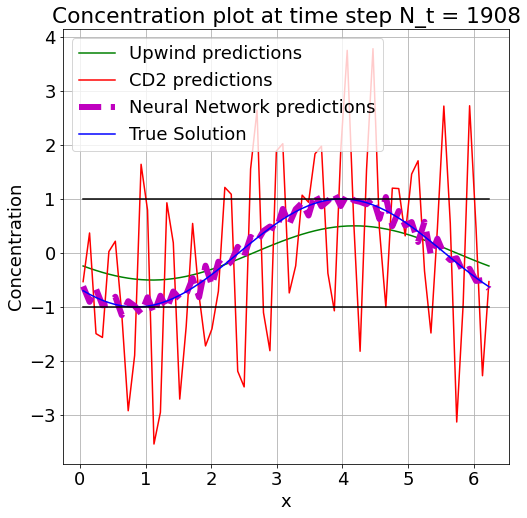

In [ ]:
def compare_t(nt):
  plt.rcParams.update({'font.size': 18})
  plt.figure(figsize=(8,8))
  plt.plot(x_fine,datu[nt],'g',label='Upwind predictions')
  plt.plot(x_fine,datc[nt],'r',label='CD2 predictions')
  plt.plot(x_fine,integrated_T1['concentration'].numpy().squeeze()[nt],'m',label='Neural Network predictions',linestyle='dashed',linewidth=6, markersize=12)
  plt.plot(x_fine,data_ana[nt],'b',label='True Solution')

  plt.plot(x_fine,-np.ones_like(x_fine),'k')
  plt.plot(x_fine,np.ones_like(x_fine),'k')
  plt.xlabel('x')
  plt.ylabel('Concentration')
  plt.legend()
  plt.grid()
  # plt.title(f'Concentration plot at time step N_t = {nt}',y=1.08)
  plt.title(f'Concentration plot at time step N_t = {nt}')
  # plt.tight_layout()
  plt.show()
compare_t(N_t-1)
# compare_t(30)
# compare_t(1000)
# compare_t(1500)


## Compare Amplitude progression with time for 3 schemes

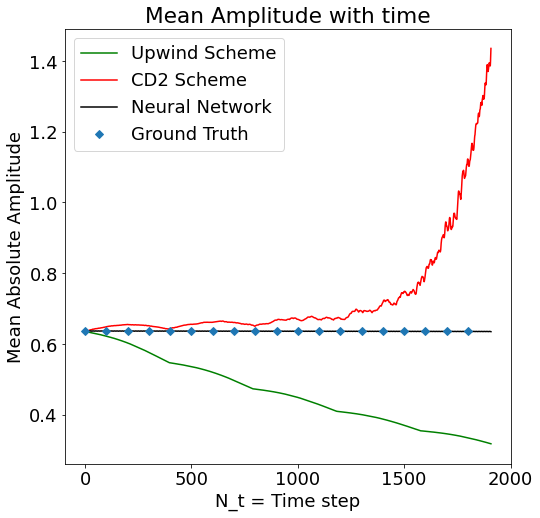

In [ ]:
ampUp_avg = np.stack([np.mean(np.abs(datu[i])) for i in range(N_t)])
ampCD_avg = np.stack([np.mean(np.abs(datc[i])) for i in range(N_t)])
ampNN_avg = np.stack([np.mean(np.abs(integrated_T1['concentration'].numpy().squeeze()[i])) for i in range(N_t)])
ampGround_avg = np.stack([np.mean(np.abs(data_ana[i])) for i in range(N_t)])

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,8))
plt.plot(np.arange(N_t),ampUp_avg,'g',label='Upwind Scheme')
plt.plot(np.arange(N_t),ampCD_avg,'r',label='CD2 Scheme')
plt.plot(np.arange(N_t),ampNN_avg,'k',label='Neural Network')
markers_on = np.arange(0,1900,100).tolist()
plt.plot(np.arange(N_t),ampGround_avg,'D',markevery=markers_on,label='Ground Truth')
plt.ylabel('Mean Absolute Amplitude')
plt.xlabel('N_t = Time step')
plt.legend()
plt.title('Mean Amplitude with time')
plt.show()

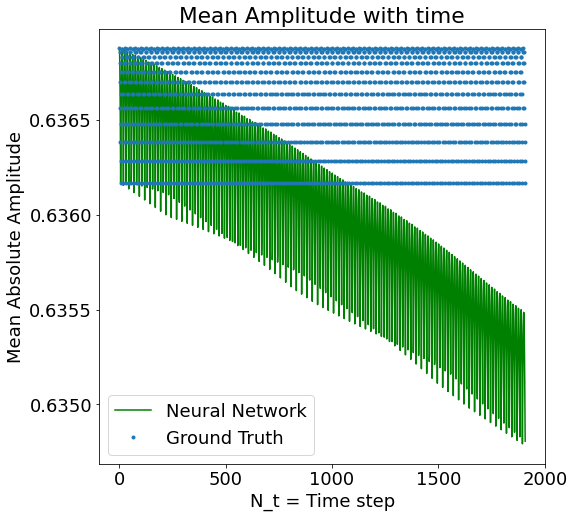

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,8))
# plt.plot(np.arange(N_t),ampUp_avg,'g',label='Upwind Scheme')
# plt.plot(np.arange(N_t),ampCD_avg,'r',label='CD2 Scheme')
plt.plot(np.arange(N_t),ampNN_avg,'g',label='Neural Network')
plt.plot(np.arange(N_t),ampGround_avg,'.',label='Ground Truth')
plt.ylabel('Mean Absolute Amplitude')
plt.xlabel('N_t = Time step')
plt.legend()
plt.title('Mean Amplitude with time')
plt.show()

## Compare Order of Accuracy 

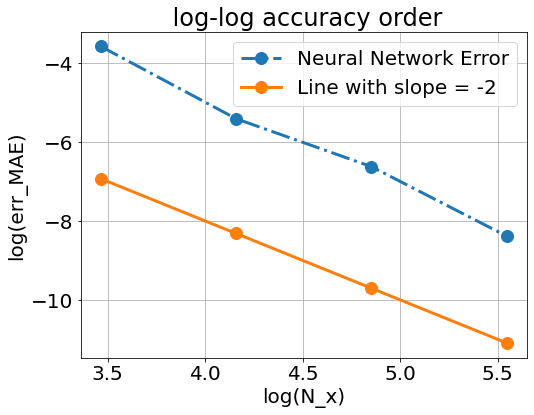

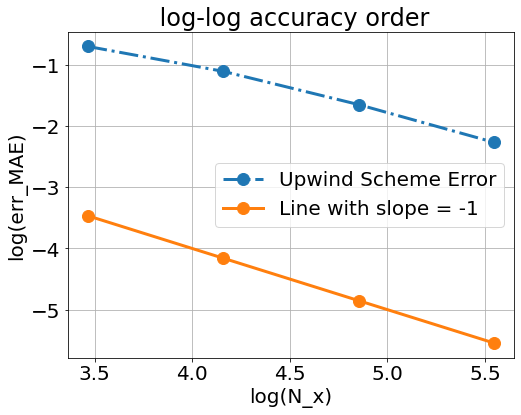

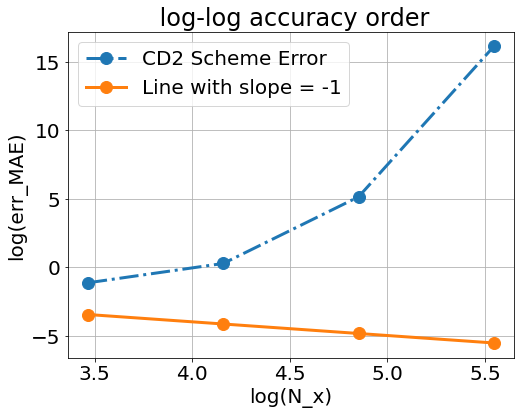

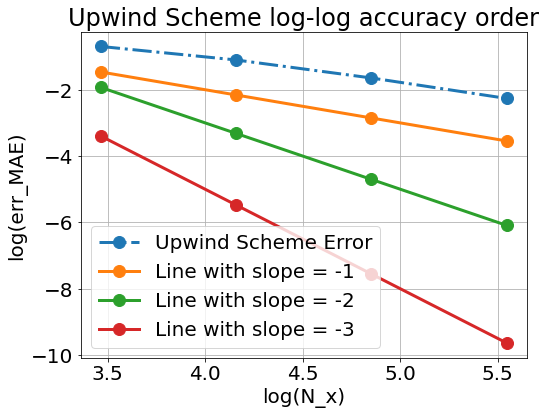

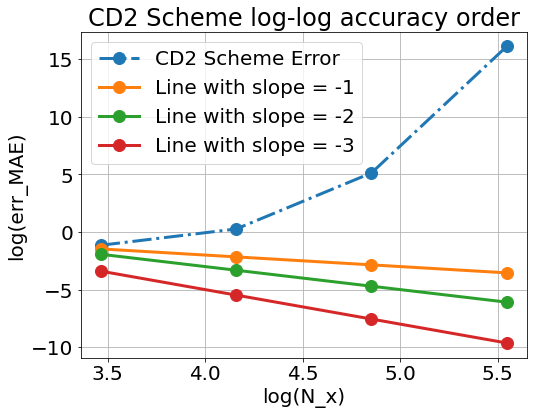

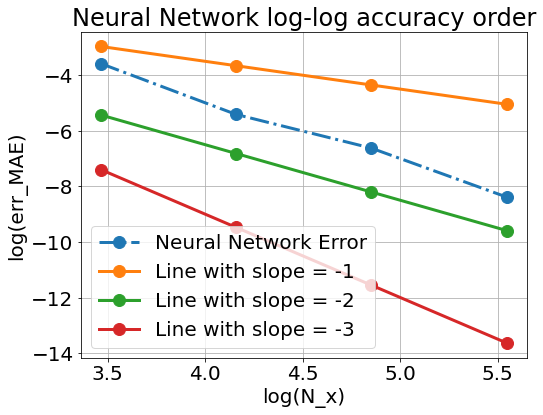

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
ne=np.loadtxt('nn')
ce=np.loadtxt('cd')
ue=np.loadtxt('up')
nl=2**(np.arange(5,9))
def OOA(x,y,m,c,mylabel='Neural Network Error'):
  plt.rcParams.update({'font.size': 20})
  plt.figure(figsize=(8,6))
  plt.plot(np.log(x),np.log(y),'o-',label=mylabel,linestyle='-.',linewidth=3, markersize=12)
  plt.plot(np.log(x),-m*np.log(x)+c,'o-',label=f'Line with slope = -{m}',linestyle='-',linewidth=3, markersize=12)
  plt.ylabel('log(err_MAE)')
  plt.xlabel('log(N_x)')
  plt.grid()
  plt.title(' log-log accuracy order')
  plt.legend()
  plt.show()

def OOA_loop(x,y,m_ls,c_ls,mylabel='Neural Network'):
  plt.rcParams.update({'font.size': 20})
  plt.figure(figsize=(8,6))
  plt.plot(np.log(x),np.log(y),'o-',label=mylabel+' Error',linestyle='-.',linewidth=3, markersize=12) 
  for i in range(len(m_ls)):
    plt.plot(np.log(x),-m_ls[i]*np.log(x)+c_ls[i],'o-',label=f'Line with slope = -{m_ls[i]}',linestyle='-',linewidth=3, markersize=12)
  plt.ylabel('log(err_MAE)')
  plt.xlabel('log(N_x)')
  plt.grid()
  plt.title(f'{mylabel} log-log accuracy order')
  plt.legend()
  plt.show()

OOA(nl,ne,2,0,'Neural Network Error')
OOA(nl,ue,1,0,'Upwind Scheme Error')
OOA(nl,ce,1,0,'CD2 Scheme Error')

OOA_loop(x=nl,y=ue,m_ls=[1,2,3],c_ls=[2,5,7],mylabel='Upwind Scheme')
OOA_loop(x=nl,y=ce,m_ls=[1,2,3],c_ls=[2,5,7],mylabel='CD2 Scheme')
OOA_loop(x=nl,y=ne,m_ls=[1,2,3],c_ls=[0.5,1.5,3],mylabel='Neural Network')


# Other ideas

In [ ]:
'N_x other than just powers of 2'
'''Mean solution amplitude with time 
MAE with time 
MAE with grid points increase'''